# Transdiagnostics Figure
Kai Sandbrink

2024-04-13

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
from scipy.stats import pearsonr
from utils import format_axis

from human_utils_transdiagnostics import get_clean_combined_data, compute_2D_correlation_transdiagnostics, compute_2D_correlation_matrices_transdiagnostics, plot_quantile_analysis_results, plot_td_quantile_analysis_results
from human_utils_transdiagnostics import getPCs
from human_utils_project import get_clean_data

import statsmodels.api as sm
import statsmodels.formula.api as smf

analysis_folder = os.path.join('panels', 'fig_transdiags_2023')
os.makedirs(analysis_folder, exist_ok=True)

## overall plotting options
square=True
axes_off = True
exp_date = '518-525-619-706'

enforceminusfirst = False
enforceminussecond = True

#logdiff = True
difftype = "frac_rem" #one of ['diff', 'logdiff', 'ratio', 'frac_rem']
meancenter = "off" #one of ["datacenter", "thiscenter", None]

simmetric = "cossim" #one of ['cossim', 'corr']

plt.close('all')

In [2]:
day1_test_mask_cutoff = {
    "groupA": {"lower": 10, "upper": 90},
    "groupB": {"lower": 8, "upper": 72}
}

human_data_file_base = ''

def get_alternate_TD_representation(AD, Compul, method, behavior=None):
    if method == "PCA":
        pcs = getPCs(AD, Compul, enforceminusfirst=enforceminusfirst, enforceminussecond=enforceminussecond)
        return (pcs[:,0], pcs[:,1])
    elif method == "linear":
        return ((AD + Compul), (Compul - AD))
    elif method == "linear_standardized":
        AD = (AD - np.mean(AD))/np.std(AD)
        Compul = (Compul - np.mean(Compul))/np.std(Compul)
        return ((AD + Compul), (Compul - AD))
    elif method == "conditioned":
        m, b = np.polyfit(Compul, AD, 1)
        AD_pred = Compul*m + b
        Compul_pred = AD/m - b/m
        return (AD - AD_pred, Compul - Compul_pred)
    elif method == "behavioral_prediction":
        if behavior is None:
            raise ValueError("behavior must be specified for method 'behavioral prediction'")
        m, b = np.polyfit(AD, behavior, 1)
        AD_pred = AD*m + b
        
        m, b = np.polyfit(Compul, behavior, 1)
        Compul_pred = Compul*m + b

        return (AD_pred, Compul_pred)
    elif method == "combined_behavior":
        X = np.stack((AD, Compul), axis=1)
        X = sm.add_constant(X)
        model = sm.OLS(behavior,X)
        model = model.fit()
        pred = model.predict(X)

        return (pred, pred)
    
method = 'PCA'

## Panel -A: Correlation among Transdiagnostics
### AD and Compul

In [3]:
mask = 'nomask'
iday = 2
day = 'day%d' %iday
with_nets = False
include_sleep = False
include_estimates = False
group = None

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/human_utils_project.py:1281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_day3['group'] = False


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

## output max/min stats for AD and Compul
print(f'Max AD: {df["AD"].max()}')
print(f'Min AD: {df["AD"].min()}')
print(f'Max Compul: {df["Compul"].max()}')
print(f'Min Compul: {df["Compul"].min()}')
print(f'n = {len(df)}')

# Calculate the Pearson correlation coefficient
corr, pv = pearsonr(df['Compul'], df['AD'])
print(f'Pearson correlation: {corr}')
print(f'P-value: {pv}')

Max AD: 2.190002448211354
Min AD: -1.7343173270292878
Max Compul: 1.2317438699185623
Min Compul: -1.639611316950506
n = 60
Pearson correlation: 0.01346476449301264
P-value: 0.9186707949356853


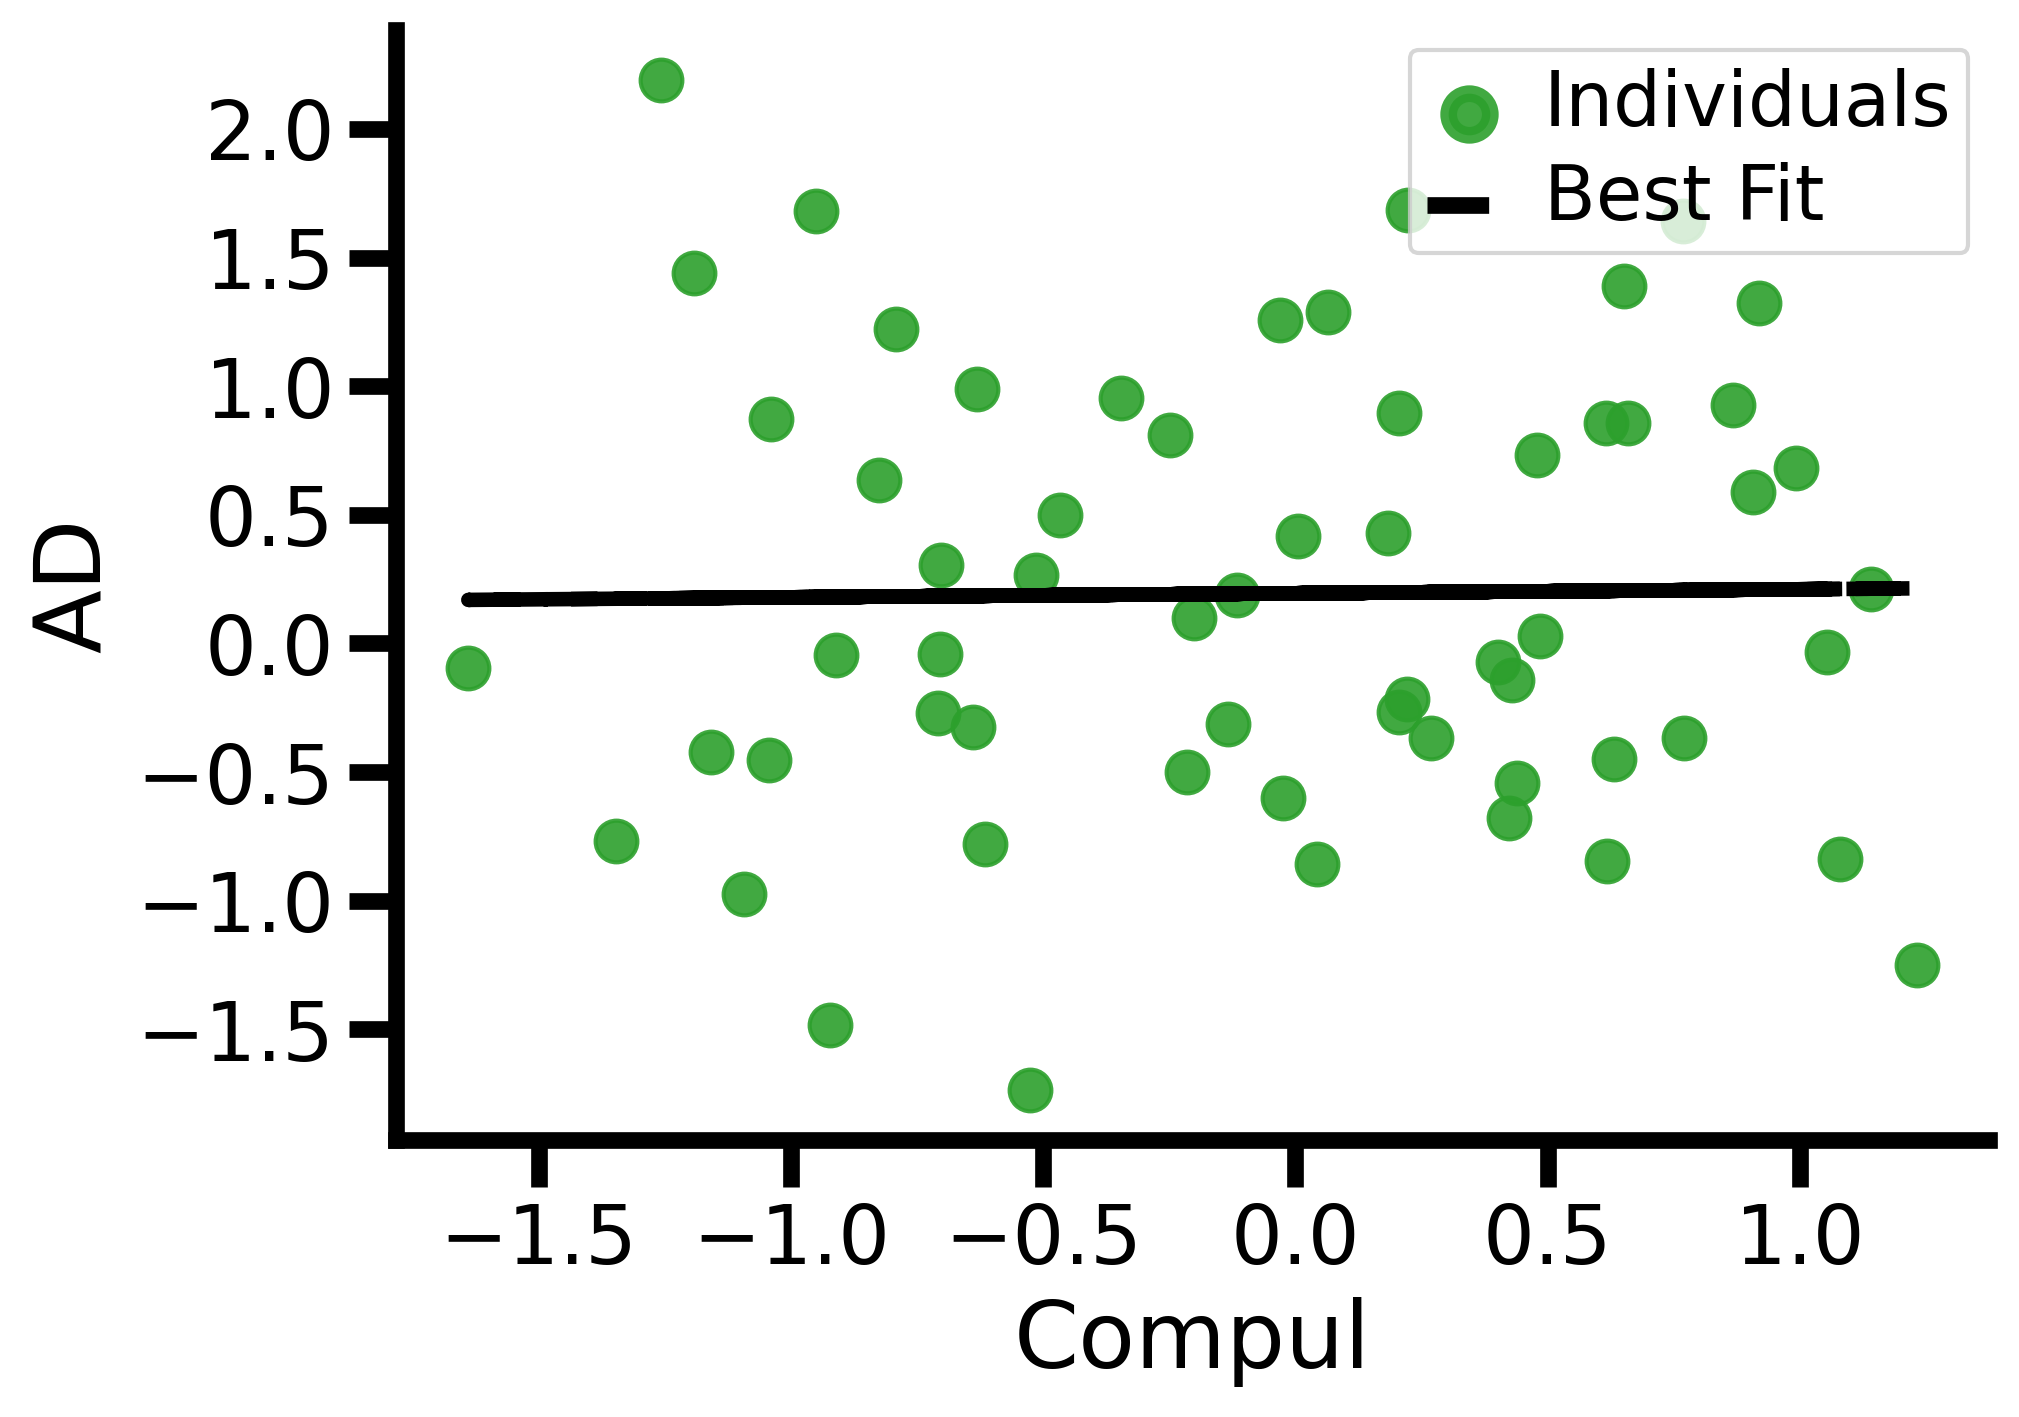

In [5]:
fig = plt.figure(dpi=300, figsize=(6.852, 4.903))
ax = fig.add_subplot(111)

# Calculate the line of best fit
m, b = np.polyfit(df['Compul'], df['AD'], 1)

# Plot the scatter plot
plt.scatter(df['Compul'], df['AD'], color='C2', alpha=0.9, label='Individuals', s=100)

# Plot the line of best fit
plt.plot(df['Compul'], m*df['Compul'] + b, color='black', linestyle='--', label='Best Fit')

plt.xlabel('Compul')
plt.ylabel('AD')

plt.legend()

format_axis(ax, font_size_multiplier=1.4)

In [6]:
len(df)

60

In [7]:
fig.savefig(os.path.join(analysis_folder, "corr_AD_Compul.png"))
fig.savefig(os.path.join(analysis_folder, "corr_AD_Compul.svg"))

In [8]:
print("line of best fit: ", m, b)

line of best fit:  0.01563354812790814 0.19487804072793677


In [9]:
print("done")

done


#### Predict AD based on Compul

In [10]:
AD_pred = df['Compul']*m + b
Compul_pred = df['AD']/m - b/m

### Compul and SW

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# Calculate the Pearson correlation coefficient
corr, _ = pearsonr(df['Compul'], df['SW'])
print(f'Pearson correlation: {corr}')

Pearson correlation: 0.37190177925400564


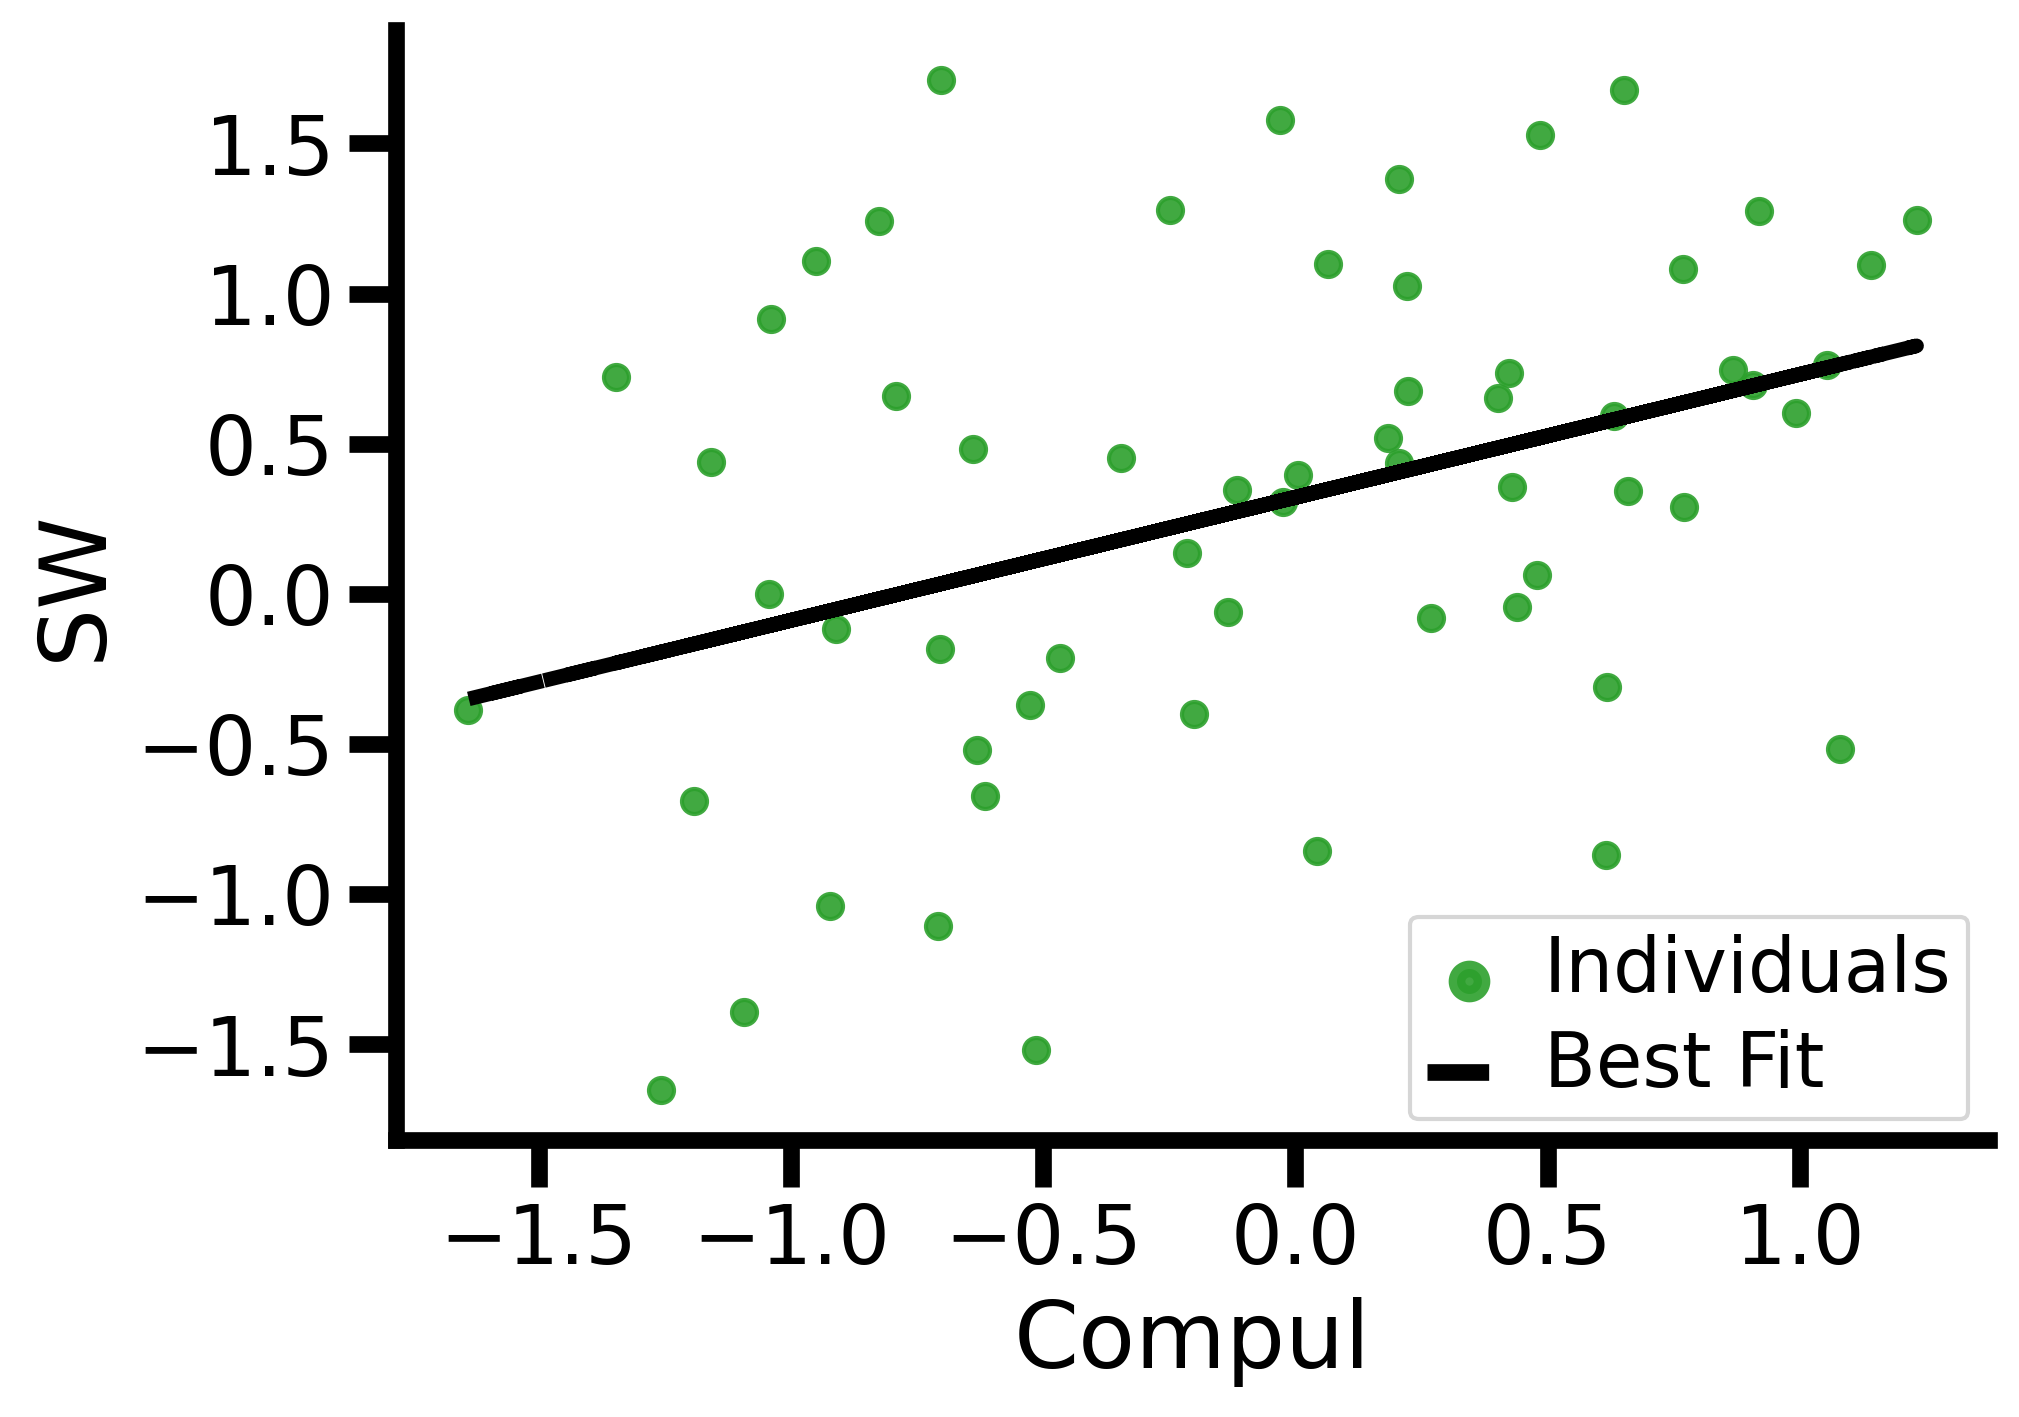

In [12]:
fig = plt.figure(dpi=300, figsize=(6.852, 4.903))
ax = fig.add_subplot(111)

# Calculate the line of best fit
m, b = np.polyfit(df['Compul'], df['SW'], 1)

# Plot the scatter plot
plt.scatter(df['Compul'], df['SW'], color='C2', alpha=0.9, label='Individuals')

# Plot the line of best fit
plt.plot(df['Compul'], m*df['Compul'] + b, color='black', linestyle='--', label='Best Fit')

plt.xlabel('Compul')
plt.ylabel('SW')

plt.legend()

format_axis(ax, font_size_multiplier=1.4)

In [13]:
fig.savefig(os.path.join(analysis_folder, "corr_SW_Compul.png"))
fig.savefig(os.path.join(analysis_folder, "corr_SW_Compul.svg"))

### AD and SW

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# Calculate the Pearson correlation coefficient
corr, _ = pearsonr(df['AD'], df['SW'])
print(f'Pearson correlation: {corr}')

Pearson correlation: 0.2970177373823557


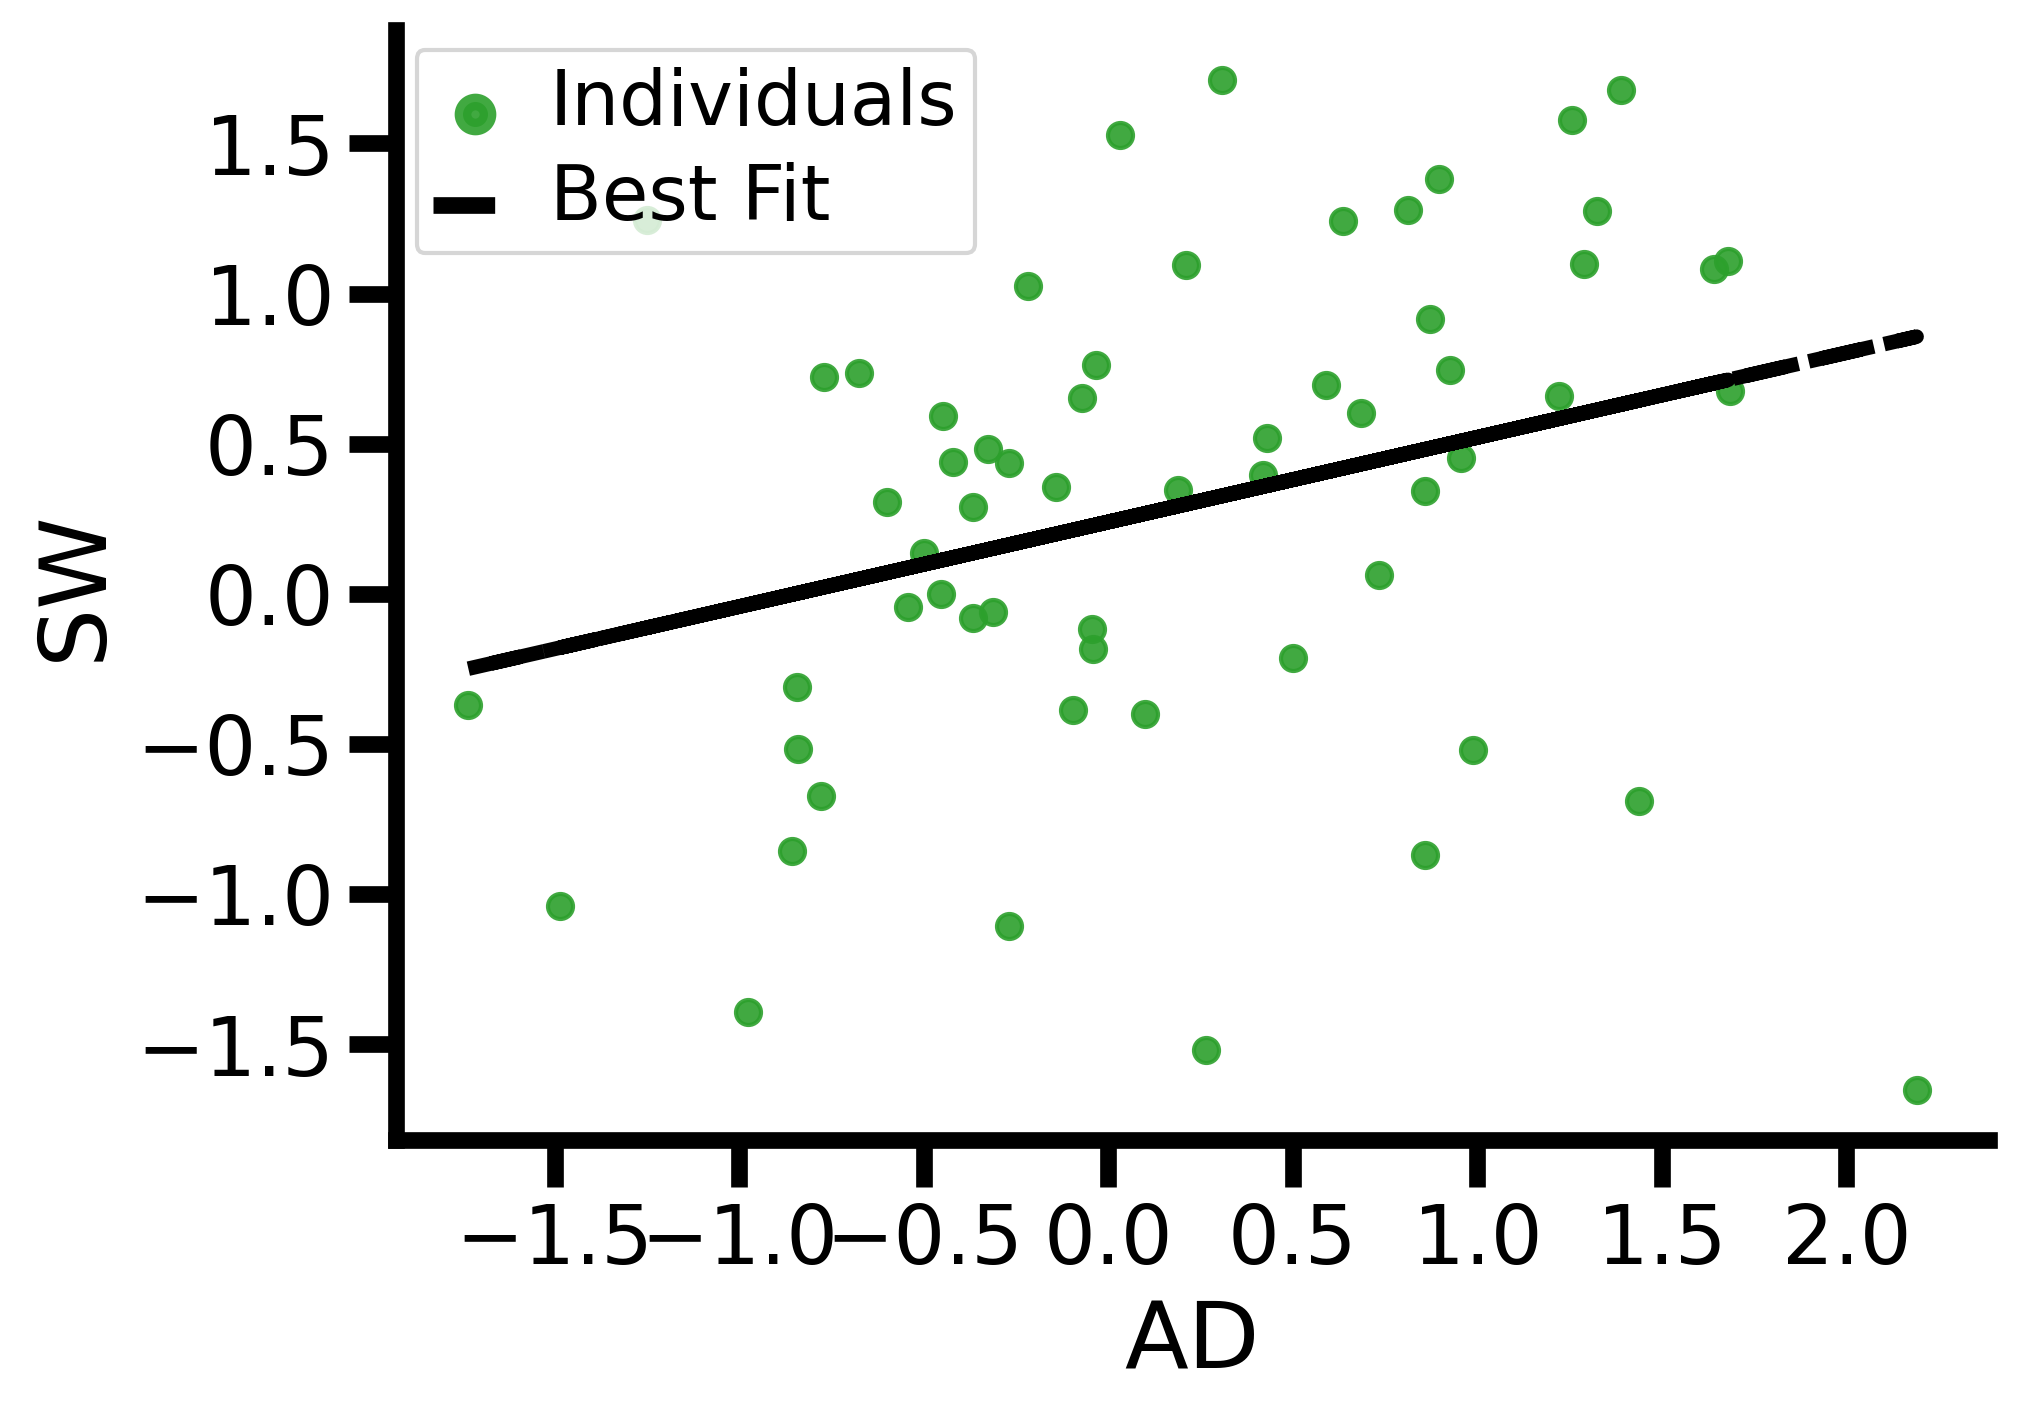

In [15]:
fig = plt.figure(dpi=300, figsize=(6.852, 4.903))
ax = fig.add_subplot(111)

# Calculate the line of best fit
m, b = np.polyfit(df['AD'], df['SW'], 1)

# Plot the scatter plot
plt.scatter(df['AD'], df['SW'], color='C2', alpha=0.9, label='Individuals')

# Plot the line of best fit
plt.plot(df['AD'], m*df['AD'] + b, color='black', linestyle='--', label='Best Fit')

plt.xlabel('AD')
plt.ylabel('SW')

plt.legend()

format_axis(ax, font_size_multiplier=1.4)

In [16]:
fig.savefig(os.path.join(analysis_folder, "corr_SW_AD.png"))
fig.savefig(os.path.join(analysis_folder, "corr_SW_AD.svg"))

### Computation of optimal linear prediction of number of observes by AD and Compul

In [17]:
### BOOTSTRAP 100x

paramss = []
n_iterations = 100

for i in range(n_iterations):

    Y_true = np.stack(df['n_observes'].values).sum(axis=1)
    X = df[['AD', 'Compul']]

    X = sm.add_constant(X)
    model = sm.OLS(Y_true, X).fit()
    print(model.summary())

    Y_pred = model.predict(X)
    #Y_res = Y_true - Y_pred

    #Y_res = - model.params['AD'] * df['Compul'] + model.params['Compul'] * df['AD']

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     2.205
Date:                Thu, 29 Aug 2024   Prob (F-statistic):              0.120
Time:                        13:18:26   Log-Likelihood:                -272.36
No. Observations:                  60   AIC:                             550.7
Df Residuals:                      57   BIC:                             557.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.1514      3.089     16.559      0.0

## Panel A: Task 1 Observes

### AD

In [18]:
mask = 'nomask'
iday = 2
day = 'day%d' %iday
with_nets = False
include_sleep = False
include_estimates = False
group = None

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/human_utils_project.py:1281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_day3['group'] = False


[[3.71428571 3.71428571 5.28571429 4.71428571 5.57142857 7.14285714
  7.57142857 8.28571429 6.        ]
 [4.14285714 4.14285714 7.14285714 6.85714286 8.42857143 8.42857143
  8.71428571 8.71428571 7.71428571]
 [3.66666667 4.         5.16666667 3.66666667 6.         4.83333333
  5.66666667 5.5        6.        ]
 [4.42857143 4.         4.57142857 6.         5.85714286 6.57142857
  6.71428571 8.42857143 6.71428571]
 [6.5        5.83333333 6.33333333 6.16666667 6.33333333 7.5
  7.33333333 7.         8.        ]
 [1.71428571 1.28571429 2.14285714 2.71428571 3.85714286 4.28571429
  3.71428571 3.71428571 4.42857143]
 [3.5        4.         6.33333333 5.16666667 6.5        5.33333333
  6.33333333 6.33333333 7.16666667]
 [4.14285714 3.85714286 5.28571429 5.71428571 6.71428571 5.71428571
  7.42857143 8.14285714 5.85714286]
 [3.         3.14285714 3.85714286 3.         4.71428571 7.14285714
  5.14285714 6.85714286 5.14285714]]


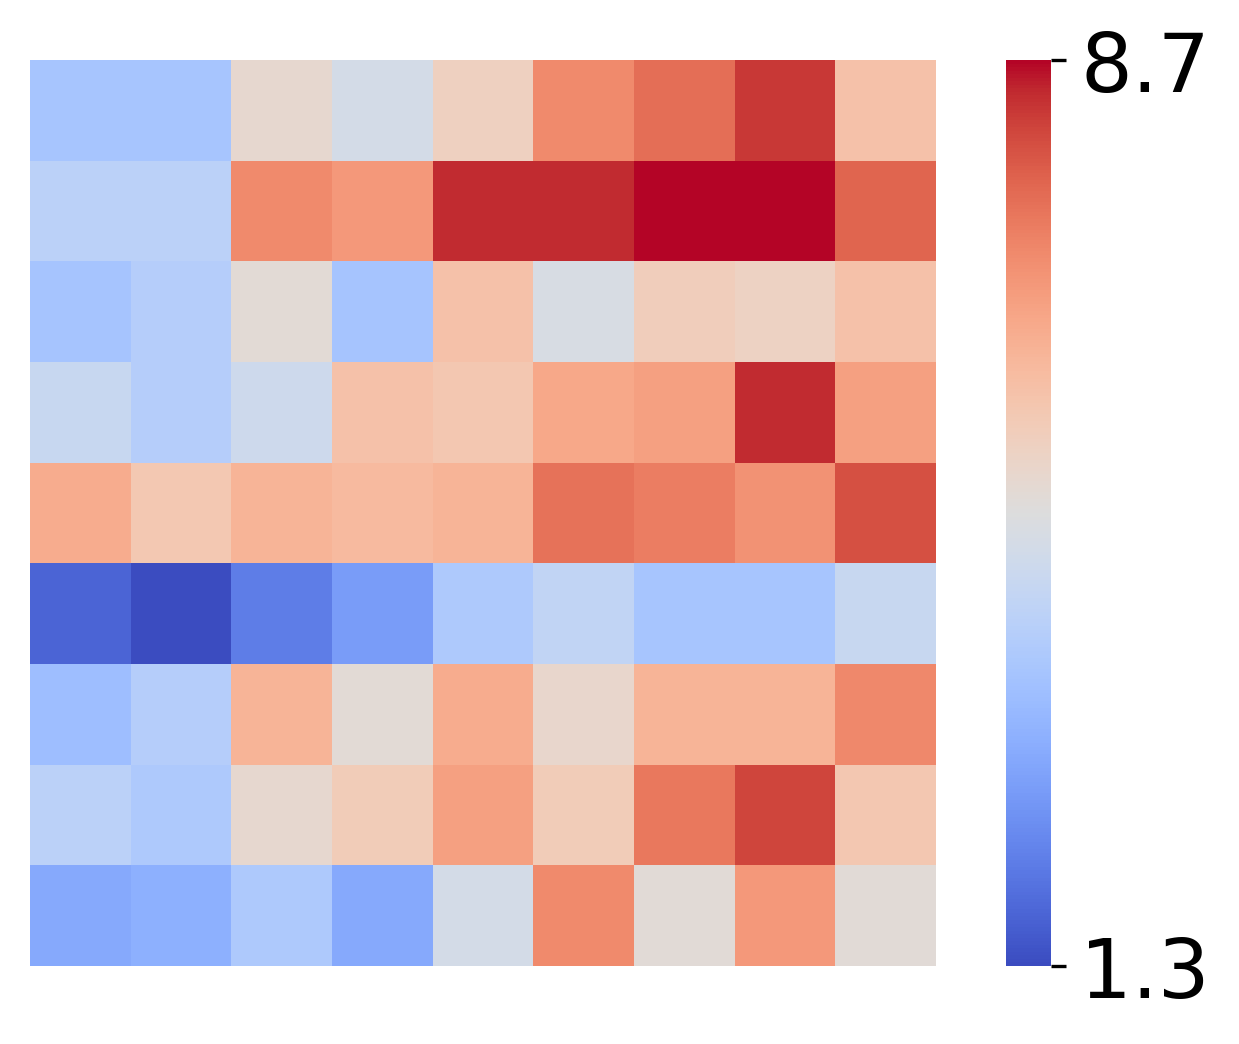

In [19]:
from human_utils_transdiagnostics import plot_td_quantile_analysis_results
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Observes", col2name="AD", groups =None, num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)

In [20]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_observes_AD.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_observes_AD.svg"))

### AD Residual

PC1 loadings:  [-0.99899698 -0.0447777 ]
PC2 loadings:  [ 0.0447777  -0.99899698]
Variance explained by PC1:  0.574419642744996
Variance explained by PC2:  0.42558035725500404
Flipped PC1 to enforce second component to be negative.
[[4.57142857 3.42857143 6.         5.         6.         7.71428571
  7.85714286 8.71428571 7.        ]
 [3.28571429 4.42857143 6.42857143 6.57142857 8.         7.85714286
  8.42857143 8.28571429 6.71428571]
 [3.66666667 4.         5.16666667 3.66666667 6.         4.83333333
  5.66666667 5.5        6.        ]
 [4.14285714 4.28571429 4.57142857 6.57142857 6.28571429 7.42857143
  6.71428571 8.85714286 7.        ]
 [6.66666667 4.66666667 4.83333333 5.83333333 5.83333333 7.5
  7.16666667 6.5        8.33333333]
 [1.85714286 2.         3.42857143 2.42857143 3.85714286 3.42857143
  3.85714286 3.71428571 3.85714286]
 [3.5        4.         6.33333333 5.16666667 6.5        5.33333333
  6.33333333 6.33333333 7.16666667]
 [4.14285714 3.85714286 5.28571429 5.71428571 6

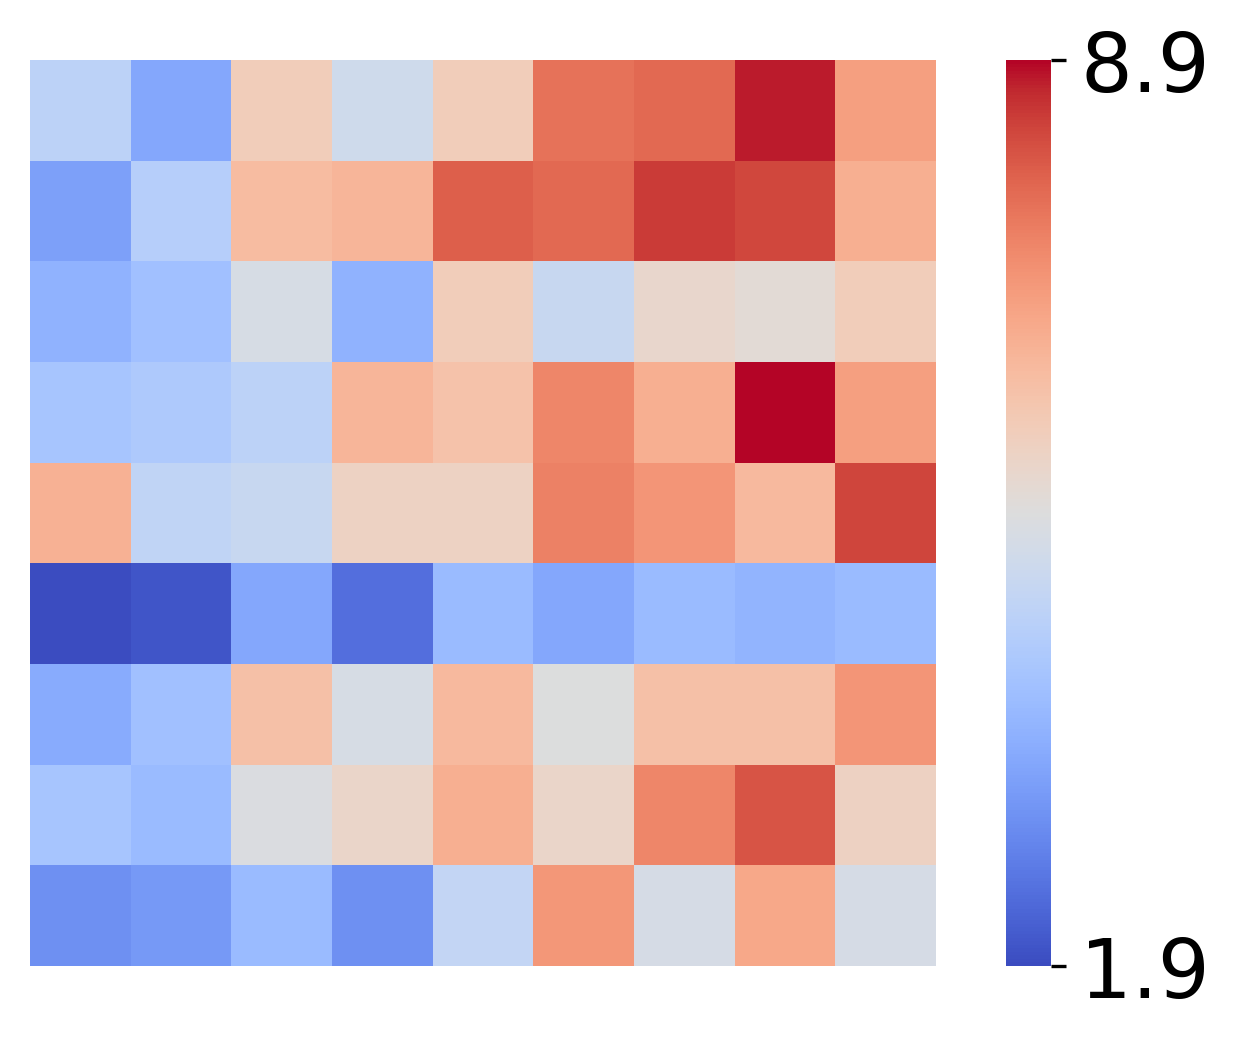

In [21]:
from human_utils_transdiagnostics import plot_td_quantile_analysis_results

quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), get_alternate_TD_representation(df['AD'], df['Compul'], method, np.stack(df['n_observes'].values).sum(axis=1))[0], np.stack(df["effs"].values), "Observes", col2name="AD", groups =None, num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['Compul'] - df['AD'] , np.stack(df["effs"].values), "Observes", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['AD'] - AD_pred, np.stack(df["effs"].values), "Observes", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)

In [22]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_observes_AD_residual.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_observes_AD_residual.svg"))

### Compul

[[3.         3.28571429 4.         4.42857143 5.42857143 6.57142857
  5.         7.71428571 5.28571429]
 [3.         2.42857143 3.85714286 4.14285714 4.         4.28571429
  4.         6.         3.85714286]
 [3.83333333 4.         5.66666667 4.         7.66666667 8.33333333
  7.83333333 8.33333333 7.83333333]
 [3.57142857 4.85714286 3.85714286 3.71428571 5.14285714 4.71428571
  5.14285714 5.42857143 5.85714286]
 [4.66666667 4.33333333 6.16666667 5.83333333 7.66666667 7.33333333
  8.16666667 8.33333333 7.16666667]
 [3.28571429 2.         3.85714286 4.42857143 5.28571429 5.57142857
  6.14285714 5.71428571 6.        ]
 [5.16666667 3.66666667 7.16666667 7.33333333 7.83333333 8.
  9.         8.83333333 8.83333333]
 [3.14285714 2.28571429 4.71428571 5.         5.42857143 6.28571429
  6.28571429 7.42857143 6.42857143]
 [5.14285714 6.85714286 7.         5.42857143 6.14285714 6.71428571
  7.85714286 6.14285714 6.14285714]]


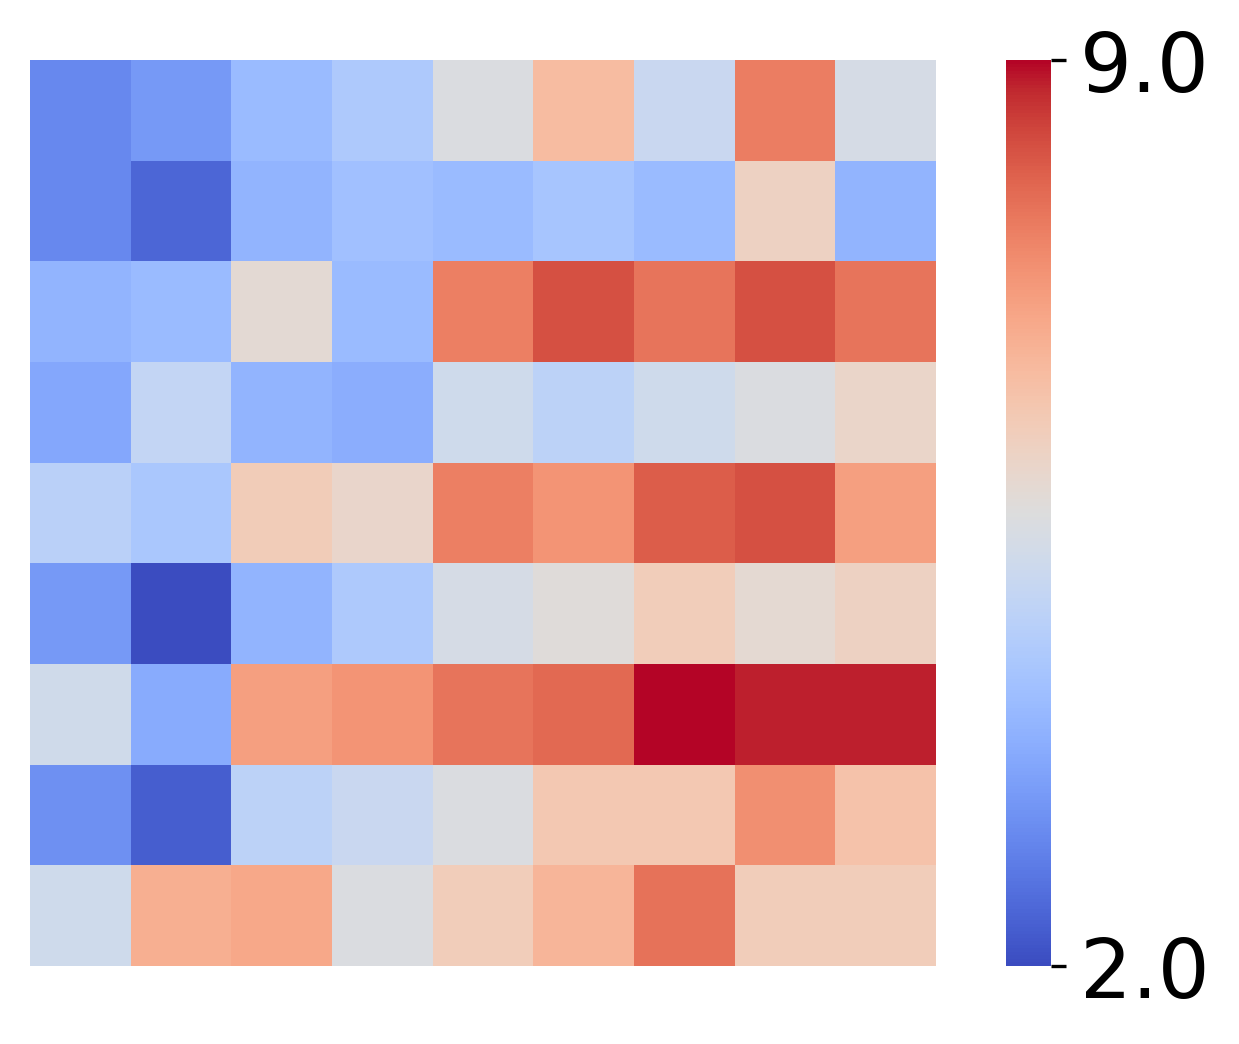

In [23]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Observes", col2name = "Compul", groups = None, num_bins =9, combine_groups = True, annot=False , square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Observes", col2name = "Compul", groups = df["group"], num_bins =9, combine_groups = True, annot=False , square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Observes", col2name = "Compul", groups = df["group"], num_bins =9, combine_groups = False, annot=False)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Observes", col2name = "Compul", groups = None, num_bins =9, combine_groups = False, annot=False)

In [24]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_observes_Compul.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_observes_Compul.svg"))

### Compul Residual

PC1 loadings:  [-0.99899698 -0.0447777 ]
PC2 loadings:  [ 0.0447777  -0.99899698]
Variance explained by PC1:  0.574419642744996
Variance explained by PC2:  0.42558035725500404
Flipped PC1 to enforce second component to be negative.
[[5.14285714 6.85714286 7.         5.42857143 6.14285714 6.71428571
  7.85714286 6.14285714 6.14285714]
 [3.14285714 2.28571429 4.71428571 5.         5.42857143 6.28571429
  6.28571429 7.42857143 6.42857143]
 [5.16666667 3.66666667 7.16666667 7.33333333 7.83333333 8.
  9.         8.83333333 8.83333333]
 [3.28571429 2.         3.85714286 4.42857143 5.28571429 5.57142857
  6.14285714 5.71428571 6.        ]
 [4.66666667 5.16666667 7.33333333 5.66666667 7.66666667 6.16666667
  8.5        8.66666667 7.5       ]
 [4.         4.71428571 4.28571429 3.57142857 6.42857143 6.28571429
  6.14285714 6.57142857 6.42857143]
 [4.66666667 3.83333333 4.83333333 6.16666667 5.16666667 8.
  6.         7.33333333 6.5       ]
 [1.71428571 1.85714286 2.85714286 2.42857143 5.        

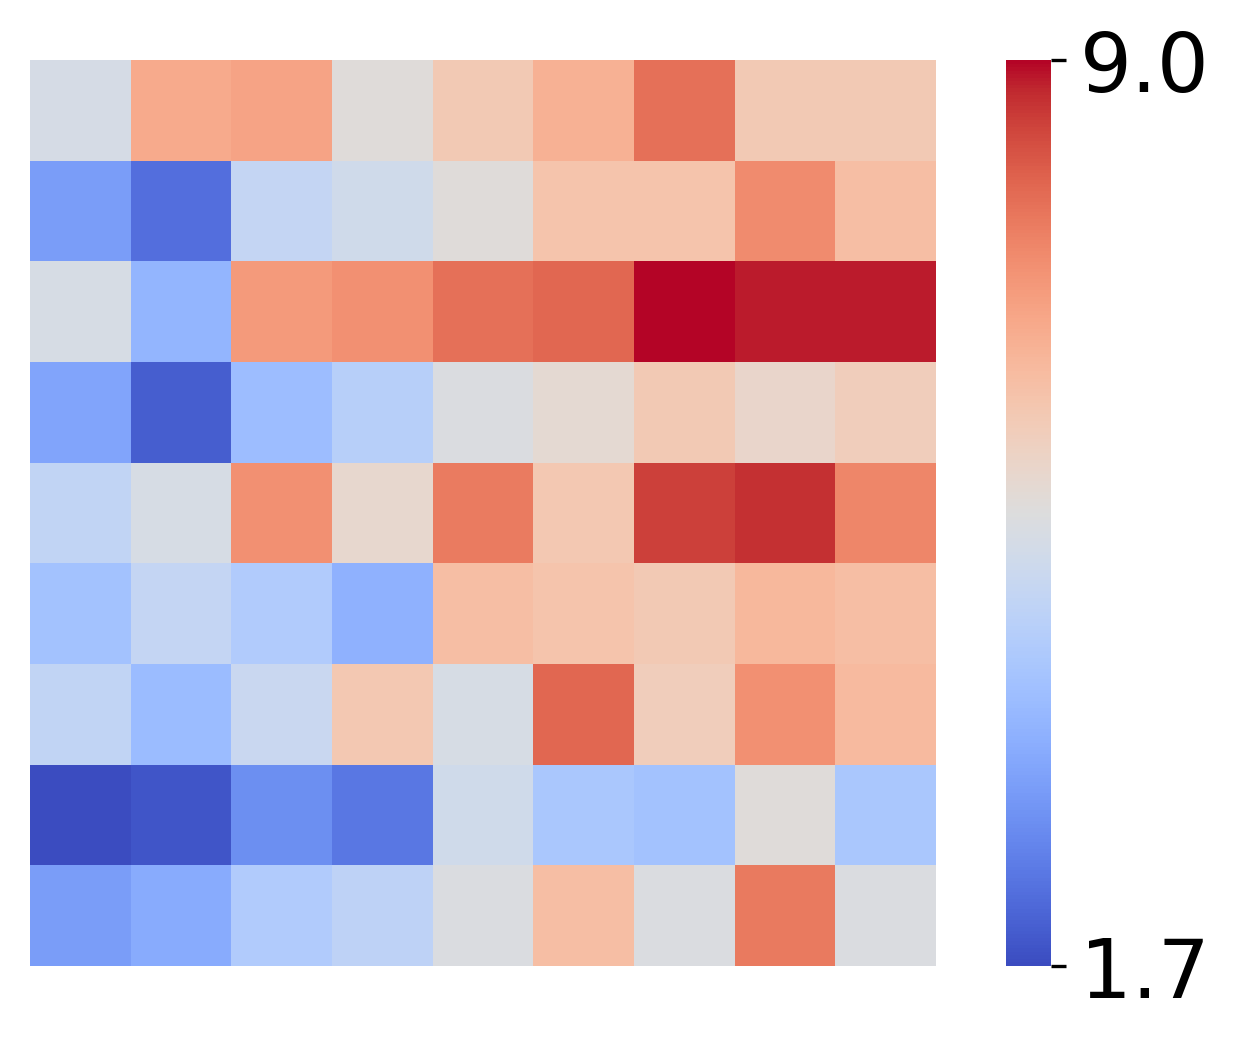

In [25]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), get_alternate_TD_representation(df['AD'], df['Compul'], method, np.stack(df['n_observes'].values).sum(axis=1))[1], np.stack(df["effs"].values), "Observes", col2name = "Compul", groups = None, num_bins =9, combine_groups = True, annot=False , square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Observes", col2name = "Compul", groups = df["group"], num_bins =9, combine_groups = True, annot=False , square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Observes", col2name = "Compul", groups = df["group"], num_bins =9, combine_groups = False, annot=False)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Observes", col2name = "Compul", groups = None, num_bins =9, combine_groups = False, annot=False)

In [26]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_observes_Compul_residual.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_observes_Compul_residual.svg"))

### SW

[[2.71428571 2.57142857 2.71428571 4.71428571 2.85714286 5.71428571
  2.71428571 6.         3.85714286]
 [4.14285714 5.71428571 6.14285714 5.71428571 7.71428571 7.85714286
  8.28571429 8.71428571 7.14285714]
 [3.16666667 4.         3.66666667 3.83333333 4.33333333 6.16666667
  6.66666667 7.83333333 6.83333333]
 [4.28571429 4.14285714 7.         6.85714286 8.85714286 7.71428571
  8.57142857 8.57142857 9.        ]
 [3.         3.         3.         3.83333333 5.66666667 5.83333333
  5.66666667 6.         6.        ]
 [4.57142857 3.         5.28571429 5.14285714 6.28571429 5.57142857
  6.         6.28571429 5.71428571]
 [4.         3.16666667 6.16666667 5.5        6.         7.
  7.5        7.5        7.33333333]
 [3.28571429 3.57142857 5.85714286 3.57142857 5.42857143 5.14285714
  6.42857143 5.85714286 4.28571429]
 [5.14285714 4.28571429 5.57142857 4.57142857 6.42857143 6.14285714
  6.85714286 6.57142857 6.71428571]]


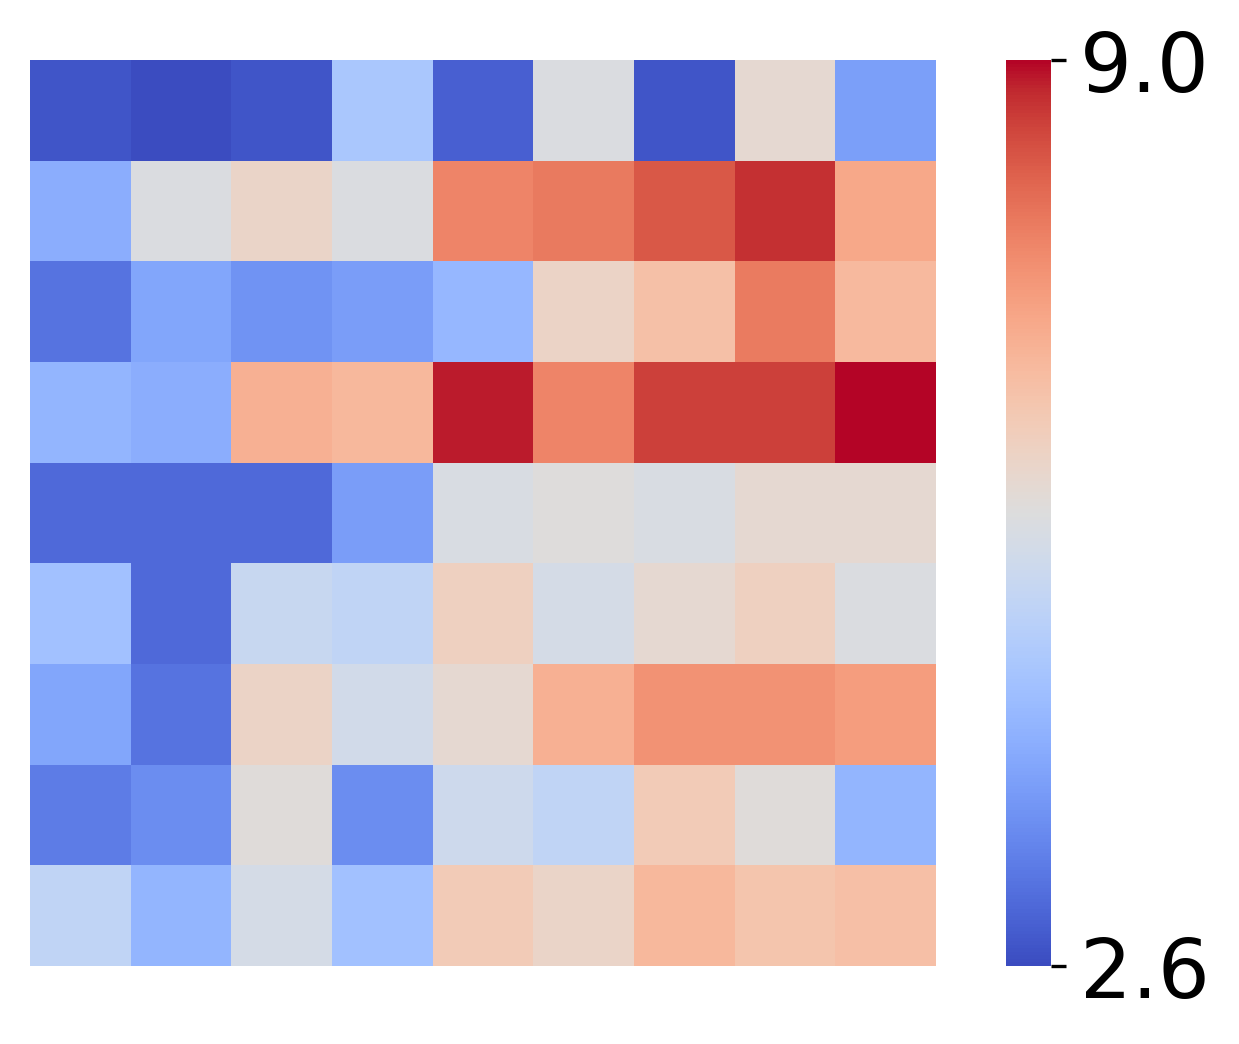

In [27]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['SW'], np.stack(df["effs"].values), "Observes", col2name = "SW", groups = None, num_bins =9, combine_groups = True, annot=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['SW'], np.stack(df["effs"].values), "Observes", col2name = "SW", groups = None, num_bins =9, combine_groups = False, annot=False)

In [28]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_observes_SW.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_observes_SW.svg"))

### Trait-level simulations

In [29]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_anal import pepe_human_ape_models as ape_models
from settings_anal import trait_simulated_participants_folder_t1 as simulated_participants_folder
from settings_anal import trait_sim_timestamp_t1 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)

sim_rewss, sim_obss, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)

## flip to correct for switching from tau to efficacy
sim_obss = np.flip(sim_obss.T,axis=1)
sim_rewss = np.flip(sim_rewss.T, axis=1)

original_mag_perturbation = 1
with open(os.path.join('data', 'sim_perturbed_participants', 'pepe', 'sim', 'mag%d'%(original_mag_perturbation*100), '%s_simulated_participant_perturbations_sim_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

[[0.15988235 0.18052941 0.21082353 0.26347059 0.34735294 0.50529412
  0.83394118 1.49564706 2.58305882]
 [0.25341176 0.31517647 0.39735294 0.53688235 0.78470588 1.29470588
  2.28329412 3.68005882 5.17394118]
 [0.430125   0.5429375  0.721      1.050375   1.733      2.9405
  4.533375   5.9401875  6.8249375 ]
 [0.55476471 0.70852941 0.95476471 1.49817647 2.56717647 4.15505882
  5.67258824 6.66129412 7.33923529]
 [0.6714375  0.8781875  1.2669375  2.0485     3.4874375  5.1036875
  6.31225    7.08475    7.6666875 ]
 [0.83558824 1.14270588 1.77435294 2.96935294 4.60135294 5.93970588
  6.87017647 7.52617647 8.00352941]
 [1.0624375  1.56325    2.5553125  4.0714375  5.5256875  6.5920625
  7.3216875  7.8594375  8.2754375 ]
 [2.02494118 3.14505882 4.55623529 5.86211765 6.81152941 7.52217647
  8.03447059 8.44223529 8.77358824]
 [4.64182353 5.82529412 6.79641176 7.52064706 8.08888235 8.52441176
  8.91241176 9.23094118 9.55747059]]


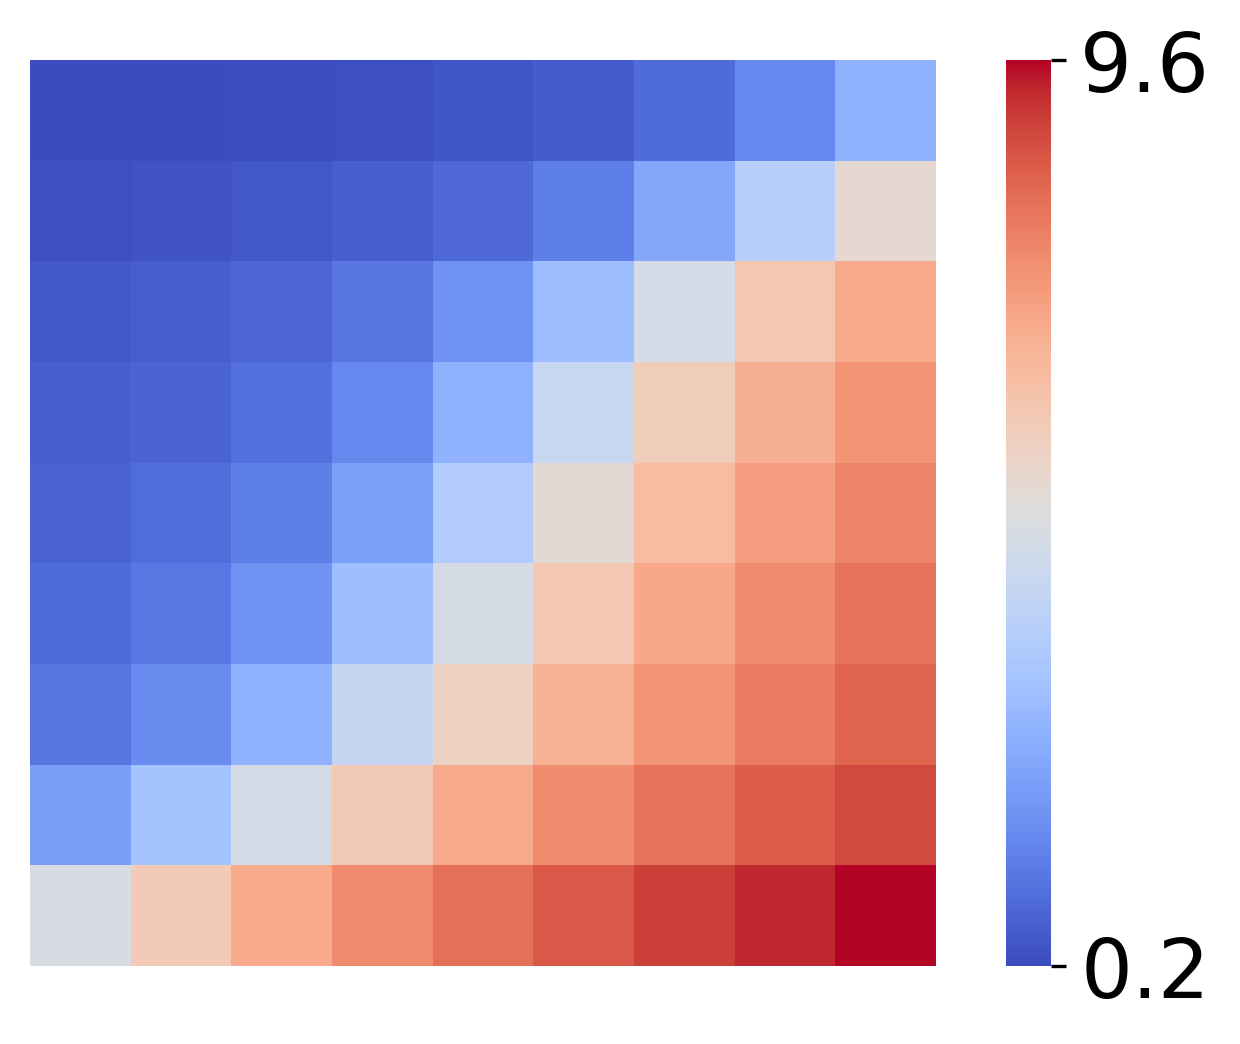

In [30]:
quantile_fig = plot_td_quantile_analysis_results(sim_obss, sim_participant_perturbations, effs, "Observes", col2name = "Belief", groups = None, num_bins =9, annot=False, square=square, axes_off=axes_off)

In [31]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_observes_NN.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_observes_NN.svg"))

### Permuted Simulations

In [32]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_anal import pepe_human_ape_models as ape_models
#from settings_anal import trait_simulated_participants_folder_t1 as simulated_participants_folder
from settings_anal import zeros_simulated_participants_folder_t1 as simulated_participants_folder
from settings_anal import zeros_sim_timestamp_t1 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)

sim_rewss, sim_obss, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)

## flip to correct for switching from tau to efficacy
sim_obss = np.flip(sim_obss.T,axis=1)
sim_rewss = np.flip(sim_rewss.T, axis=1)

original_mag_perturbation = 1
with open(os.path.join('data', 'sim_perturbed_participants', 'pepe', 'nostruc', 'mag%d'%(original_mag_perturbation*100), '%s_simulated_participant_perturbations_nostruc_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy


# ## save the permuted perturbations
# if not os.path.exists(os.path.join('data', 'sim_perturbed_participants', 'pepe', 'sim', 'mag%d'%(original_mag_perturbation*100), '%s_simulated_participant_perturbations_sim_mag_permuted.pkl' %sim_timestamp)):

#     original_mag_perturbation = 1
#     with open(os.path.join('data', 'sim_perturbed_participants', 'pepe', 'sim', 'mag%d'%(original_mag_perturbation*100), '%s_simulated_participant_perturbations_sim_mag.pkl' %sim_timestamp), 'rb') as f:
#         sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy
    
#     ## Permute sim_participant_perturbations
#     sim_participant_perturbations = np.random.permutation(sim_participant_perturbations)
#     pickle.dump(sim_participant_perturbations, open(os.path.join('data', 'sim_perturbed_participants', 'pepe', 'sim', 'mag%d'%(original_mag_perturbation*100), '%s_simulated_participant_perturbations_sim_mag_permuted.pkl' %sim_timestamp), 'wb'))

#     print('new permutation')

# else:
#     with open(os.path.join('data', 'sim_perturbed_participants', 'pepe', 'sim', 'mag%d'%(original_mag_perturbation*100), '%s_simulated_participant_perturbations_sim_mag_permuted.pkl' %sim_timestamp), 'rb') as f:
#         sim_participant_perturbations = pickle.load(f)
#     print('loaded')

print(sim_obss, sim_participant_perturbations, effs)

[[0.584 0.784 1.166 ... 6.014 6.951 7.485]
 [0.619 0.804 1.125 ... 6.127 6.934 7.511]
 [0.644 0.819 1.132 ... 6.054 6.918 7.543]
 ...
 [0.606 0.778 1.137 ... 6.064 6.988 7.612]
 [0.611 0.834 1.127 ... 6.089 6.957 7.508]
 [0.608 0.797 1.174 ... 6.14  6.978 7.54 ]] [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0.] [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]


[[0.61814667 0.79918    1.12219333 1.79572667 3.07134667 4.73412667
  6.06217333 6.93296    7.53557333]
 [0.61814667 0.79918    1.12219333 1.79572667 3.07134667 4.73412667
  6.06217333 6.93296    7.53557333]
 [0.61814667 0.79918    1.12219333 1.79572667 3.07134667 4.73412667
  6.06217333 6.93296    7.53557333]
 [0.61814667 0.79918    1.12219333 1.79572667 3.07134667 4.73412667
  6.06217333 6.93296    7.53557333]
 [0.61814667 0.79918    1.12219333 1.79572667 3.07134667 4.73412667
  6.06217333 6.93296    7.53557333]
 [0.61814667 0.79918    1.12219333 1.79572667 3.07134667 4.73412667
  6.06217333 6.93296    7.53557333]
 [0.61814667 0.79918    1.12219333 1.79572667 3.07134667 4.73412667
  6.06217333 6.93296    7.53557333]
 [0.61814667 0.79918    1.12219333 1.79572667 3.07134667 4.73412667
  6.06217333 6.93296    7.53557333]
 [0.61814667 0.79918    1.12219333 1.79572667 3.07134667 4.73412667
  6.06217333 6.93296    7.53557333]]


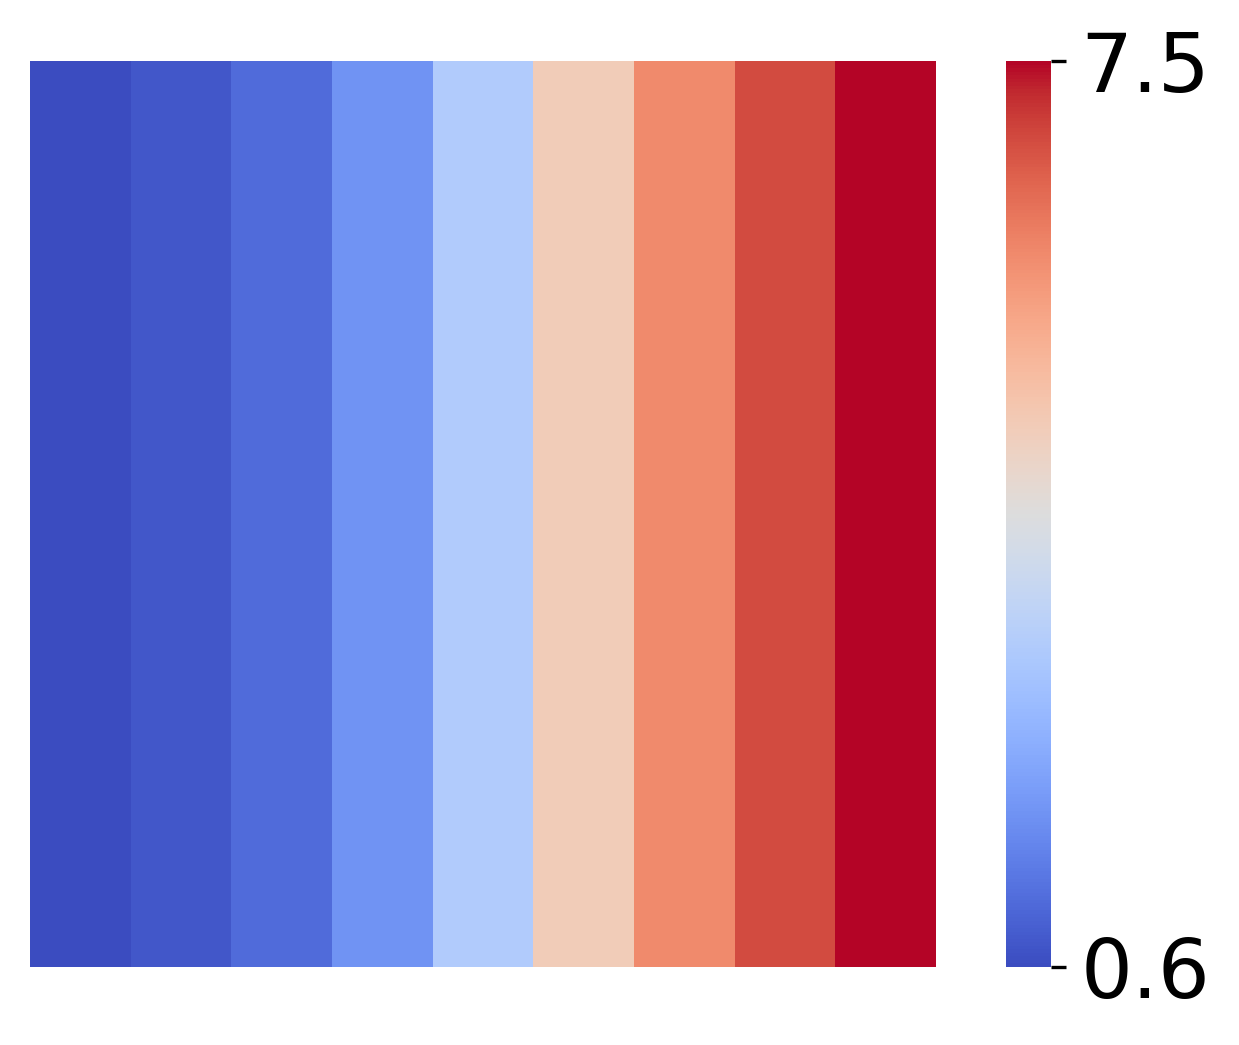

In [33]:
quantile_fig = plot_td_quantile_analysis_results(sim_obss, sim_participant_perturbations, effs, "Observes", col2name = "Belief", groups = None, num_bins =9, annot=False, square=square, axes_off=axes_off)

In [34]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_observes_NN_permuted.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_observes_NN_permuted.svg"))

## Panel B: Task 1 Rewards
### AD

In [35]:
mask = 'nomask'
iday = 2
day = 'day%d' %iday
with_nets = False
include_sleep = False
include_estimates = False
group = None

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/human_utils_project.py:1281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_day3['group'] = False


[[22.42857143 23.57142857 23.42857143 24.71428571 23.28571429 26.
  28.14285714 26.42857143 30.57142857]
 [26.14285714 23.71428571 23.28571429 22.42857143 27.         27.85714286
  31.57142857 28.28571429 28.71428571]
 [25.33333333 24.66666667 22.5        25.         25.16666667 27.83333333
  30.33333333 32.16666667 31.66666667]
 [24.28571429 23.28571429 24.85714286 24.85714286 26.42857143 27.71428571
  28.85714286 27.71428571 31.28571429]
 [21.         23.5        24.16666667 25.33333333 25.16666667 26.33333333
  29.33333333 29.16666667 30.16666667]
 [22.         25.42857143 25.71428571 23.71428571 28.71428571 26.42857143
  26.71428571 26.57142857 28.42857143]
 [25.         23.33333333 26.5        26.16666667 26.33333333 22.66666667
  26.         31.66666667 30.16666667]
 [23.57142857 24.85714286 24.85714286 23.14285714 25.28571429 27.28571429
  25.85714286 30.28571429 30.85714286]
 [23.28571429 23.14285714 22.14285714 24.28571429 26.14285714 26.85714286
  25.42857143 29.42857143 36.1

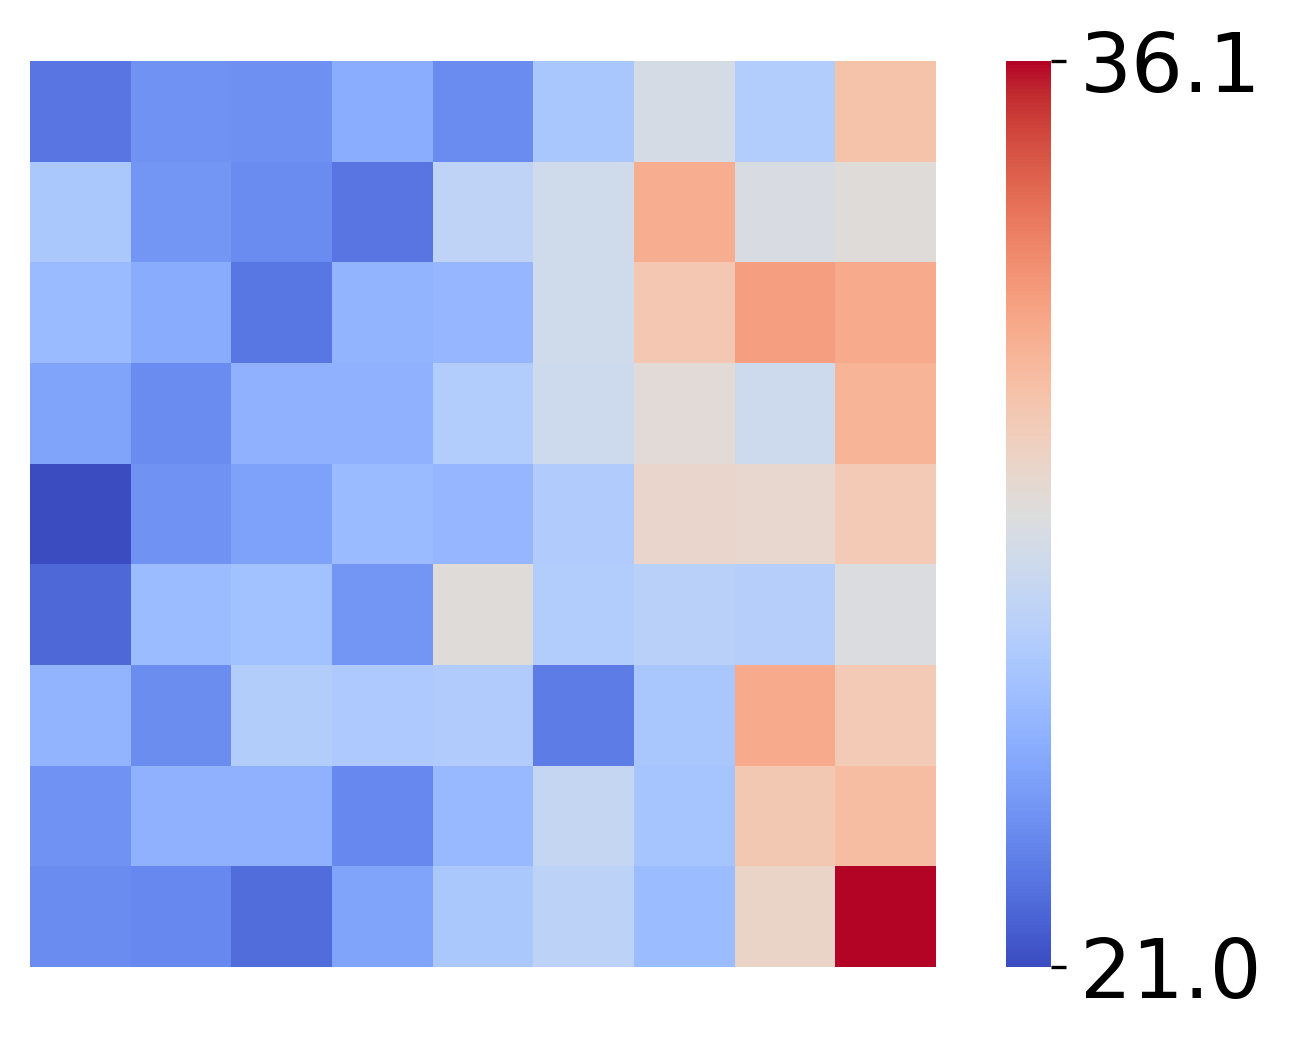

In [36]:
from human_utils_transdiagnostics import plot_td_quantile_analysis_results
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Rewards", col2name="AD", groups = None, num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)

In [37]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_rewards_AD.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_rewards_AD.svg"))

### AD Residual

PC1 loadings:  [-0.99899698 -0.0447777 ]
PC2 loadings:  [ 0.0447777  -0.99899698]
Variance explained by PC1:  0.574419642744996
Variance explained by PC2:  0.42558035725500404
Flipped PC1 to enforce second component to be negative.
[[22.57142857 24.         23.42857143 23.28571429 24.57142857 26.71428571
  29.57142857 25.42857143 30.14285714]
 [26.         23.28571429 23.28571429 23.85714286 25.71428571 27.14285714
  30.14285714 29.28571429 29.14285714]
 [25.33333333 24.66666667 22.5        25.         25.16666667 27.83333333
  30.33333333 32.16666667 31.66666667]
 [23.85714286 23.57142857 24.28571429 25.57142857 27.         26.85714286
  30.85714286 25.71428571 31.14285714]
 [22.83333333 24.83333333 27.5        24.83333333 27.16666667 27.66666667
  25.33333333 28.66666667 29.5       ]
 [20.85714286 24.         23.42857143 23.42857143 26.42857143 26.14285714
  28.14285714 29.         29.14285714]
 [25.         23.33333333 26.5        26.16666667 26.33333333 22.66666667
  26.         31

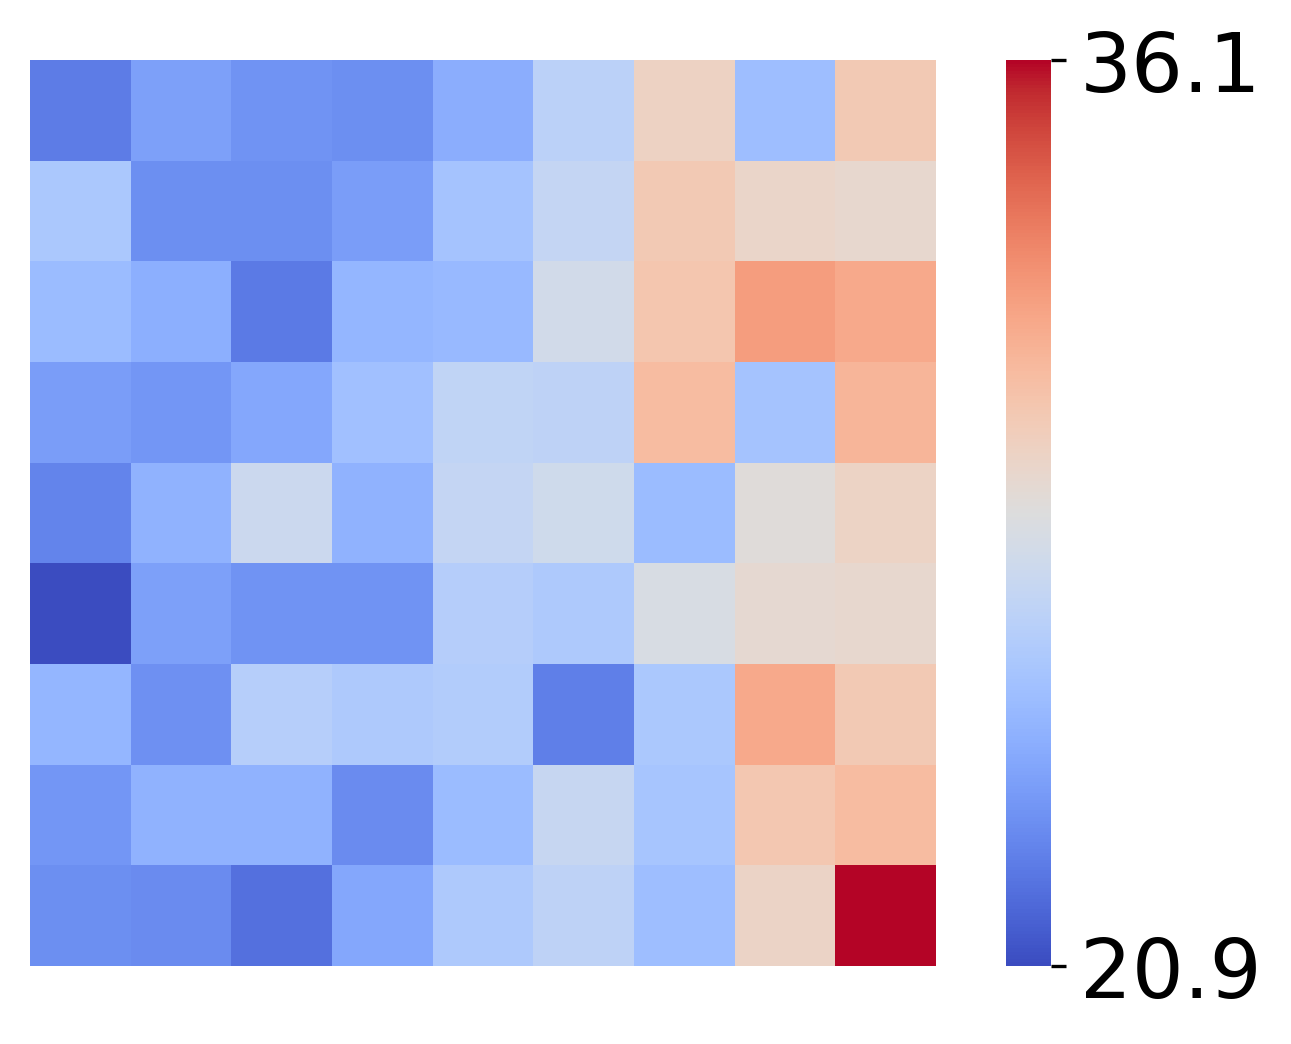

In [38]:
from human_utils_transdiagnostics import plot_td_quantile_analysis_results

quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), get_alternate_TD_representation(df['AD'], df['Compul'], method, np.stack(df['n_observes'].values).sum(axis=1))[0], np.stack(df["effs"].values), "Rewards", col2name="AD", groups = None, num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), df['AD'] - AD_pred, np.stack(df["effs"].values), "Rewards", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)

In [39]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_rewards_AD_residual.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_rewards_AD_residual.svg"))

### Compul

[[26.28571429 24.14285714 23.28571429 22.71428571 25.28571429 24.71428571
  30.         27.42857143 29.14285714]
 [23.57142857 24.         25.14285714 24.         21.         30.
  24.         28.57142857 27.85714286]
 [20.83333333 24.         23.         23.16666667 27.33333333 27.16666667
  31.83333333 31.         33.33333333]
 [24.71428571 23.71428571 27.42857143 23.85714286 26.28571429 24.57142857
  27.57142857 29.85714286 32.        ]
 [22.66666667 23.83333333 23.16666667 25.16666667 26.         28.5
  30.33333333 25.83333333 31.        ]
 [24.         23.71428571 25.71428571 25.14285714 27.42857143 28.28571429
  29.14285714 30.71428571 31.28571429]
 [23.16666667 23.5        23.         24.66666667 27.33333333 26.
  23.83333333 24.83333333 27.        ]
 [24.14285714 25.14285714 23.57142857 26.28571429 28.         26.28571429
  28.28571429 30.         37.14285714]
 [23.         23.42857143 22.57142857 24.14285714 25.42857143 24.14285714
  27.28571429 31.85714286 29.14285714]]


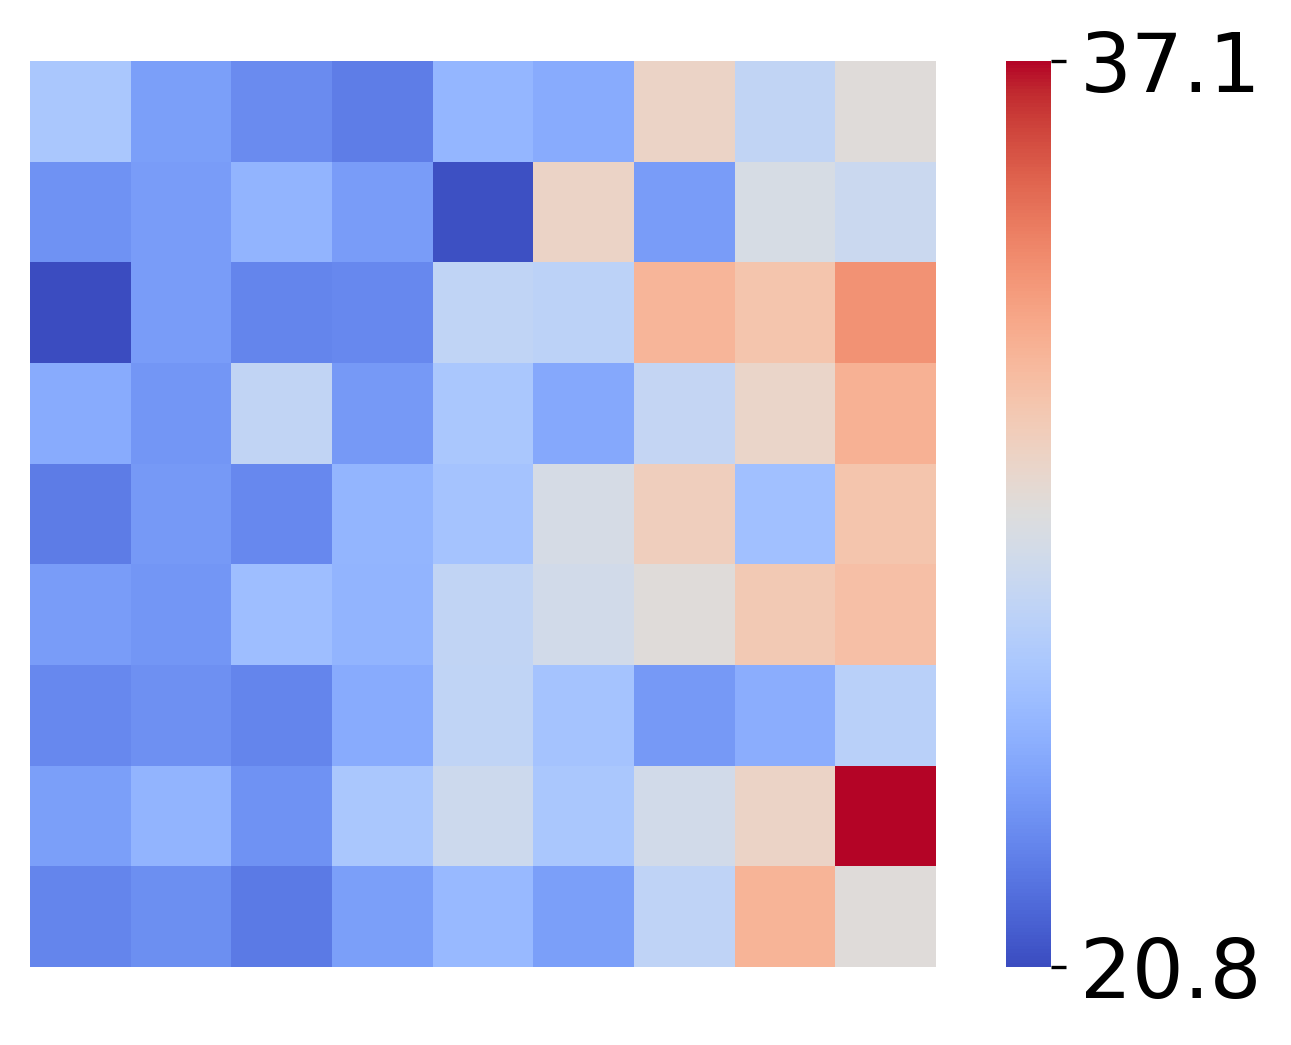

In [40]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Rewards", col2name = "Compul", groups = None, num_bins =9, combine_groups = True, annot=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Rewards", col2name = "Compul", groups = None, num_bins =9, combine_groups = False, annot=False)

In [41]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_rewards_Compul.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_rewards_Compul.svg"))

### Compul Residual

PC1 loadings:  [-0.99899698 -0.0447777 ]
PC2 loadings:  [ 0.0447777  -0.99899698]
Variance explained by PC1:  0.574419642744996
Variance explained by PC2:  0.42558035725500404
Flipped PC1 to enforce second component to be negative.
[[23.         23.42857143 22.57142857 24.14285714 25.42857143 24.14285714
  27.28571429 31.85714286 29.14285714]
 [24.14285714 25.14285714 23.57142857 26.28571429 28.         26.28571429
  28.28571429 30.         37.14285714]
 [23.16666667 23.5        23.         24.66666667 27.33333333 26.
  23.83333333 24.83333333 27.        ]
 [24.         23.71428571 25.71428571 25.14285714 27.42857143 28.28571429
  29.14285714 30.71428571 31.28571429]
 [23.16666667 23.83333333 22.83333333 26.16666667 25.16666667 28.16666667
  30.5        26.33333333 30.83333333]
 [23.28571429 22.28571429 26.57142857 21.85714286 25.42857143 25.28571429
  29.57142857 31.71428571 33.71428571]
 [22.83333333 25.         25.         25.16666667 27.33333333 26.16666667
  27.83333333 28.       

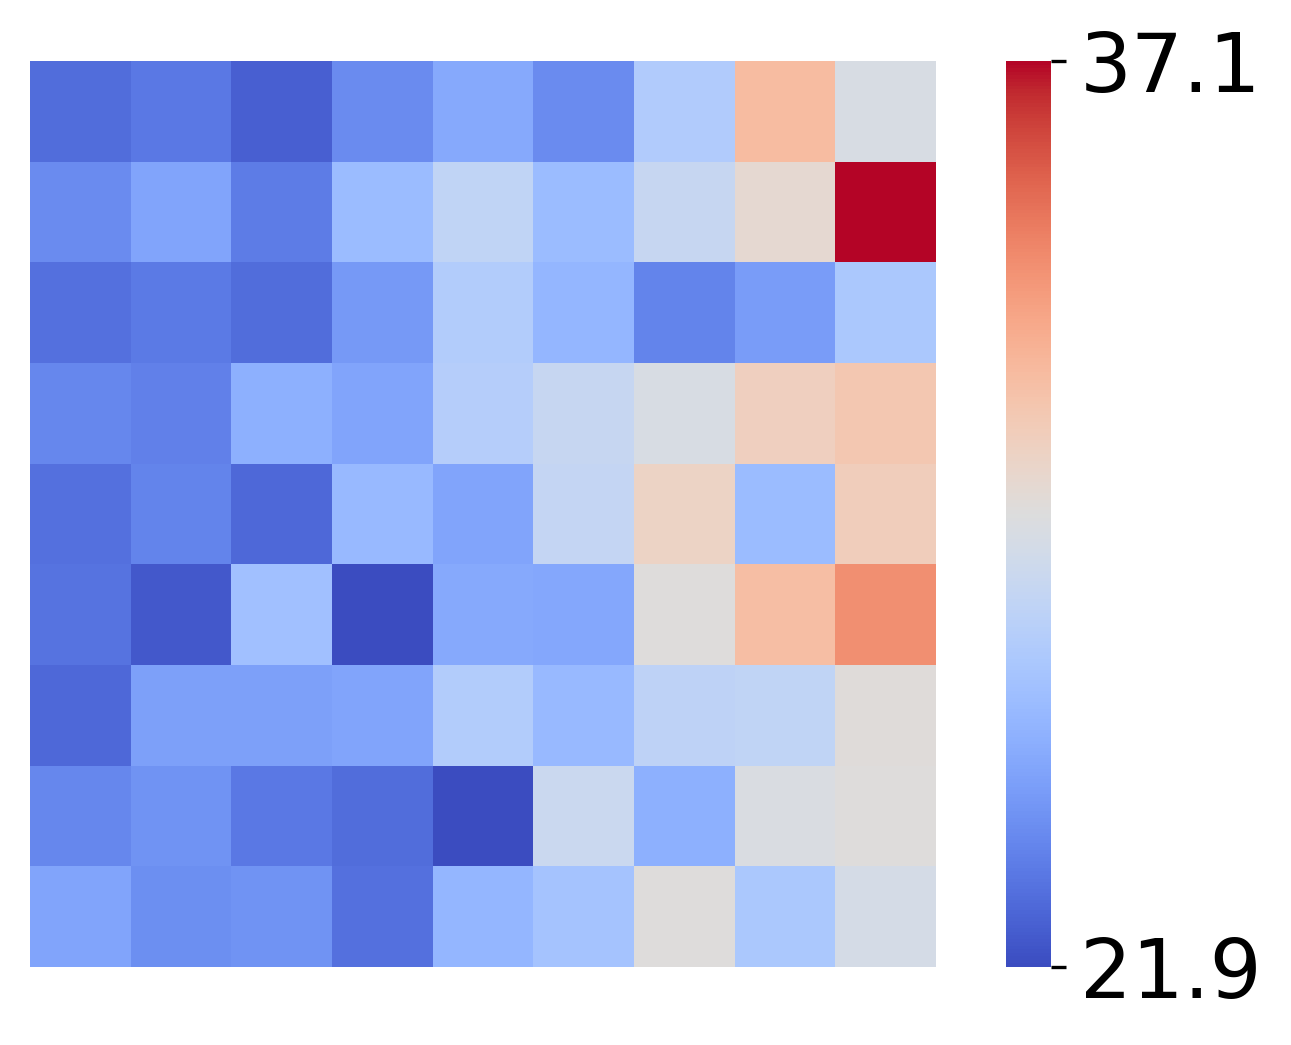

In [42]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), get_alternate_TD_representation(df['AD'], df['Compul'], method, np.stack(df['n_observes'].values).sum(axis=1))[1], np.stack(df["effs"].values), "Rewards", col2name = "Compul", groups = None, num_bins =9, combine_groups = True, annot=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Rewards", col2name = "Compul", groups = None, num_bins =9, combine_groups = False, annot=False)

In [43]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_rewards_Compul_residual.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_rewards_Compul_residual.svg"))

### SW

[[24.         25.14285714 25.28571429 25.57142857 24.57142857 24.14285714
  21.14285714 20.57142857 25.42857143]
 [22.14285714 22.14285714 22.71428571 25.         24.42857143 27.42857143
  30.28571429 30.71428571 33.28571429]
 [22.33333333 25.16666667 24.16666667 25.16666667 25.83333333 26.
  28.33333333 28.         33.66666667]
 [24.42857143 25.57142857 24.85714286 25.85714286 26.85714286 25.14285714
  30.28571429 30.57142857 32.28571429]
 [25.66666667 22.5        23.33333333 21.16666667 25.66666667 25.5
  32.         29.         32.        ]
 [22.14285714 23.         27.         25.28571429 26.42857143 28.42857143
  26.28571429 37.14285714 32.14285714]
 [27.5        25.33333333 23.66666667 21.5        29.33333333 30.33333333
  31.16666667 29.16666667 27.66666667]
 [22.42857143 24.57142857 21.         24.57142857 23.         28.28571429
  26.85714286 26.14285714 28.85714286]
 [23.         22.28571429 25.14285714 24.28571429 28.         24.42857143
  26.71428571 29.42857143 32.85714286

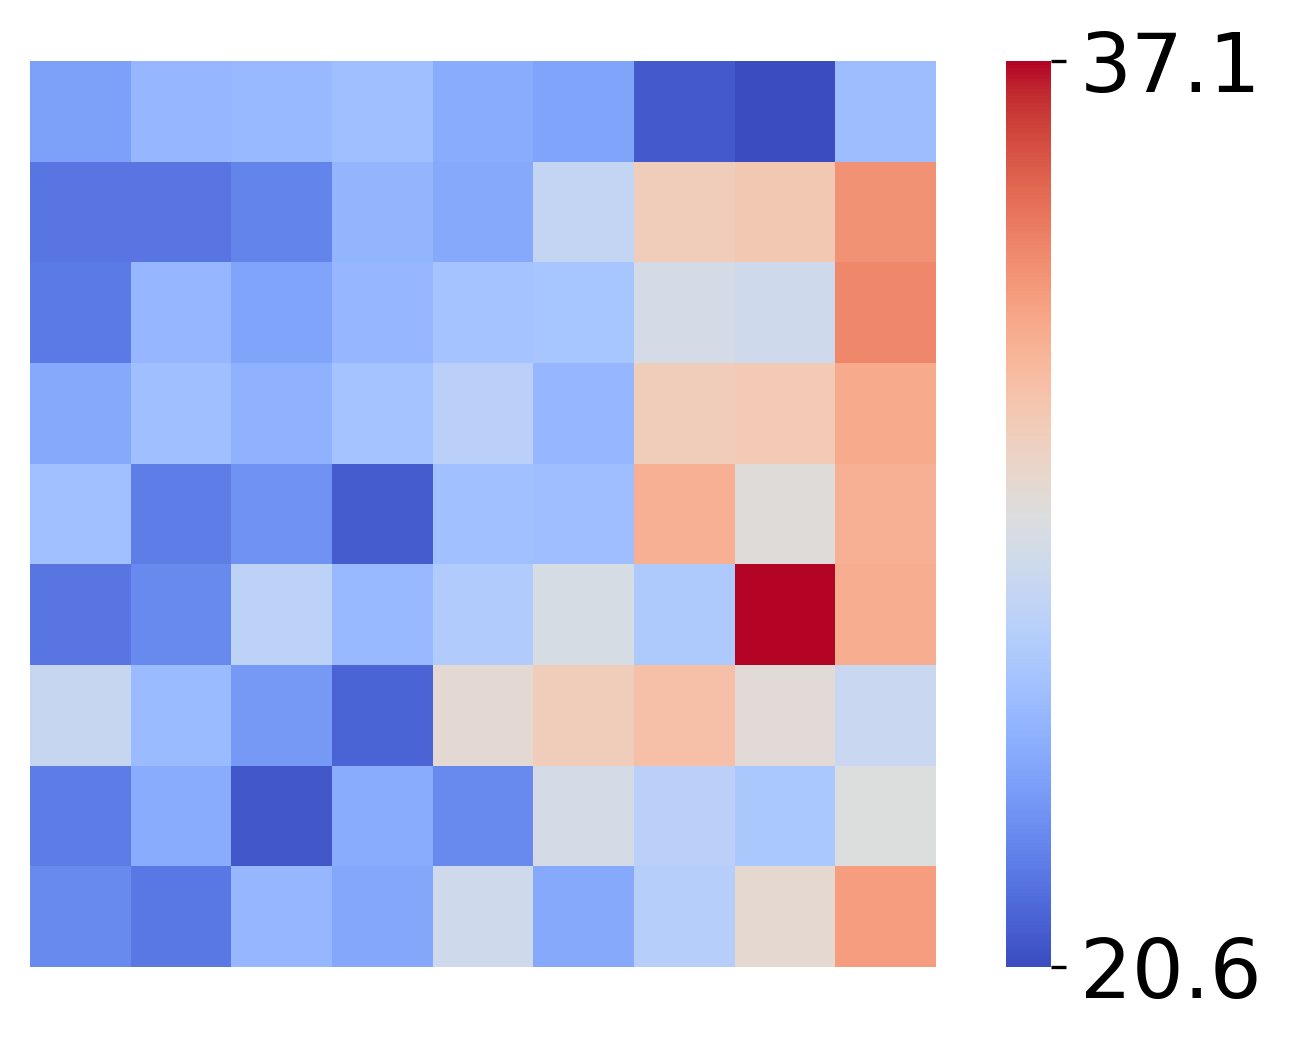

In [44]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), df['SW'], np.stack(df["effs"].values), "Observes", col2name = "SW", groups = None, num_bins =9, combine_groups = True, annot=False, square=square, axes_off=axes_off)

In [45]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_rewards_SW.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_rewards_SW.svg"))

### Trait-level Simulations

In [46]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_anal import pepe_human_ape_models as ape_models
from settings_anal import trait_simulated_participants_folder_t1 as simulated_participants_folder
from settings_anal import trait_sim_timestamp_t1 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)

sim_rewss, sim_obss, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)

## flip to correct for switching from tau to efficacy
sim_obss = np.flip(sim_obss.T,axis=1)
sim_rewss = np.flip(sim_rewss.T, axis=1)

original_mag_perturbation = 1
with open(os.path.join('data', 'sim_perturbed_participants', 'pepe', 'sim', 'mag%d'%(original_mag_perturbation*100), '%s_simulated_participant_perturbations_sim_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

[[24.94582353 24.93676471 25.03235294 25.02276471 25.18758824 25.26894118
  25.64905882 26.38364706 27.67235294]
 [24.85358824 24.89117647 24.95611765 25.05394118 25.27911765 25.64552941
  26.55111765 28.09782353 29.88888235]
 [24.78425    24.788375   24.9821875  25.1943125  25.5800625  26.4461875
  27.862375   29.4446875  30.861125  ]
 [24.68141176 24.71435294 24.91452941 25.17629412 25.79476471 26.86847059
  28.41070588 29.72129412 30.94988235]
 [24.659      24.7496875  24.935125   25.2566875  26.0315     27.1594375
  28.501      29.76675    30.969625  ]
 [24.55694118 24.67247059 24.83658824 25.34711765 26.21482353 27.37564706
  28.51035294 29.75129412 31.02635294]
 [24.489875   24.536375   24.778875   25.275125   26.2945     27.372125
  28.5709375  29.6965     30.947     ]
 [23.99611765 24.05635294 24.49594118 25.18070588 26.18347059 27.29494118
  28.42776471 29.60917647 30.80223529]
 [22.64935294 23.12429412 23.834      24.83817647 25.89464706 26.93047059
  28.04082353 29.16711765 

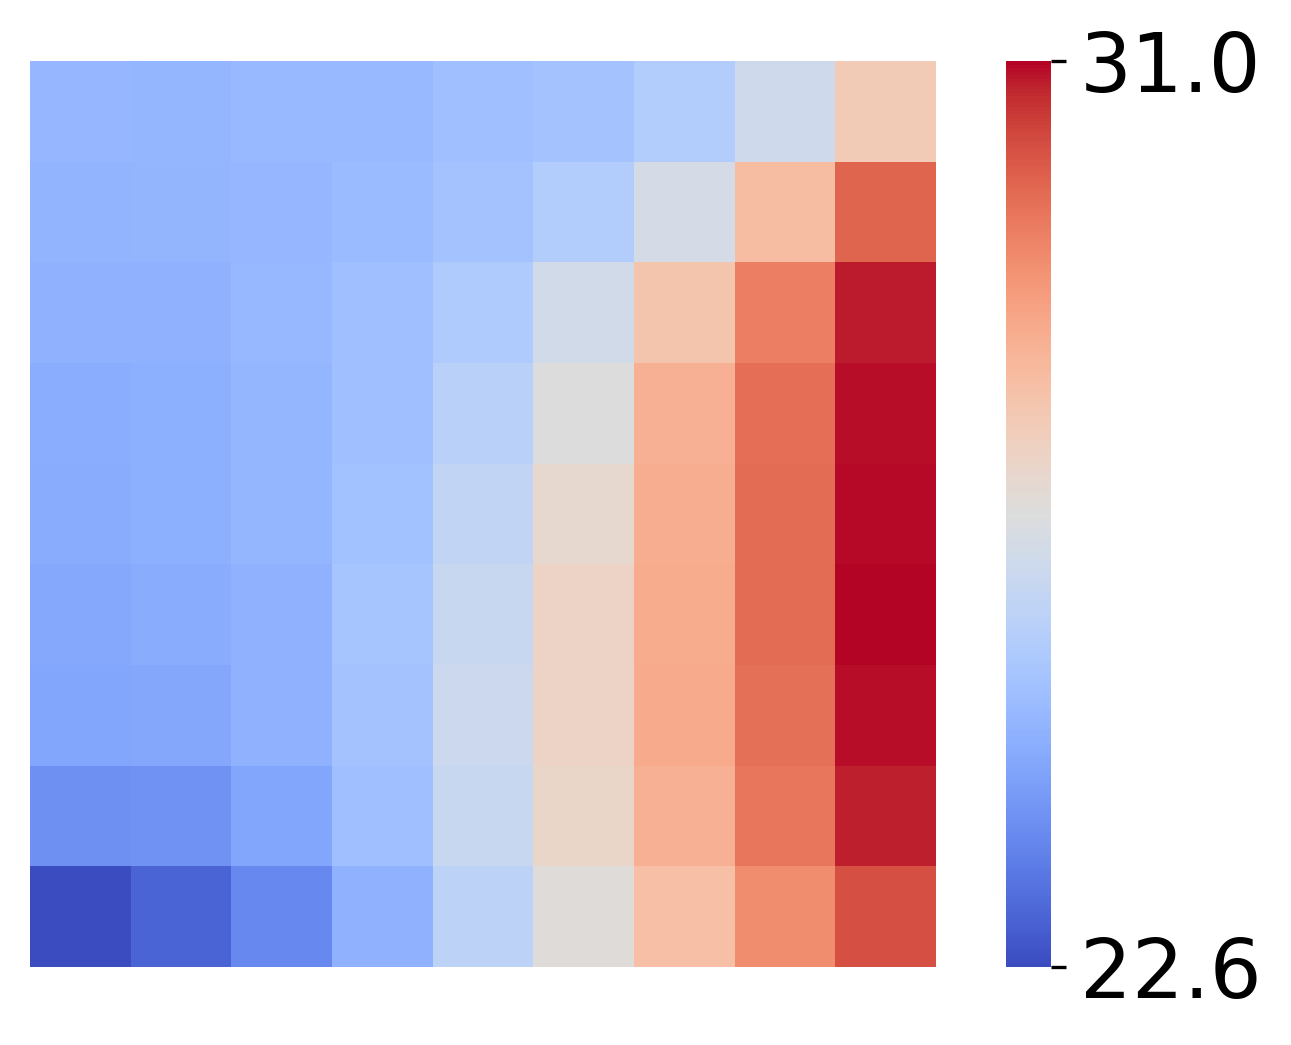

In [47]:
quantile_fig = plot_td_quantile_analysis_results(sim_rewss, sim_participant_perturbations, effs, "Rewards", col2name = "Belief", groups = None, num_bins =9, annot=False, square=square, axes_off=axes_off)

In [48]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_rewards_NN.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_rewards_NN.svg"))

### Permuted Simulations

In [49]:
from human_utils_behavioral_analysis import load_simulated_participants_across_models
from settings_anal import pepe_human_ape_models as ape_models
#from settings_anal import trait_simulated_participants_folder_t1 as simulated_participants_folder
from settings_anal import zeros_simulated_participants_folder_t1 as simulated_participants_folder
from settings_anal import zeros_sim_timestamp_t1 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)

sim_rewss, sim_obss, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)

## flip to correct for switching from tau to efficacy
sim_obss = np.flip(sim_obss.T,axis=1)
sim_rewss = np.flip(sim_rewss.T, axis=1)

original_mag_perturbation = 1
with open(os.path.join('data', 'sim_perturbed_participants', 'pepe', 'nostruc', 'mag%d'%(original_mag_perturbation*100), '%s_simulated_participant_perturbations_nostruc_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy


[[24.69637333 24.77618    24.9282     25.22768    25.89856    27.07694
  28.43838    29.73052    30.98757333]
 [24.69637333 24.77618    24.9282     25.22768    25.89856    27.07694
  28.43838    29.73052    30.98757333]
 [24.69637333 24.77618    24.9282     25.22768    25.89856    27.07694
  28.43838    29.73052    30.98757333]
 [24.69637333 24.77618    24.9282     25.22768    25.89856    27.07694
  28.43838    29.73052    30.98757333]
 [24.69637333 24.77618    24.9282     25.22768    25.89856    27.07694
  28.43838    29.73052    30.98757333]
 [24.69637333 24.77618    24.9282     25.22768    25.89856    27.07694
  28.43838    29.73052    30.98757333]
 [24.69637333 24.77618    24.9282     25.22768    25.89856    27.07694
  28.43838    29.73052    30.98757333]
 [24.69637333 24.77618    24.9282     25.22768    25.89856    27.07694
  28.43838    29.73052    30.98757333]
 [24.69637333 24.77618    24.9282     25.22768    25.89856    27.07694
  28.43838    29.73052    30.98757333]]


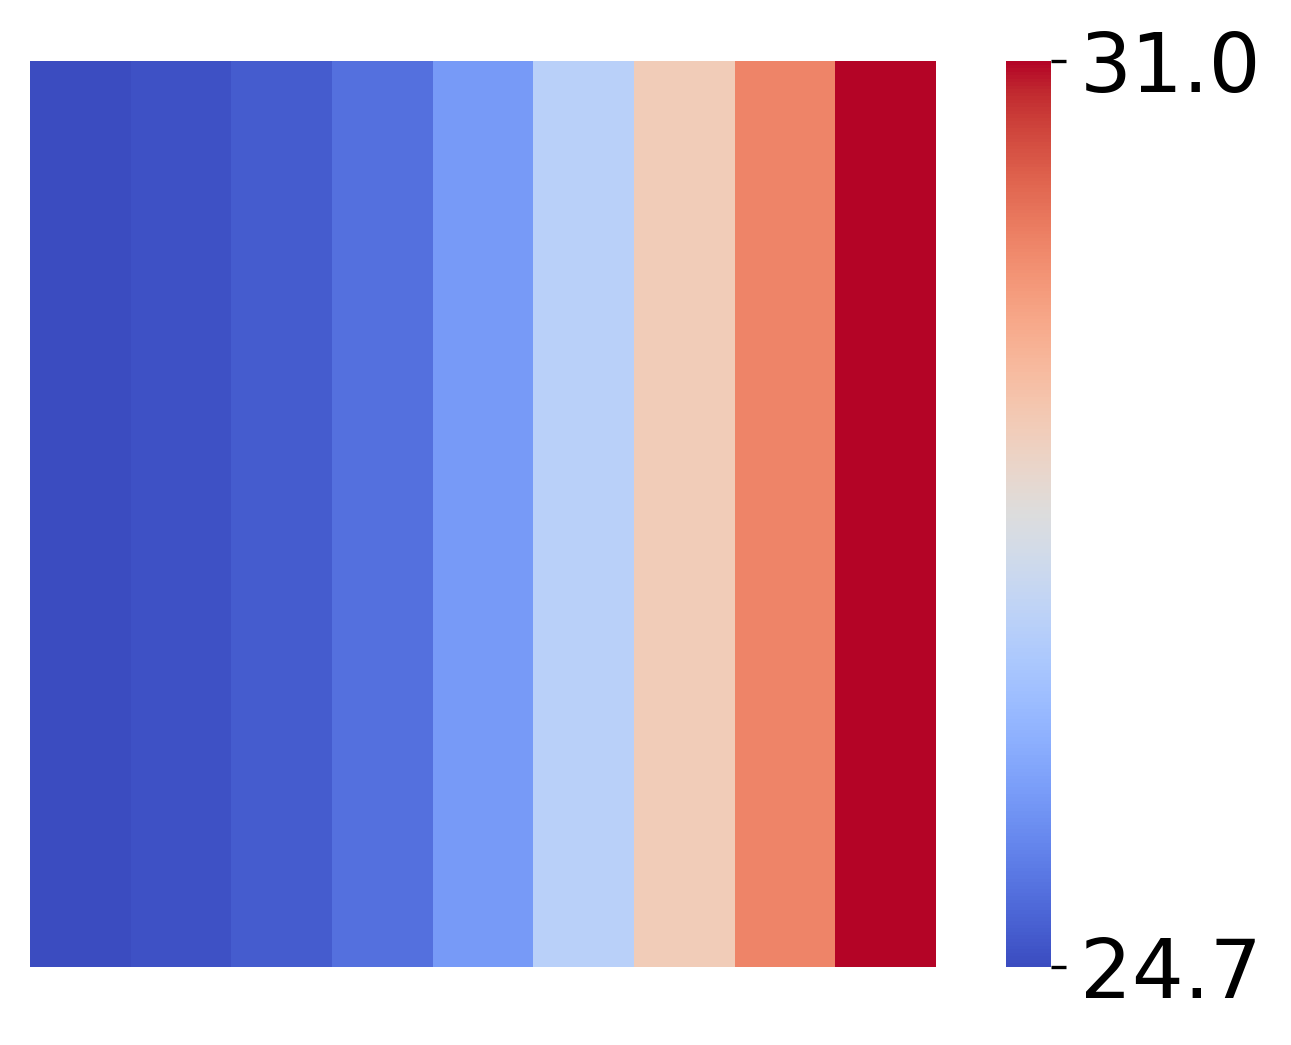

In [50]:
quantile_fig = plot_td_quantile_analysis_results(sim_rewss, sim_participant_perturbations, effs, "Reserves", col2name = "Belief", groups = None, num_bins =9, annot=False, square=square, axes_off=axes_off)

In [51]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_rewards_NN_permuted.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_rewards_NN_permuted.svg"))

## Panel B.2: Task 1 Estimates
### AD

In [52]:
mask = 'nomask'
iday = 2
day = 'day%d' %iday
with_nets = False
include_sleep = False
include_estimates = False
group = None

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)


/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/human_utils_project.py:1281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_day3['group'] = False


[[0.16857143 0.21714286 0.37714286 0.38       0.36285714 0.54571429
  0.64571429 0.81714286 0.77428571]
 [0.16857143 0.14285714 0.30571429 0.56857143 0.61428571 0.79142857
  0.82       0.86       0.95428571]
 [0.29       0.18666667 0.39666667 0.37       0.32666667 0.48
  0.64333333 0.73333333 0.83333333]
 [0.28285714 0.11428571 0.24285714 0.30285714 0.51714286 0.65428571
  0.72571429 0.8        0.81428571]
 [0.14666667 0.11333333 0.20333333 0.43       0.40333333 0.73
  0.63333333 0.70333333 0.79      ]
 [0.10857143 0.16857143 0.33428571 0.29428571 0.51142857 0.63142857
  0.68285714 0.78571429 0.96857143]
 [0.16       0.18       0.4        0.24666667 0.41666667 0.38666667
  0.64333333 0.68       0.69333333]
 [0.23428571 0.13428571 0.24       0.31142857 0.35142857 0.56
  0.83142857 0.82285714 0.94571429]
 [0.16857143 0.18       0.32857143 0.35428571 0.54857143 0.63428571
  0.72571429 0.83714286 0.86857143]]


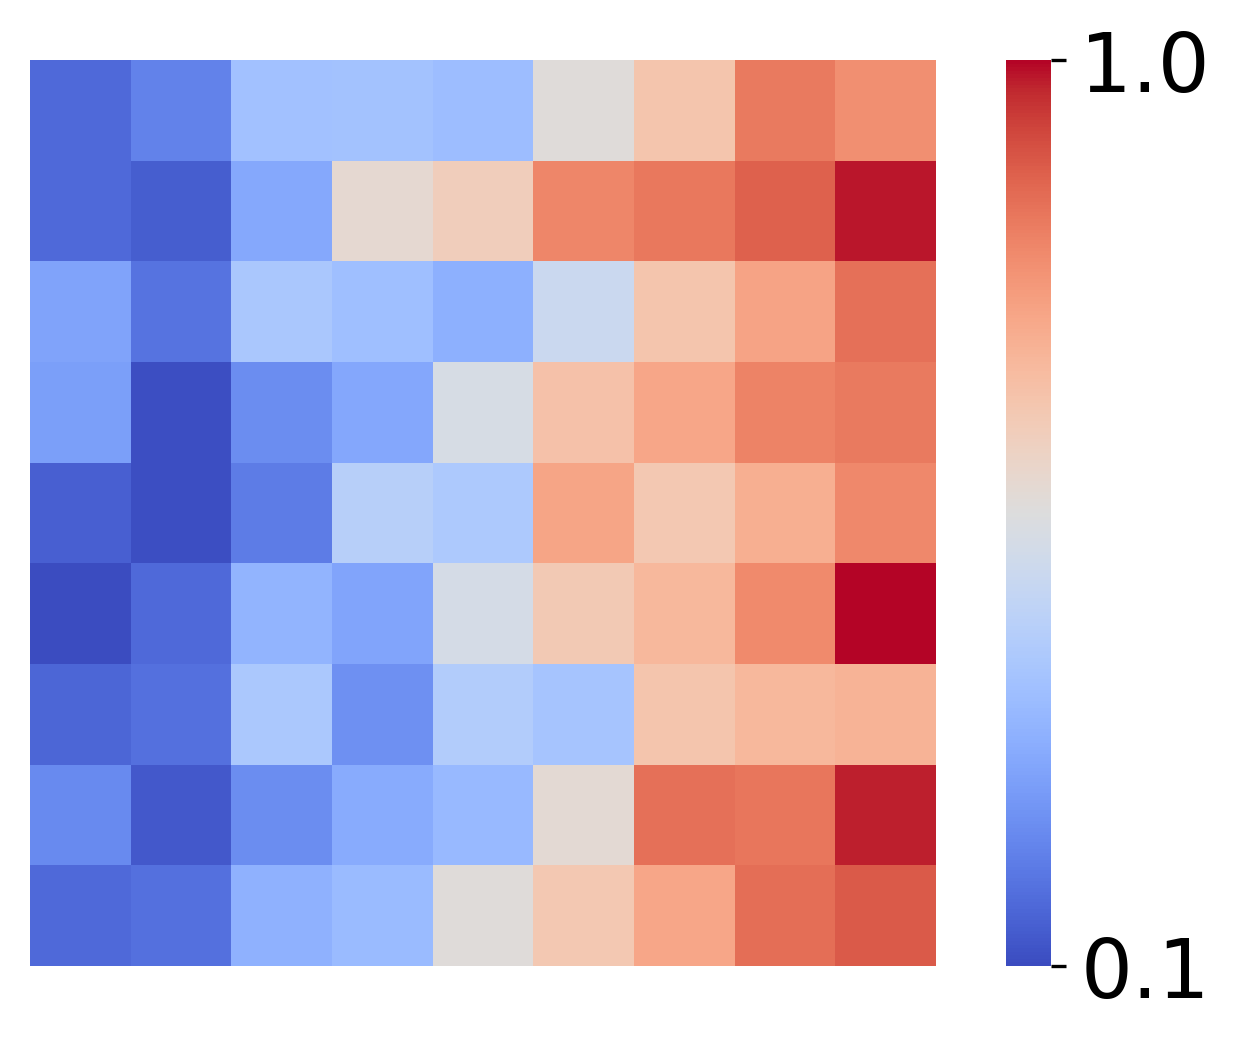

In [53]:
from human_utils_transdiagnostics import plot_td_quantile_analysis_results

quantile_fig = plot_td_quantile_analysis_results(np.stack(df['efficacy_estimates'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Observes", col2name="AD", groups = None, num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)


In [54]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_estimates_AD.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_estimates_AD.svg"))

### AD Residual

PC1 loadings:  [-0.99899698 -0.0447777 ]
PC2 loadings:  [ 0.0447777  -0.99899698]
Variance explained by PC1:  0.574419642744996
Variance explained by PC2:  0.42558035725500404
Flipped PC1 to enforce second component to be negative.
[[0.19428571 0.19428571 0.34571429 0.38857143 0.40285714 0.52857143
  0.66       0.83428571 0.82857143]
 [0.14285714 0.16571429 0.33714286 0.56       0.57428571 0.80857143
  0.80571429 0.84285714 0.9       ]
 [0.29       0.18666667 0.39666667 0.37       0.32666667 0.48
  0.64333333 0.73333333 0.83333333]
 [0.25142857 0.11428571 0.19142857 0.32285714 0.48857143 0.65428571
  0.75714286 0.76       0.89714286]
 [0.23666667 0.17333333 0.27333333 0.47666667 0.45666667 0.72333333
  0.56666667 0.65333333 0.69333333]
 [0.06285714 0.11714286 0.32571429 0.23428571 0.49428571 0.63714286
  0.70857143 0.86857143 0.96857143]
 [0.16       0.18       0.4        0.24666667 0.41666667 0.38666667
  0.64333333 0.68       0.69333333]
 [0.23428571 0.13428571 0.24       0.31142857 

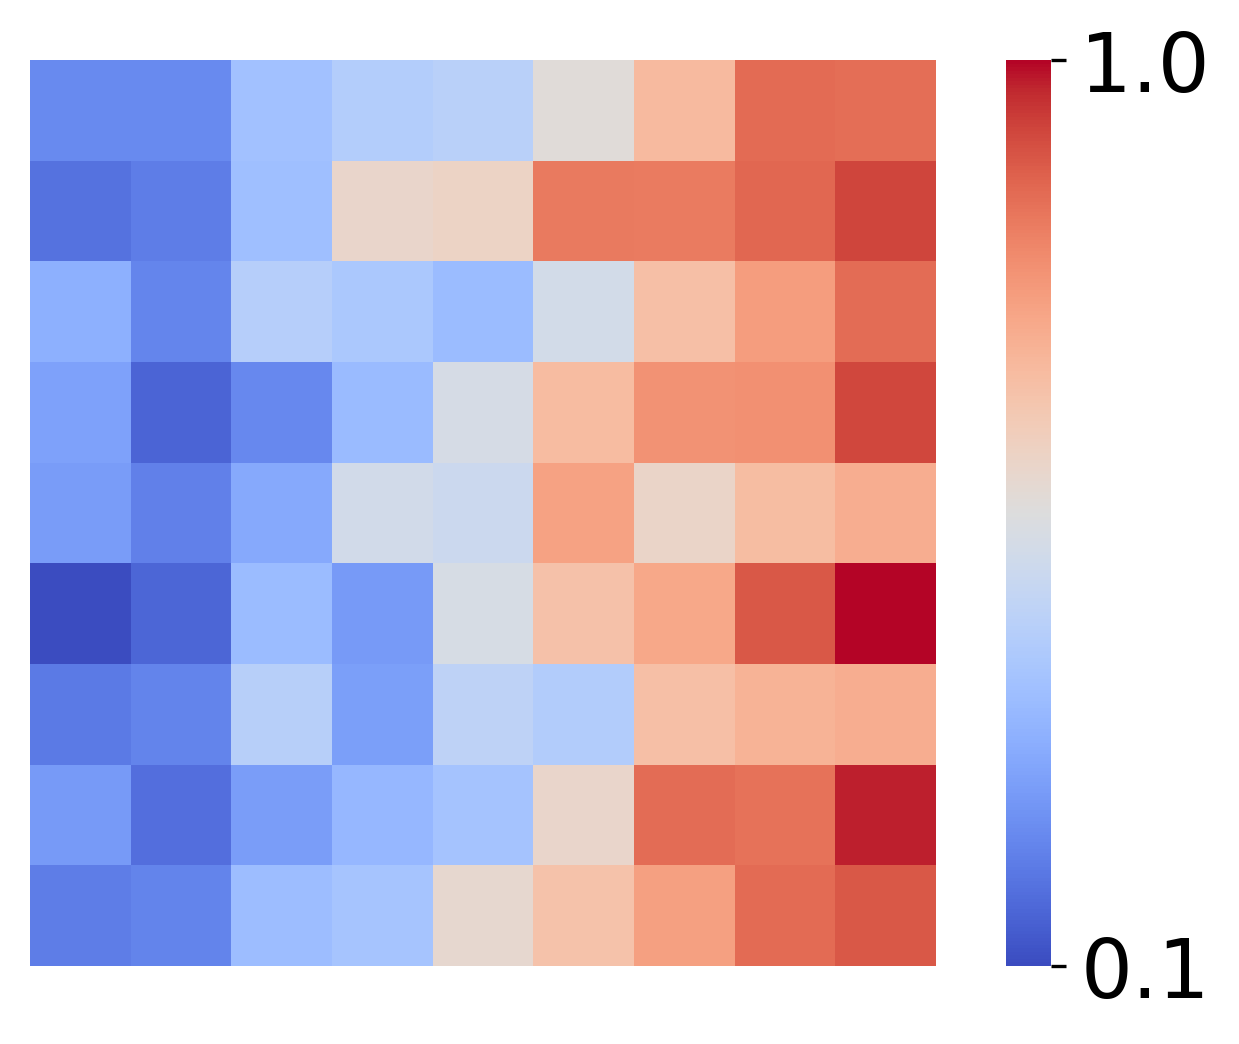

In [55]:
from human_utils_transdiagnostics import plot_td_quantile_analysis_results

quantile_fig = plot_td_quantile_analysis_results(np.stack(df['efficacy_estimates'].values).squeeze(), get_alternate_TD_representation(df['AD'], df['Compul'], method, np.stack(df['n_observes'].values).sum(axis=1))[0], np.stack(df["effs"].values), "Observes", col2name="AD", groups = None, num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['efficacy_estimates'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Observes", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_resultstack(df['efficacy_estimates'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Observes", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=True, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Observes", col2name="AD", groups = df["group"], num_bins=9, combine_groups = False, annot=False, flip_leastmost=True)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Observes", col2name="AD", groups = None, num_bins=9, combine_groups = False, annot=False, flip_leastmost=True)

In [56]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_estimates_AD_residual.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_estimates_AD_residual.svg"))

### Compul

[[0.22285714 0.24285714 0.29428571 0.38857143 0.49714286 0.68571429
  0.73714286 0.88571429 0.87714286]
 [0.13428571 0.24       0.36857143 0.28285714 0.46285714 0.55428571
  0.78       0.78571429 0.88285714]
 [0.08       0.06666667 0.35333333 0.30333333 0.42666667 0.66
  0.84333333 0.80666667 0.98333333]
 [0.16       0.16285714 0.33428571 0.44857143 0.42571429 0.59142857
  0.69428571 0.65714286 0.85142857]
 [0.30333333 0.16666667 0.28       0.27666667 0.47333333 0.59666667
  0.59       0.84       0.9       ]
 [0.18285714 0.04285714 0.28285714 0.28571429 0.43142857 0.64285714
  0.70285714 0.91142857 0.88      ]
 [0.23       0.22       0.25666667 0.48666667 0.49333333 0.68
  0.72       0.75666667 0.81      ]
 [0.21142857 0.15714286 0.38       0.45142857 0.47142857 0.50857143
  0.81714286 0.87428571 0.98857143]
 [0.20571429 0.13428571 0.26285714 0.33714286 0.40571429 0.54285714
  0.5        0.56285714 0.52285714]]


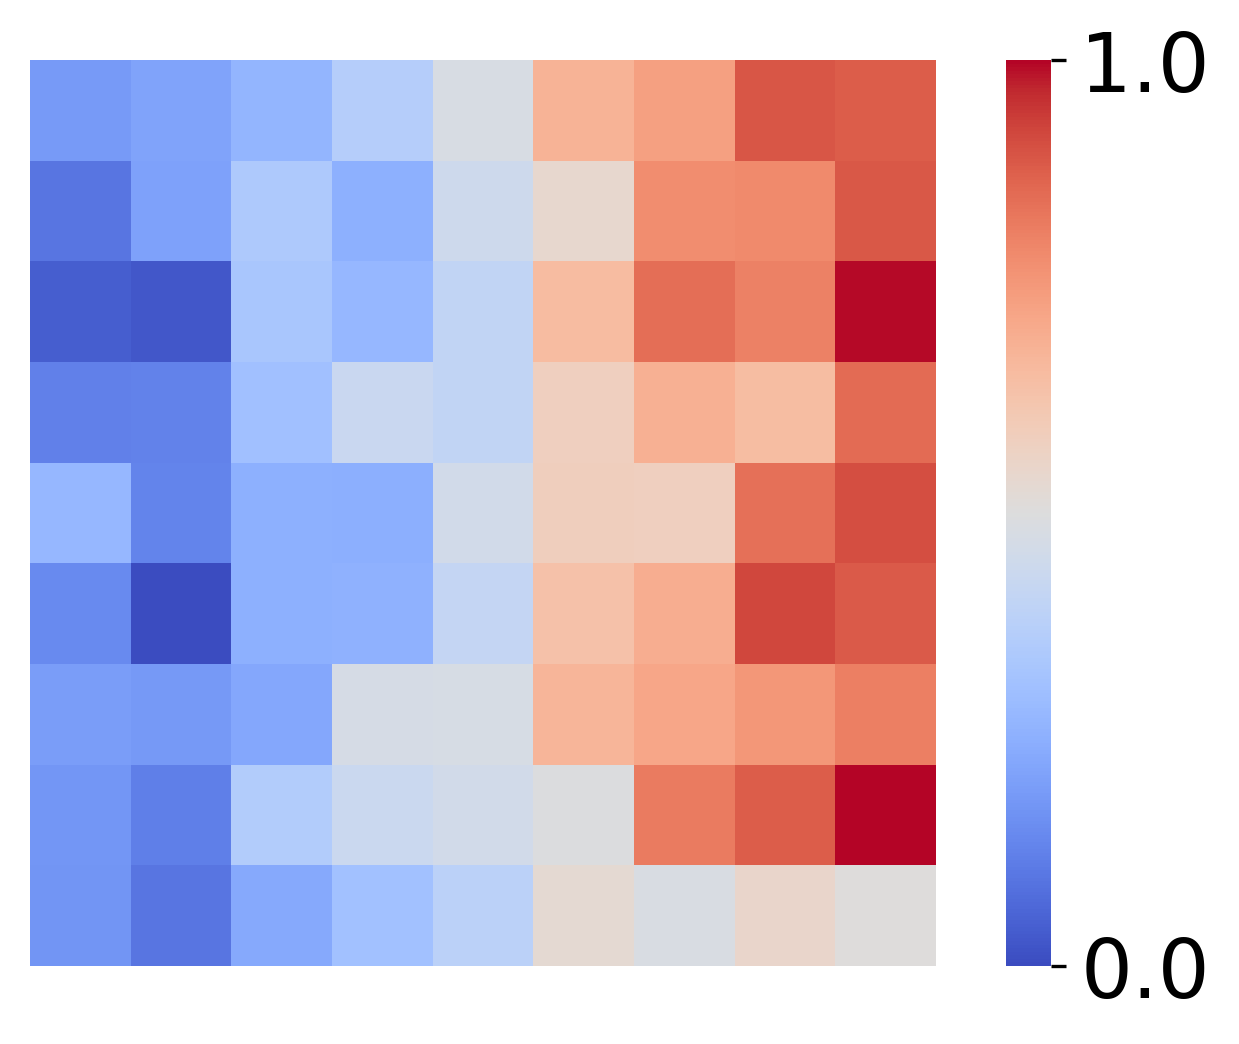

In [57]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['efficacy_estimates'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Observes", col2name = "Compul", groups = None, num_bins =9, combine_groups = True, annot=False , square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Observes", col2name = "Compul", groups = df["group"], num_bins =9, combine_groups = False, annot=False)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Observes", col2name = "Compul", groups = None, num_bins =9, combine_groups = False, annot=False)

In [58]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_estimates_Compul.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_estimates_Compul.svg"))

### Compul Residual

PC1 loadings:  [-0.99899698 -0.0447777 ]
PC2 loadings:  [ 0.0447777  -0.99899698]
Variance explained by PC1:  0.574419642744996
Variance explained by PC2:  0.42558035725500404
Flipped PC1 to enforce second component to be negative.
[[0.20571429 0.13428571 0.26285714 0.33714286 0.40571429 0.54285714
  0.5        0.56285714 0.52285714]
 [0.21142857 0.15714286 0.38       0.45142857 0.47142857 0.50857143
  0.81714286 0.87428571 0.98857143]
 [0.23       0.22       0.25666667 0.48666667 0.49333333 0.68
  0.72       0.75666667 0.81      ]
 [0.18285714 0.04285714 0.28285714 0.28571429 0.43142857 0.64285714
  0.70285714 0.91142857 0.88      ]
 [0.29666667 0.21       0.28       0.25666667 0.42       0.48333333
  0.59333333 0.79       0.86      ]
 [0.09714286 0.07142857 0.35714286 0.42       0.45714286 0.64571429
  0.71714286 0.76285714 0.88571429]
 [0.27666667 0.18       0.39       0.42333333 0.47666667 0.73
  0.83666667 0.68666667 0.95333333]
 [0.06571429 0.20285714 0.25142857 0.24285714 0.4828

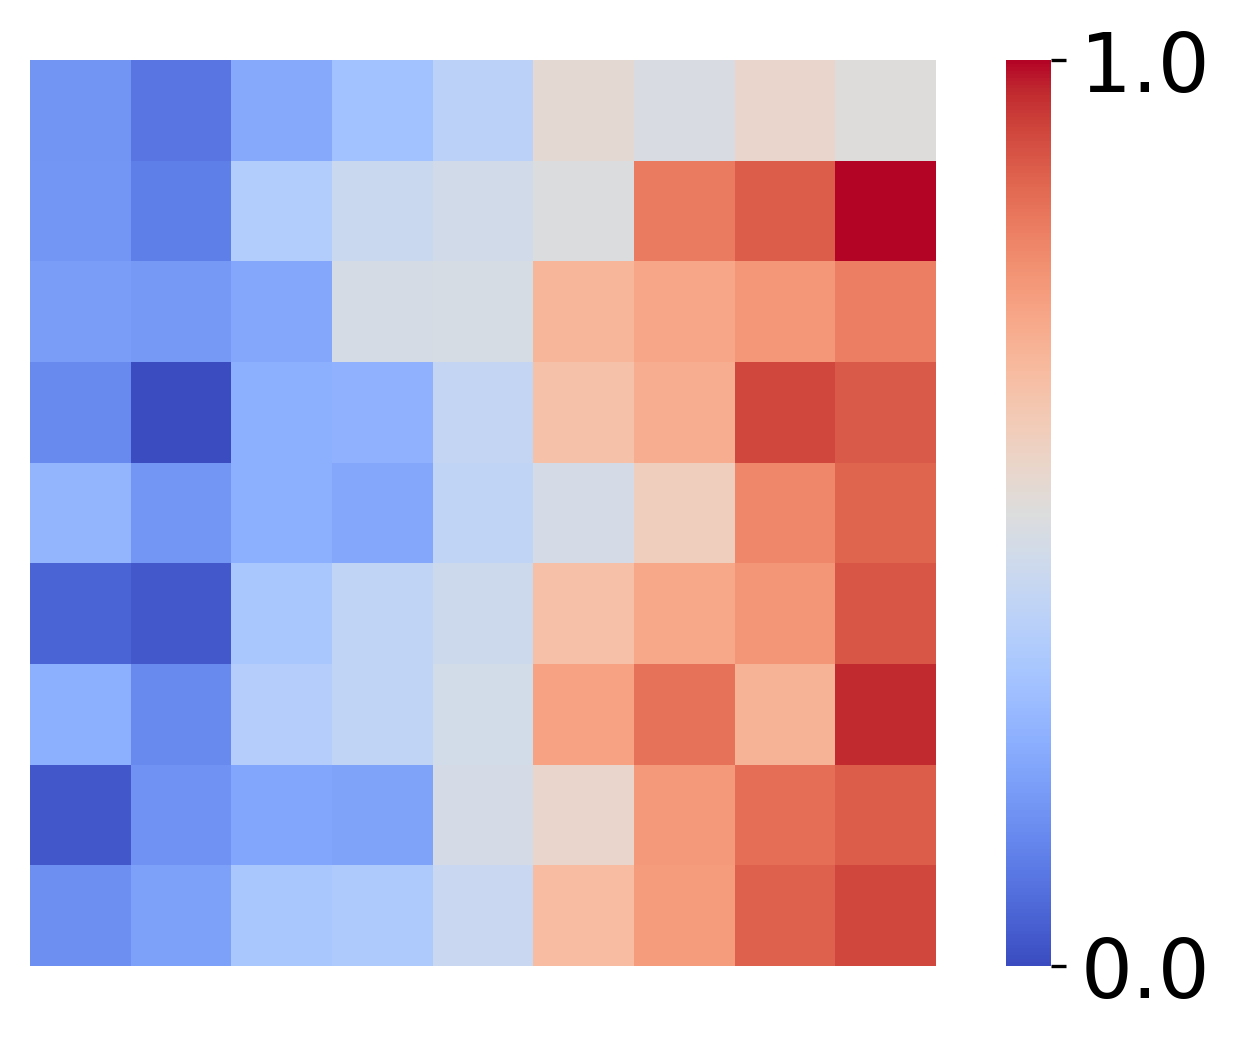

In [59]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['efficacy_estimates'].values).squeeze(), get_alternate_TD_representation(df['AD'], df['Compul'], method, np.stack(df['n_observes'].values).sum(axis=1))[1], np.stack(df["effs"].values), "Observes", col2name = "Compul", groups = None, num_bins =9, combine_groups = True, annot=False , square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Observes", col2name = "Compul", groups = df["group"], num_bins =9, combine_groups = False, annot=False)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Observes", col2name = "Compul", groups = None, num_bins =9, combine_groups = False, annot=False)

In [60]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_estimates_Compul_residual.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_estimates_Compul_residual.svg"))

### SW

[[0.27714286 0.28857143 0.41714286 0.36571429 0.48285714 0.58857143
  0.61714286 0.7        0.79142857]
 [0.08571429 0.13142857 0.36571429 0.50857143 0.44       0.66
  0.79428571 0.82       0.88      ]
 [0.08333333 0.07666667 0.19333333 0.32       0.19333333 0.53666667
  0.62       0.72       0.87      ]
 [0.22       0.19714286 0.30285714 0.47142857 0.57142857 0.60857143
  0.83142857 0.84571429 0.91142857]
 [0.25       0.15       0.28666667 0.27333333 0.59       0.71
  0.64666667 0.75       0.82      ]
 [0.09428571 0.03714286 0.25142857 0.28571429 0.23428571 0.44285714
  0.67142857 0.74       0.77142857]
 [0.19333333 0.08333333 0.29666667 0.44333333 0.49333333 0.69333333
  0.78333333 0.80666667 0.89666667]
 [0.33428571 0.20571429 0.37142857 0.18       0.54571429 0.65714286
  0.74857143 0.89142857 0.90571429]
 [0.18       0.24285714 0.31142857 0.40857143 0.52       0.56571429
  0.65714286 0.78857143 0.83428571]]


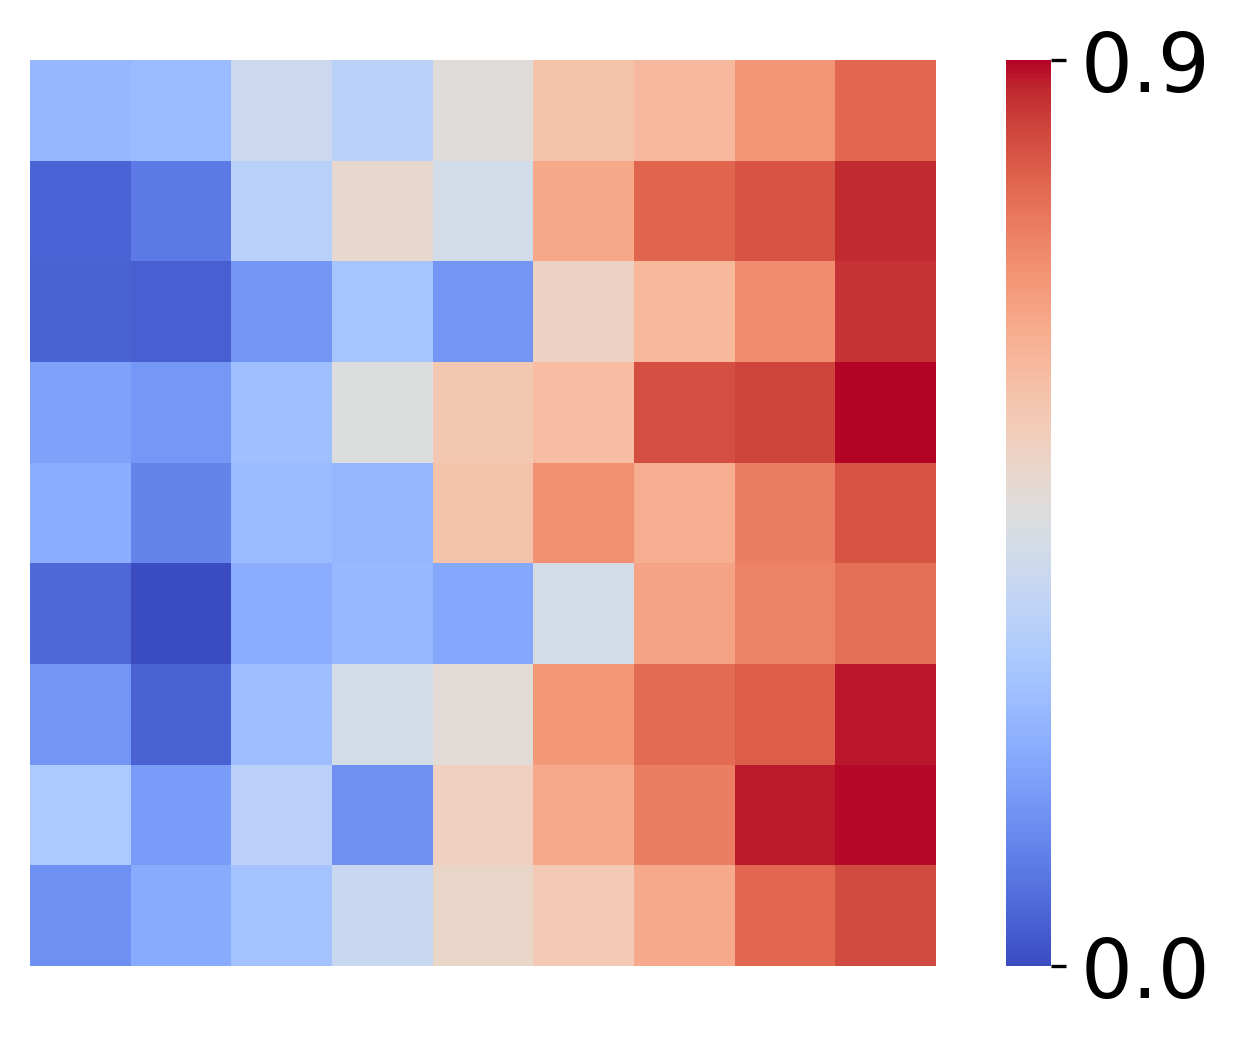

In [61]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['efficacy_estimates'].values).squeeze(), df['SW'], np.stack(df["effs"].values), "Observes", col2name = "SW", groups = None, num_bins =9, combine_groups = True, annot=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['SW'], np.stack(df["effs"].values), "Observes", col2name = "SW", groups = None, num_bins =9, combine_groups = False, annot=False)

In [62]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_estimates_SW.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_estimates_SW.svg"))

### Trait-level Simulations

In [63]:
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_anal import pepe_human_ape_models as ape_models
from settings_anal import trait_simulated_participants_folder_t1 as simulated_participants_folder
from settings_anal import trait_sim_timestamp_t1 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)

sim_rewss, sim_obss, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)

## flip to correct for switching from tau to efficacy
sim_obss = np.flip(sim_obss.T,axis=1)
sim_rewss = np.flip(sim_rewss.T, axis=1)

original_mag_perturbation = 1
with open(os.path.join('data', 'sim_perturbed_participants', 'pepe', 'sim', 'mag%d'%(original_mag_perturbation*100), '%s_simulated_participant_perturbations_sim_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

### CONSTRUCT SIM_ESTS
sim_estss = (np.tile(np.arange(0, 1.01, 0.125), (len(sim_participant_perturbations),1)).T + sim_participant_perturbations).T

In [64]:
print(sim_estss.shape)

(150, 9)


[[-1.49811700e+00 -1.37311700e+00 -1.24811700e+00 -1.12311700e+00
  -9.98116997e-01 -8.73116997e-01 -7.48116997e-01 -6.23116997e-01
  -4.98116997e-01]
 [-8.75884021e-01 -7.50884021e-01 -6.25884021e-01 -5.00884021e-01
  -3.75884021e-01 -2.50884021e-01 -1.25884021e-01 -8.84021437e-04
   1.24115979e-01]
 [-3.68295907e-01 -2.43295907e-01 -1.18295907e-01  6.70409255e-03
   1.31704093e-01  2.56704093e-01  3.81704093e-01  5.06704093e-01
   6.31704093e-01]
 [-1.16213872e-01  8.78612833e-03  1.33786128e-01  2.58786128e-01
   3.83786128e-01  5.08786128e-01  6.33786128e-01  7.58786128e-01
   8.83786128e-01]
 [ 8.28346463e-02  2.07834646e-01  3.32834646e-01  4.57834646e-01
   5.82834646e-01  7.07834646e-01  8.32834646e-01  9.57834646e-01
   1.08283465e+00]
 [ 3.10472949e-01  4.35472949e-01  5.60472949e-01  6.85472949e-01
   8.10472949e-01  9.35472949e-01  1.06047295e+00  1.18547295e+00
   1.31047295e+00]
 [ 5.36506848e-01  6.61506848e-01  7.86506848e-01  9.11506848e-01
   1.03650685e+00  1.1615068

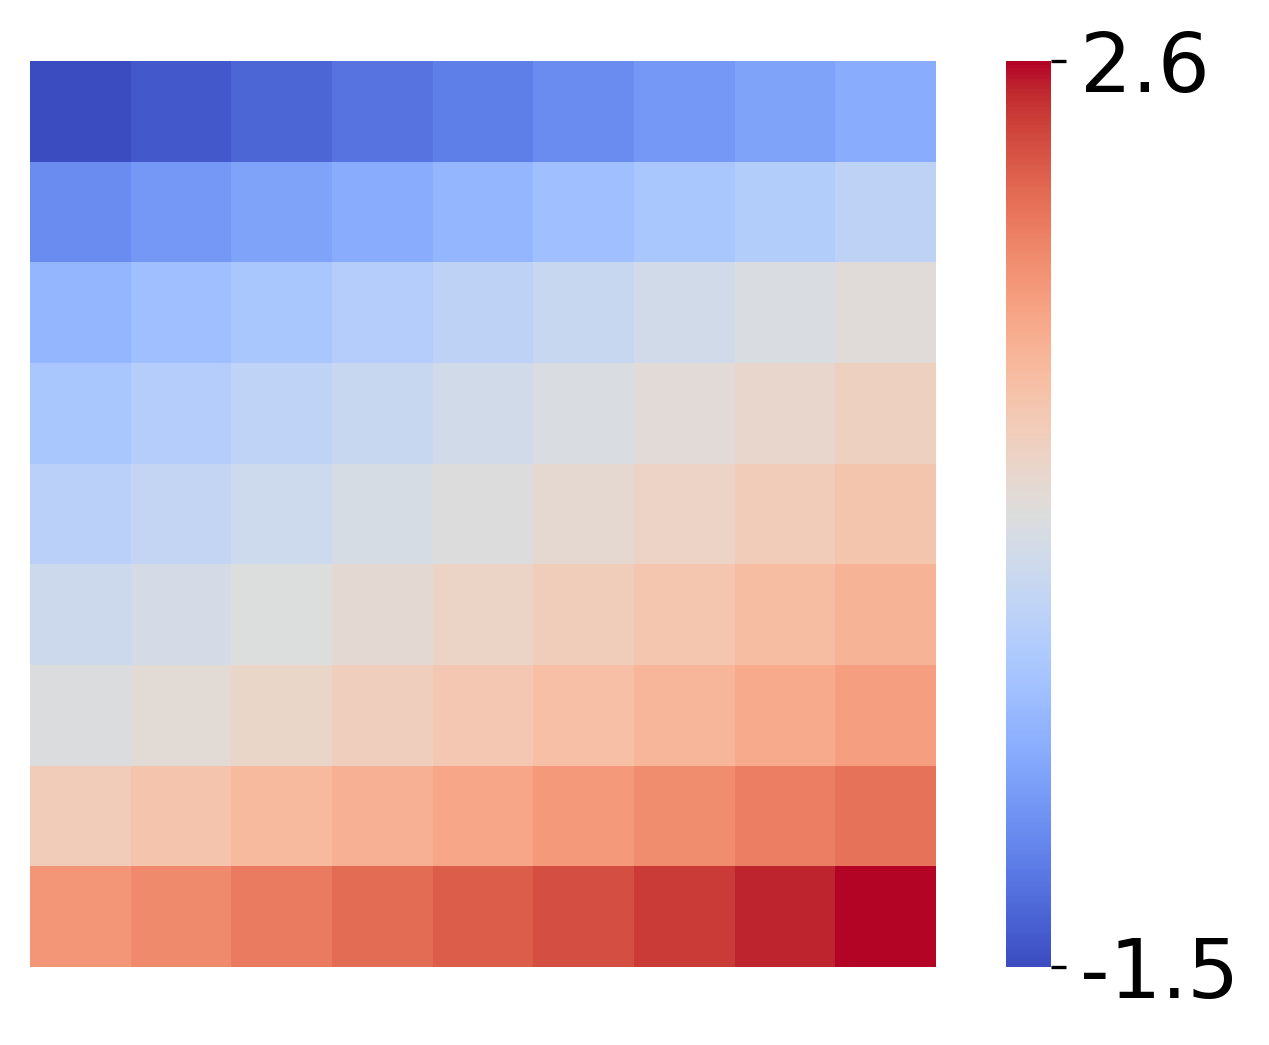

In [65]:
quantile_fig = plot_td_quantile_analysis_results(sim_estss, sim_participant_perturbations, effs, "Rewards", col2name = "Belief", groups = None, num_bins =9, annot=False, square=square, axes_off=axes_off)

In [66]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_estimates_NN.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_estimates_NN.svg"))

### Permuted Simulations

In [67]:
from human_utils_behavioral_analysis import load_simulated_participants_across_models
from settings_anal import pepe_human_ape_models as ape_models
#from settings_anal import trait_simulated_participants_folder_t1 as simulated_participants_folder
from settings_anal import zeros_simulated_participants_folder_t1 as simulated_participants_folder
from settings_anal import zeros_sim_timestamp_t1 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)

sim_rewss, sim_obss, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)

## flip to correct for switching from tau to efficacy
sim_obss = np.flip(sim_obss.T,axis=1)
sim_rewss = np.flip(sim_rewss.T, axis=1)

original_mag_perturbation = 1
with open(os.path.join('data', 'sim_perturbed_participants', 'pepe', 'nostruc', 'mag%d'%(original_mag_perturbation*100), '%s_simulated_participant_perturbations_nostruc_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

sim_estss = np.tile(np.arange(0, 1.01, 0.125), (len(sim_participant_perturbations),1)).T + sim_participant_perturbations
sim_estss = sim_estss.T

[[0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
 [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
 [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
 [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
 [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
 [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
 [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
 [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
 [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]]


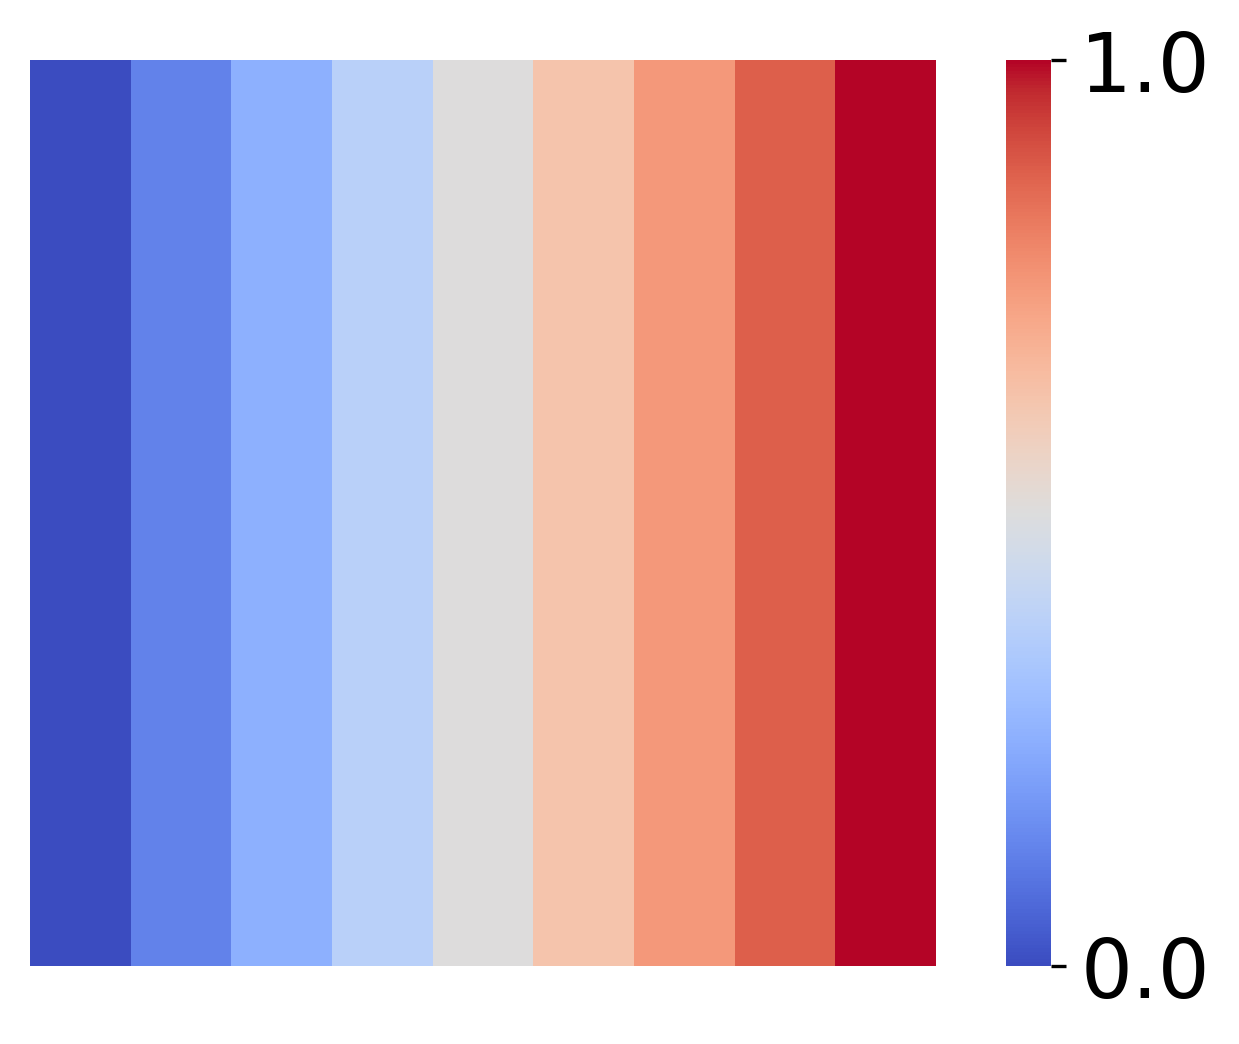

In [68]:
quantile_fig = plot_td_quantile_analysis_results(sim_estss, sim_participant_perturbations, effs, "Reserves", col2name = "Belief", groups = None, num_bins =9, annot=False, square=square, axes_off=axes_off)

In [69]:
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_estimates_NN_permuted.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "td_quantile_estimates_NN_permuted.svg"))

## Panel C: Task 2 Sleeps
### AD

In [70]:
mask = 'nomask'
iday = 3
day = 'day%d' %iday
with_nets = False
include_sleep = False
include_estimates = False
group = None

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)


/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/human_utils_project.py:1281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_day3['group'] = False


[[1.71428571 2.71428571 1.         1.28571429 1.28571429 1.28571429
  0.14285714 0.71428571 0.14285714]
 [3.14285714 5.28571429 2.14285714 3.28571429 2.28571429 1.14285714
  0.28571429 0.42857143 0.        ]
 [3.33333333 3.16666667 2.66666667 3.5        2.33333333 2.33333333
  1.83333333 1.         0.5       ]
 [2.57142857 3.14285714 1.42857143 1.28571429 2.57142857 1.57142857
  0.42857143 1.42857143 0.        ]
 [6.33333333 6.5        3.83333333 5.         3.33333333 1.83333333
  2.5        2.5        0.83333333]
 [5.85714286 6.28571429 4.28571429 3.71428571 3.42857143 2.85714286
  2.57142857 0.71428571 1.57142857]
 [3.33333333 3.83333333 3.33333333 3.33333333 4.         2.83333333
  1.5        1.66666667 1.33333333]
 [3.42857143 4.71428571 2.85714286 2.         2.28571429 1.71428571
  2.         1.28571429 1.57142857]
 [2.28571429 2.71428571 1.57142857 2.14285714 2.57142857 2.28571429
  0.57142857 0.14285714 0.28571429]]


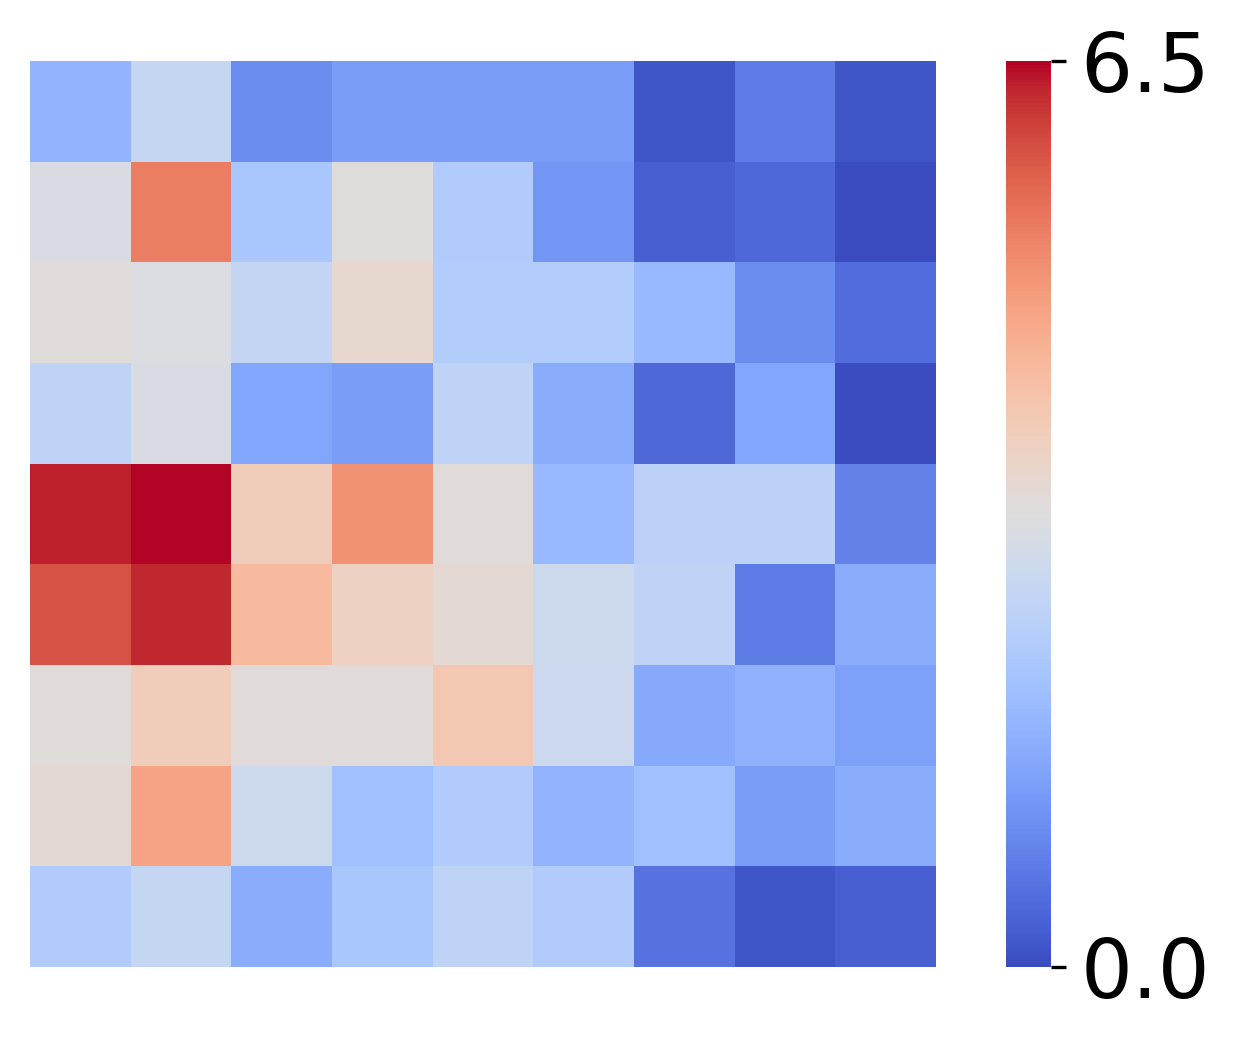

In [71]:
from human_utils_transdiagnostics import plot_td_quantile_analysis_results

quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_sleeps'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Sleeps", col2name="AD", groups = None, num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)


In [72]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_sleeps_AD.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_sleeps_AD.svg"))

### AD Residual

PC1 loadings:  [-0.99899698 -0.0447777 ]
PC2 loadings:  [ 0.0447777  -0.99899698]
Variance explained by PC1:  0.574419642744996
Variance explained by PC2:  0.42558035725500404
Flipped PC1 to enforce second component to be negative.
[[2.         2.85714286 1.57142857 1.71428571 1.42857143 1.42857143
  0.28571429 0.71428571 0.14285714]
 [2.85714286 5.14285714 1.57142857 2.85714286 2.14285714 1.
  0.14285714 0.42857143 0.        ]
 [3.33333333 3.16666667 2.66666667 3.5        2.33333333 2.33333333
  1.83333333 1.         0.5       ]
 [3.42857143 3.71428571 2.28571429 1.71428571 2.42857143 1.
  1.85714286 1.71428571 0.        ]
 [5.         6.16666667 3.33333333 4.66666667 3.83333333 3.16666667
  1.5        2.16666667 0.83333333]
 [6.14285714 6.         3.85714286 3.57142857 3.14285714 2.28571429
  2.         0.71428571 1.57142857]
 [3.33333333 3.83333333 3.33333333 3.33333333 4.         2.83333333
  1.5        1.66666667 1.33333333]
 [3.42857143 4.71428571 2.85714286 2.         2.28571429

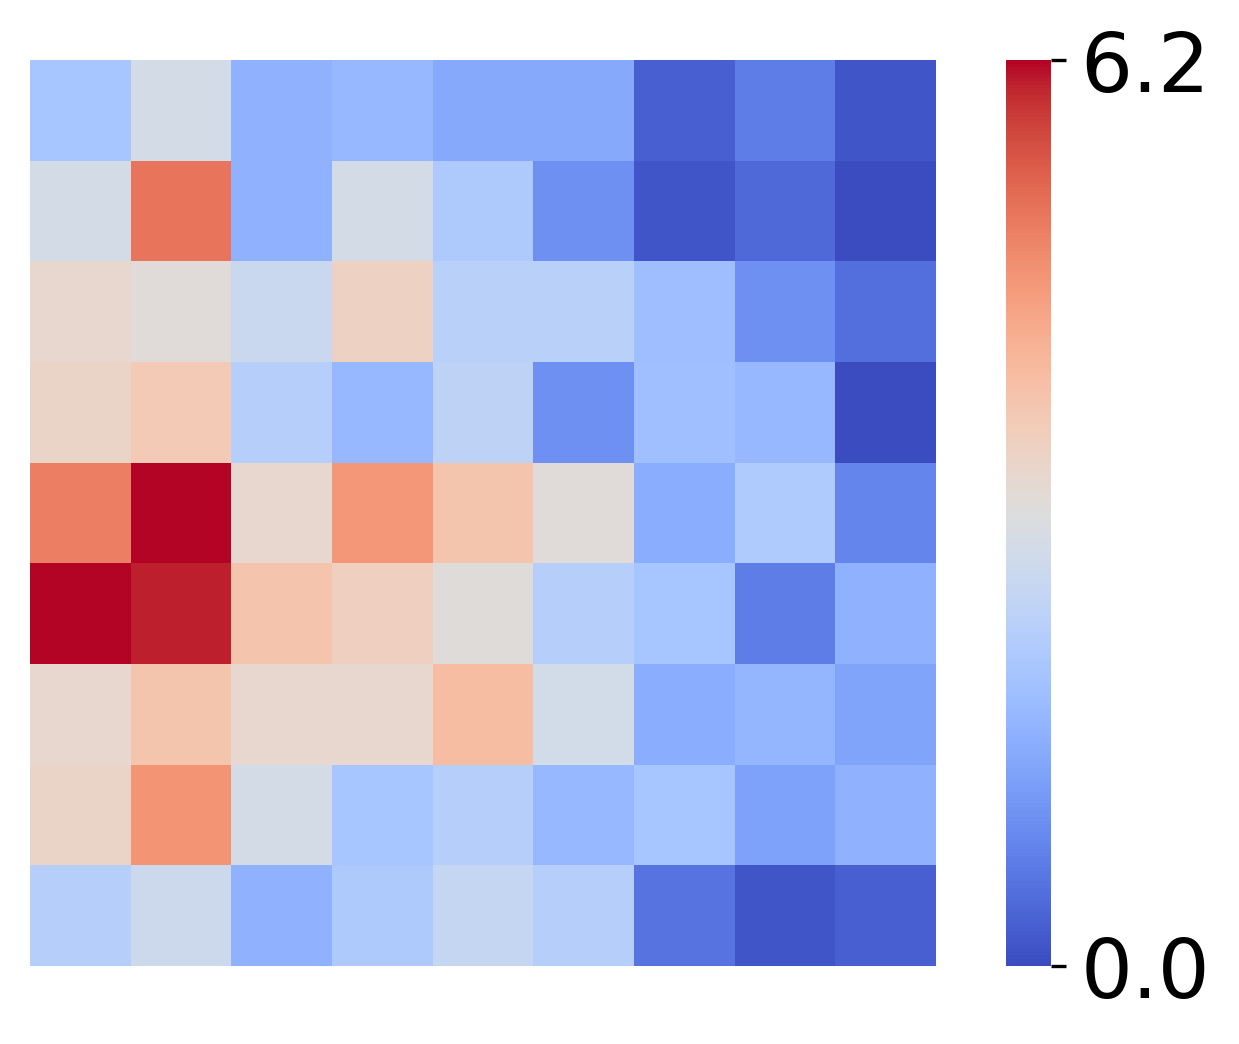

In [73]:
from human_utils_transdiagnostics import plot_td_quantile_analysis_results

#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_sleeps'].values).squeeze(), df['AD'] - AD_pred, np.stack(df["effs"].values), "Sleeps", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_sleeps'].values).squeeze(), get_alternate_TD_representation(df['AD'], df['Compul'], method, -(np.stack(df['n_sleeps'].values).sum(axis=1)))[0], np.stack(df["effs"].values), "Sleeps", col2name="AD", groups = None, num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)

In [74]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_sleeps_AD_residual.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_sleeps_AD_residual.svg"))

### Compul

[[2.57142857 3.57142857 1.57142857 2.14285714 1.71428571 1.14285714
  0.42857143 0.28571429 0.14285714]
 [3.42857143 4.42857143 2.42857143 2.42857143 3.57142857 2.42857143
  1.71428571 2.         1.28571429]
 [6.33333333 6.5        4.5        4.         4.         2.33333333
  3.83333333 0.83333333 1.        ]
 [3.         3.85714286 2.85714286 2.85714286 2.57142857 2.
  1.71428571 0.71428571 0.57142857]
 [4.83333333 6.16666667 2.83333333 3.5        2.5        2.33333333
  1.16666667 1.33333333 0.83333333]
 [2.85714286 3.28571429 1.57142857 1.57142857 2.57142857 2.
  0.57142857 0.85714286 1.14285714]
 [4.33333333 5.83333333 2.5        2.83333333 2.5        1.83333333
  0.83333333 1.33333333 0.66666667]
 [1.85714286 2.57142857 2.28571429 3.14285714 2.71428571 2.14285714
  1.14285714 1.28571429 0.14285714]
 [3.14285714 2.85714286 2.57142857 2.85714286 1.85714286 1.57142857
  0.42857143 1.         0.42857143]]


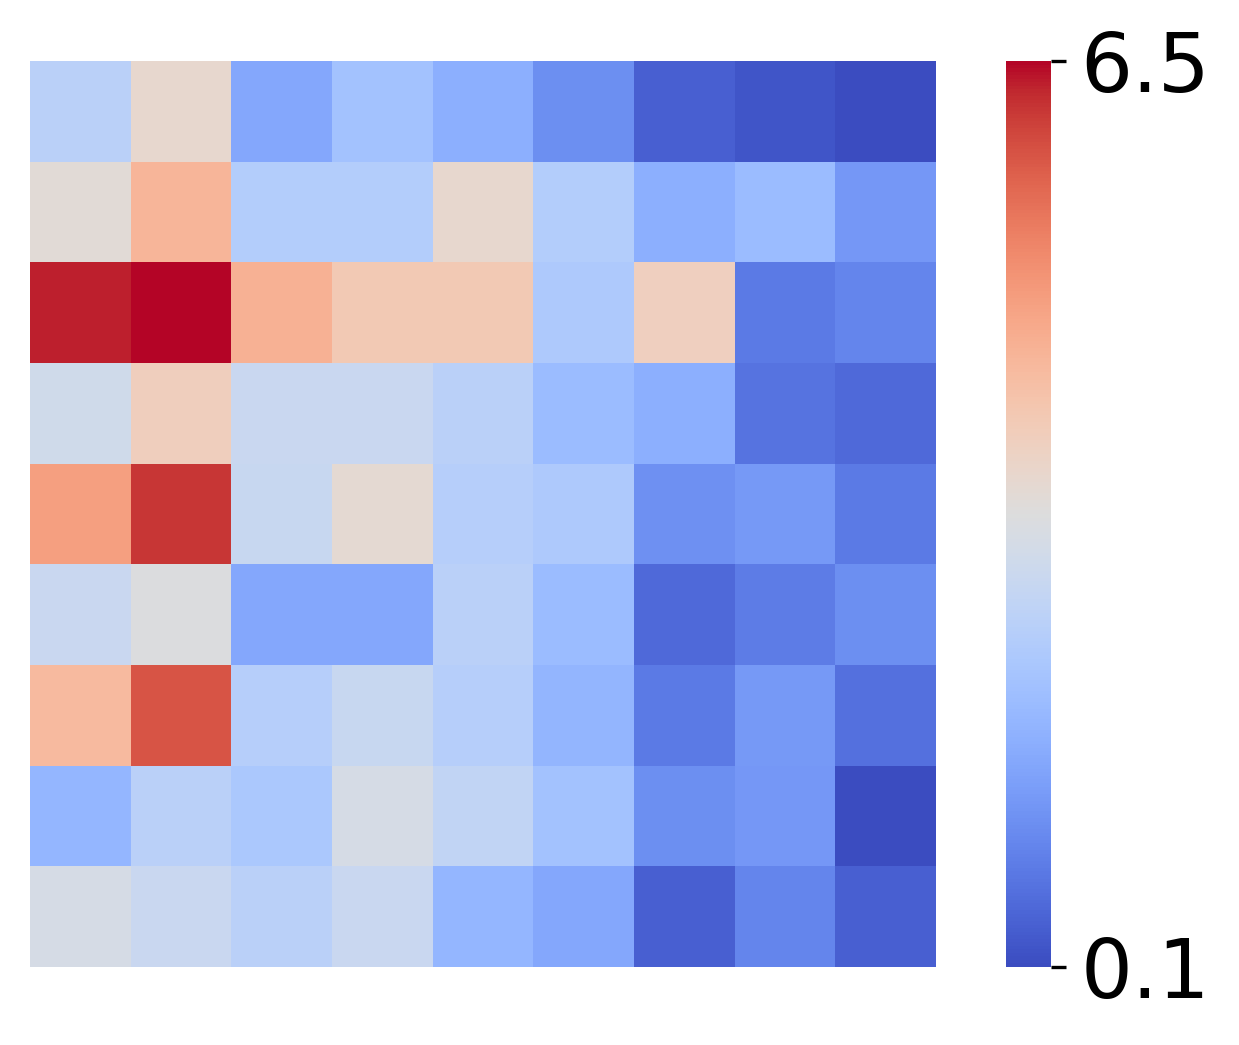

In [75]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_sleeps'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Sleeps", col2name = "Compul", groups = None, num_bins =9, combine_groups = True, annot=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_sleeps'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Sleeps", col2name = "Compul", groups = None, num_bins =9, combine_groups = False, annot=False)

In [76]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_sleeps_Compul.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_sleeps_Compul.svg"))

### Compul Residual

PC1 loadings:  [-0.99899698 -0.0447777 ]
PC2 loadings:  [ 0.0447777  -0.99899698]
Variance explained by PC1:  0.574419642744996
Variance explained by PC2:  0.42558035725500404
Flipped PC1 to enforce second component to be negative.
[[3.14285714 2.85714286 2.57142857 2.85714286 1.85714286 1.57142857
  0.42857143 1.         0.42857143]
 [1.85714286 2.57142857 2.28571429 3.14285714 2.71428571 2.14285714
  1.14285714 1.28571429 0.14285714]
 [4.33333333 5.83333333 2.5        2.83333333 2.5        1.83333333
  0.83333333 1.33333333 0.66666667]
 [2.85714286 3.28571429 1.57142857 1.57142857 2.57142857 2.
  0.57142857 0.85714286 1.14285714]
 [4.33333333 4.83333333 2.66666667 2.83333333 2.16666667 2.
  1.33333333 0.83333333 0.83333333]
 [2.57142857 4.14285714 1.85714286 2.57142857 2.57142857 2.14285714
  0.85714286 1.14285714 0.57142857]
 [6.33333333 6.33333333 5.         4.33333333 4.33333333 1.66666667
  4.16666667 1.         1.        ]
 [3.57142857 5.14285714 2.71428571 2.57142857 2.71428571

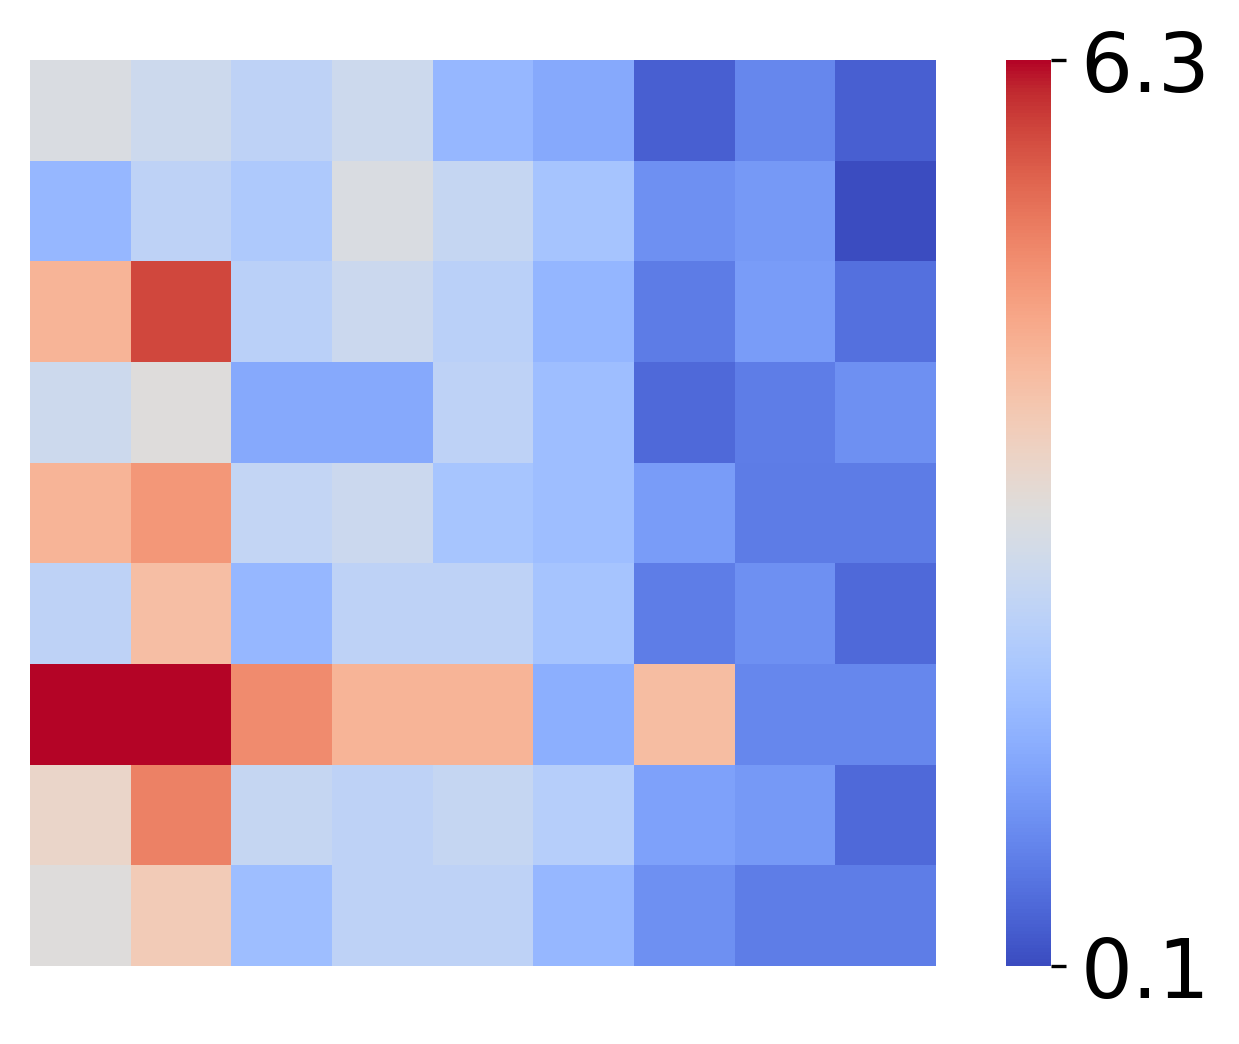

In [77]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_sleeps'].values).squeeze(), get_alternate_TD_representation(df['AD'], df['Compul'], method, -np.stack(df['n_sleeps'].values).sum(axis=1))[1], np.stack(df["effs"].values), "Sleeps", col2name = "Compul", groups = None, num_bins =9, combine_groups = True, annot=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_sleeps'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Sleeps", col2name = "Compul", groups = None, num_bins =9, combine_groups = False, annot=False)

In [78]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_sleeps_Compul_residual.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_sleeps_Compul_residual.svg"))

### SW

[[3.57142857 4.85714286 2.         2.85714286 2.85714286 1.85714286
  0.85714286 0.57142857 0.28571429]
 [3.85714286 4.         2.28571429 2.42857143 2.71428571 1.71428571
  1.14285714 0.57142857 0.85714286]
 [3.66666667 4.         2.66666667 2.5        2.16666667 1.33333333
  2.83333333 1.83333333 0.5       ]
 [2.85714286 4.85714286 2.28571429 3.57142857 2.85714286 2.
  0.57142857 1.57142857 0.28571429]
 [3.16666667 4.5        2.5        2.5        2.33333333 1.83333333
  1.33333333 1.         1.16666667]
 [3.57142857 3.42857143 2.57142857 2.71428571 3.14285714 2.71428571
  1.         0.71428571 1.57142857]
 [4.16666667 5.         3.5        4.16666667 3.16666667 2.66666667
  1.83333333 1.5        1.33333333]
 [2.42857143 4.14285714 1.71428571 2.14285714 2.28571429 1.14285714
  0.85714286 1.28571429 0.        ]
 [4.42857143 3.57142857 3.42857143 2.28571429 2.28571429 2.42857143
  1.42857143 0.71428571 0.28571429]]


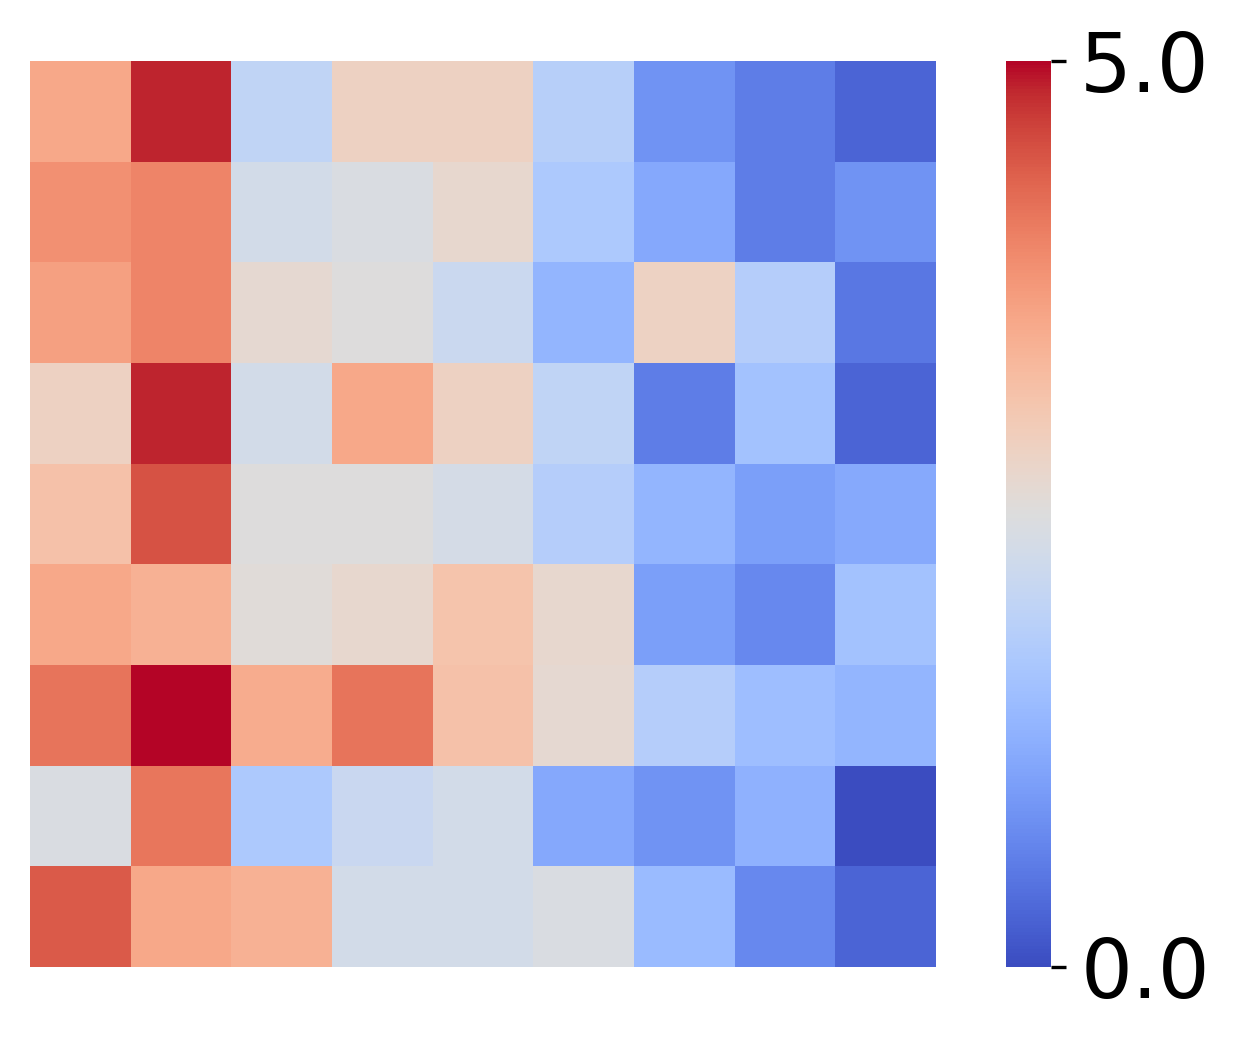

In [79]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_sleeps'].values).squeeze(), df['SW'], np.stack(df["effs"].values), "Sleeps", col2name = "SW", groups = None, num_bins =9, combine_groups = True, annot=False, square=square, axes_off=axes_off)

In [80]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_sleeps_SW.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_sleeps_SW.svg"))

### Trait-level Perturbations

In [81]:
from settings_anal import levc_human_ape_models as ape_models
from settings_anal import trait_simulated_participants_folder_t2 as simulated_participants_folder
from settings_anal import trait_sim_timestamp_t2 as sim_timestamp
from settings_anal import trait_sim_mag_perturbation as mag_perturbation
from settings_anal import trait_sim_bias_perturbation as bias_perturbation
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models

effs = np.arange(0, 1.01, 0.125)

sim_rewss, sim_obss, sim_sleepss = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)
sim_sleepss = sim_sleepss.mean(axis=0)

## flip to correct for switching from tau to efficacy
sim_obss = np.flip(sim_obss.T,axis=1)
sim_sleepss = np.flip(sim_sleepss.T, axis=1)
sim_rewss = np.flip(sim_rewss.T, axis=1)

with open(os.path.join('data', 'sim_perturbed_participants', 'levc', 'sim', 'mag%dbias%d'%(mag_perturbation*100, bias_perturbation*100), '%s_simulated_participant_perturbations_sim_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

[[10.39294118  9.036       7.76076471  6.54358824  5.53394118  4.91135294
   4.54470588  4.31023529  4.11682353]
 [ 8.52635294  7.39129412  6.352       5.43017647  4.66188235  4.24058824
   4.04        3.88811765  3.72641176]
 [ 7.47425     6.510625    5.6511875   4.88425     4.260375    3.9218125
   3.739125    3.5769375   3.4194375 ]
 [ 7.03676471  6.16111765  5.36223529  4.66652941  4.09017647  3.77917647
   3.587       3.41394118  3.24994118]
 [ 6.74575     5.87        5.1261875   4.4863125   3.97        3.653625
   3.4634375   3.29275     3.1393125 ]
 [ 6.38982353  5.55841176  4.89517647  4.30105882  3.82052941  3.51188235
   3.31552941  3.158       3.01952941]
 [ 6.0613125   5.31625     4.661       4.105875    3.659375    3.359875
   3.1734375   3.044125    2.9076875 ]
 [ 5.48505882  4.81976471  4.22776471  3.73158824  3.35805882  3.10935294
   2.96347059  2.82194118  2.70464706]
 [ 4.64552941  4.08423529  3.61064706  3.24435294  2.96970588  2.78394118
   2.63511765  2.50635294  

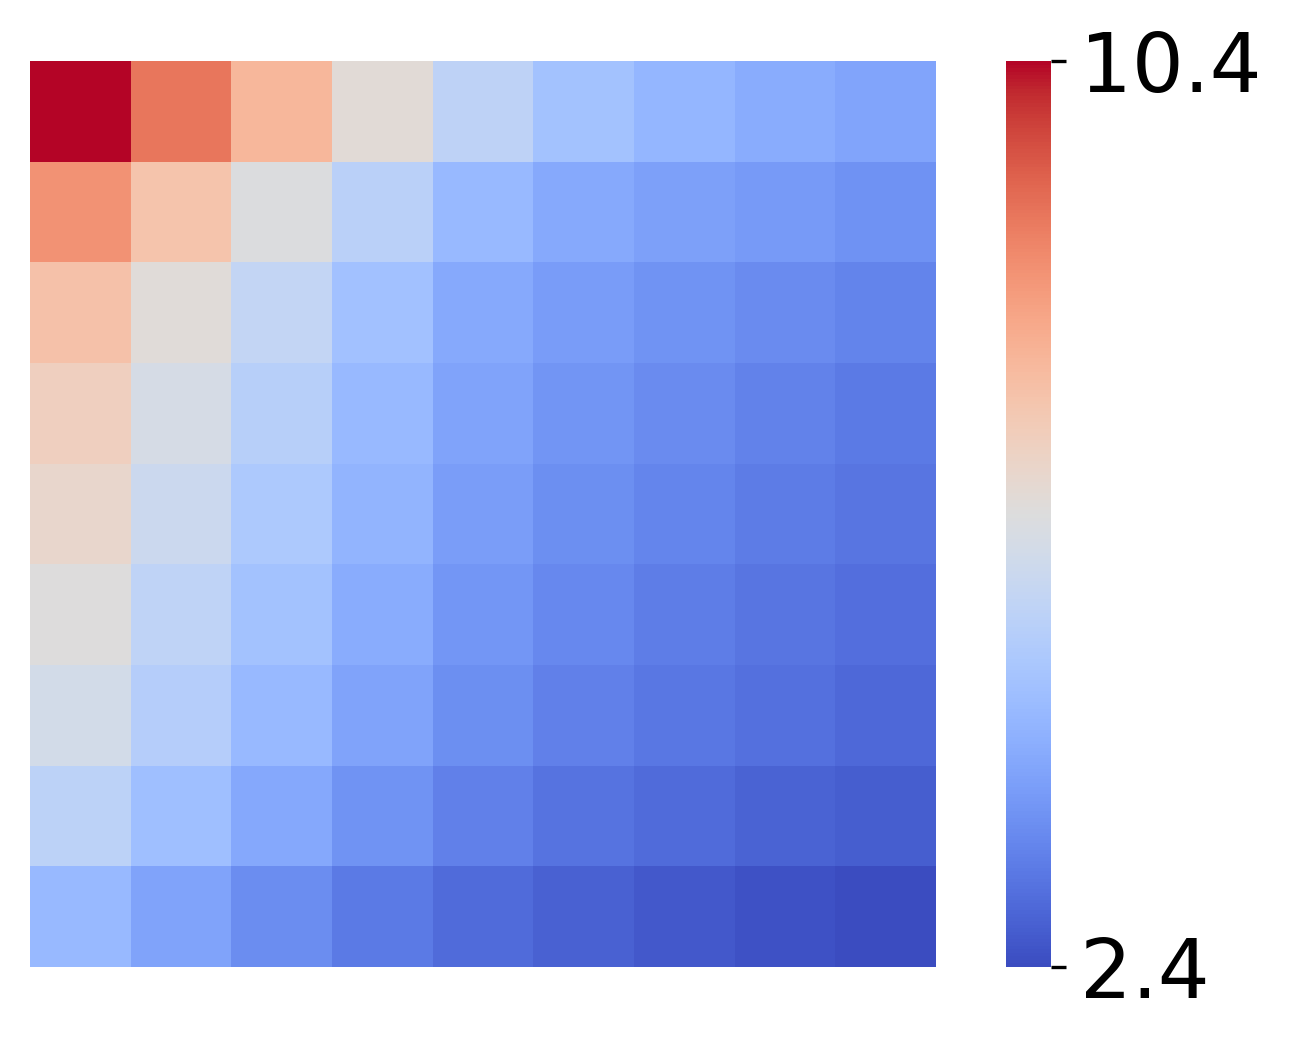

In [82]:
quantile_fig = plot_td_quantile_analysis_results(sim_sleepss, sim_participant_perturbations, effs, "Sleeps", col2name = "Belief", groups = None, num_bins =9, annot=False, square=square, axes_off=axes_off)

In [83]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_sleeps_NN.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_sleeps_NN.svg"))

### Permuted Simulations

In [84]:
from human_utils_behavioral_analysis import load_simulated_participants_across_models
from settings_anal import levc_human_ape_models as ape_models
from settings_anal import zeros_simulated_participants_folder_t2 as simulated_participants_folder
from settings_anal import zeros_sim_timestamp_t2 as sim_timestamp
from settings_anal import trait_sim_mag_perturbation as mag_perturbation
from settings_anal import trait_sim_bias_perturbation as bias_perturbation


effs = np.arange(0, 1.01, 0.125)

sim_rewss, sim_obss, sim_sleepss = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)
sim_sleepss = sim_sleepss.mean(axis=0)

## flip to correct for switching from tau to efficacy
sim_obss = np.flip(sim_obss.T,axis=1)
sim_sleepss = np.flip(sim_sleepss.T, axis=1)
sim_rewss = np.flip(sim_rewss.T, axis=1)

with open(os.path.join('data', 'sim_perturbed_participants', 'levc', 'nostruc', 'mag%dbias%d'%(mag_perturbation*100, bias_perturbation*100), '%s_simulated_participant_perturbations_nostruc_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

[[6.86580667 5.9831     5.21751333 4.55474667 4.01993333 3.71337333
  3.51579333 3.34385333 3.18756667]
 [6.86580667 5.9831     5.21751333 4.55474667 4.01993333 3.71337333
  3.51579333 3.34385333 3.18756667]
 [6.86580667 5.9831     5.21751333 4.55474667 4.01993333 3.71337333
  3.51579333 3.34385333 3.18756667]
 [6.86580667 5.9831     5.21751333 4.55474667 4.01993333 3.71337333
  3.51579333 3.34385333 3.18756667]
 [6.86580667 5.9831     5.21751333 4.55474667 4.01993333 3.71337333
  3.51579333 3.34385333 3.18756667]
 [6.86580667 5.9831     5.21751333 4.55474667 4.01993333 3.71337333
  3.51579333 3.34385333 3.18756667]
 [6.86580667 5.9831     5.21751333 4.55474667 4.01993333 3.71337333
  3.51579333 3.34385333 3.18756667]
 [6.86580667 5.9831     5.21751333 4.55474667 4.01993333 3.71337333
  3.51579333 3.34385333 3.18756667]
 [6.86580667 5.9831     5.21751333 4.55474667 4.01993333 3.71337333
  3.51579333 3.34385333 3.18756667]]


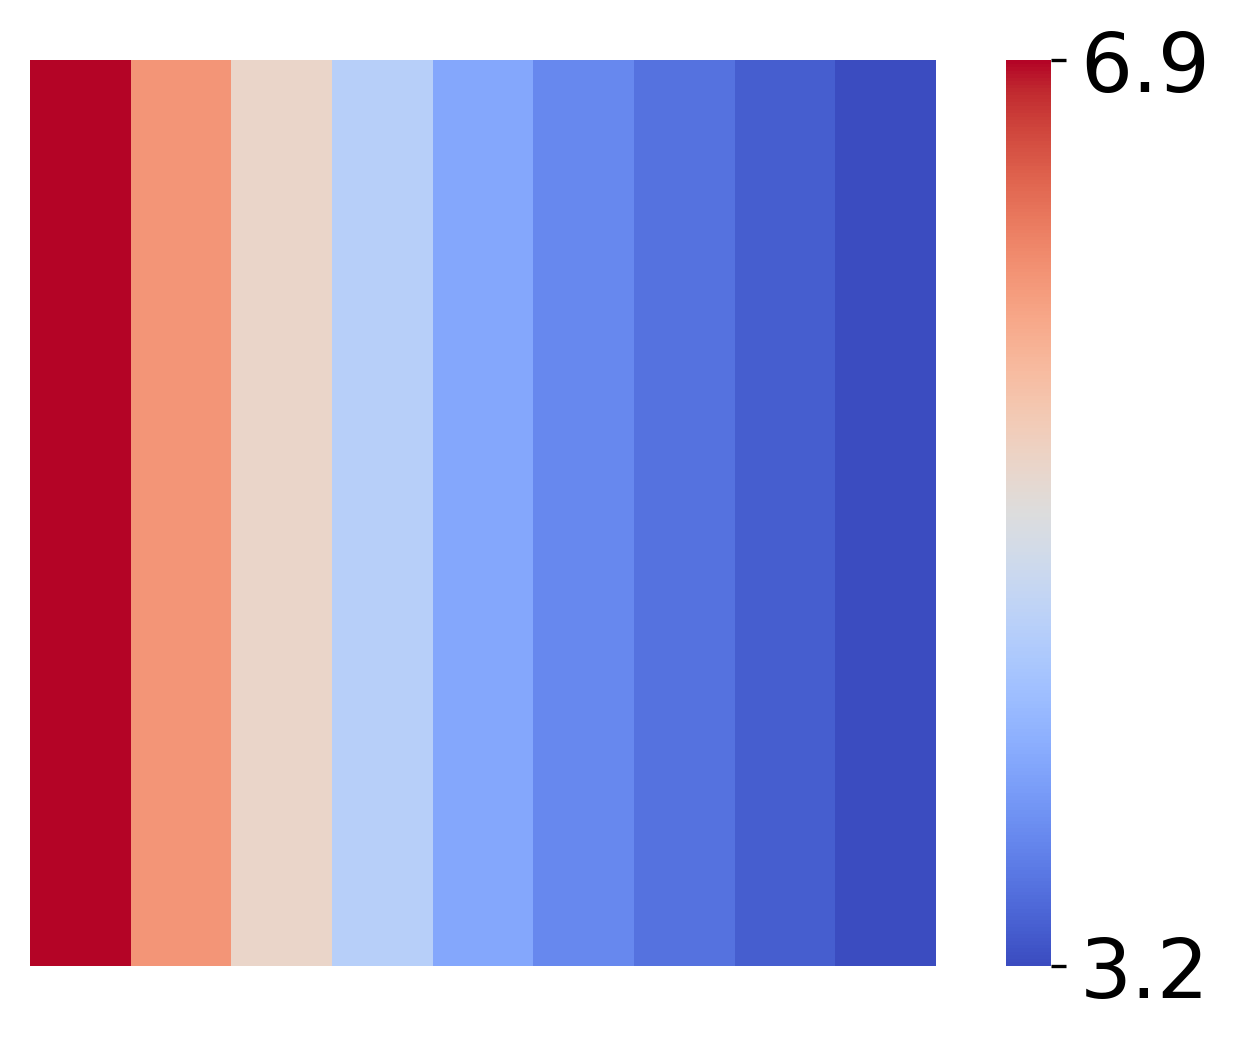

In [85]:
quantile_fig = plot_td_quantile_analysis_results(sim_sleepss, sim_participant_perturbations, effs, "Sleeps", col2name = "Belief", groups = None, num_bins =9, annot=False, square=square, axes_off=axes_off)

In [86]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_sleeps_NN_permuted.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_sleeps_NN_permuted.svg"))

## Panel D: Task 2 Observes

### AD

In [87]:
mask = 'nomask'
iday = 3
day = 'day%d' %iday
with_nets = False
include_sleep = False
include_estimates = False
group = None

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/human_utils_project.py:1281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_day3['group'] = False


[[6.         6.14285714 6.         5.28571429 6.42857143 6.28571429
  6.85714286 7.         7.28571429]
 [6.         7.         6.57142857 8.14285714 8.         8.14285714
  8.         8.         7.71428571]
 [4.         3.5        4.66666667 4.83333333 5.16666667 5.83333333
  5.         5.83333333 5.5       ]
 [6.42857143 6.71428571 6.         6.71428571 7.28571429 8.14285714
  6.42857143 7.85714286 7.28571429]
 [8.5        7.         8.5        6.66666667 7.83333333 7.83333333
  8.66666667 7.83333333 9.33333333]
 [6.         5.28571429 5.71428571 5.         5.71428571 6.
  7.71428571 7.57142857 8.        ]
 [5.5        4.66666667 6.66666667 5.66666667 7.33333333 6.16666667
  6.33333333 6.83333333 6.83333333]
 [5.28571429 6.         6.14285714 5.42857143 6.         6.
  6.57142857 6.85714286 6.42857143]
 [3.57142857 4.         4.         3.57142857 4.71428571 5.57142857
  5.57142857 5.57142857 5.71428571]]


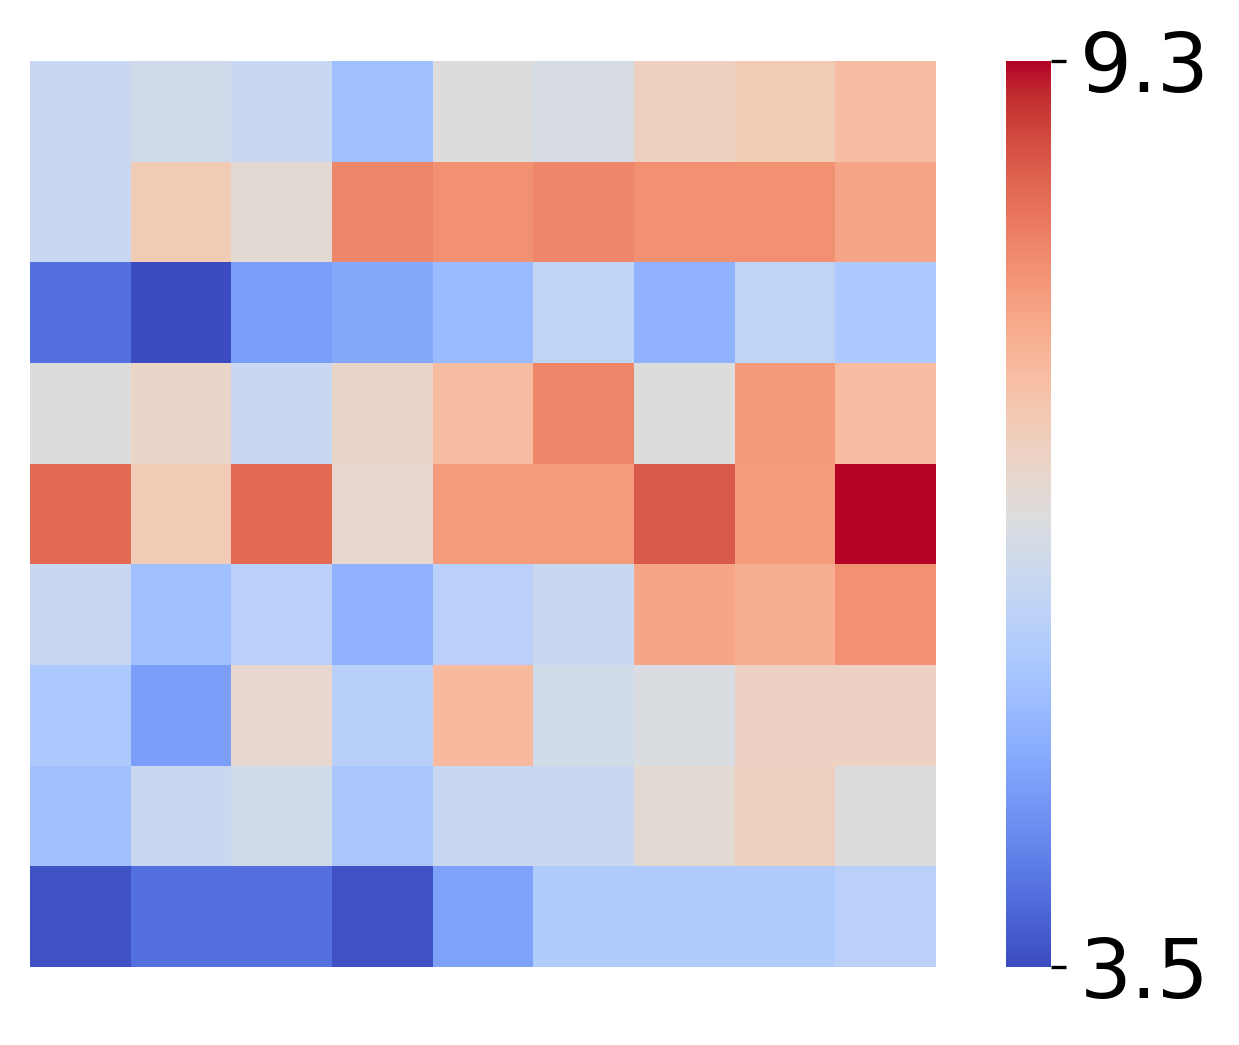

In [88]:
from human_utils_transdiagnostics import plot_td_quantile_analysis_results

quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Observes", col2name="AD", groups = None, num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)


In [89]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_observes_AD.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_observes_AD.svg"))

### AD Residual

PC1 loadings:  [-0.99899698 -0.0447777 ]
PC2 loadings:  [ 0.0447777  -0.99899698]
Variance explained by PC1:  0.574419642744996
Variance explained by PC2:  0.42558035725500404
Flipped PC1 to enforce second component to be negative.
[[6.         5.85714286 6.85714286 5.71428571 6.71428571 6.71428571
  7.14285714 7.42857143 7.71428571]
 [6.         7.28571429 5.71428571 7.71428571 7.71428571 7.71428571
  7.71428571 7.57142857 7.28571429]
 [4.         3.5        4.66666667 4.83333333 5.16666667 5.83333333
  5.         5.83333333 5.5       ]
 [6.42857143 6.28571429 5.71428571 6.57142857 6.85714286 7.71428571
  6.57142857 7.14285714 7.42857143]
 [9.         8.16666667 8.33333333 7.5        8.5        8.16666667
  8.         8.         9.16666667]
 [5.57142857 4.71428571 6.14285714 4.42857143 5.57142857 6.14285714
  8.14285714 8.14285714 8.        ]
 [5.5        4.66666667 6.66666667 5.66666667 7.33333333 6.16666667
  6.33333333 6.83333333 6.83333333]
 [5.28571429 6.         6.14285714 5.428

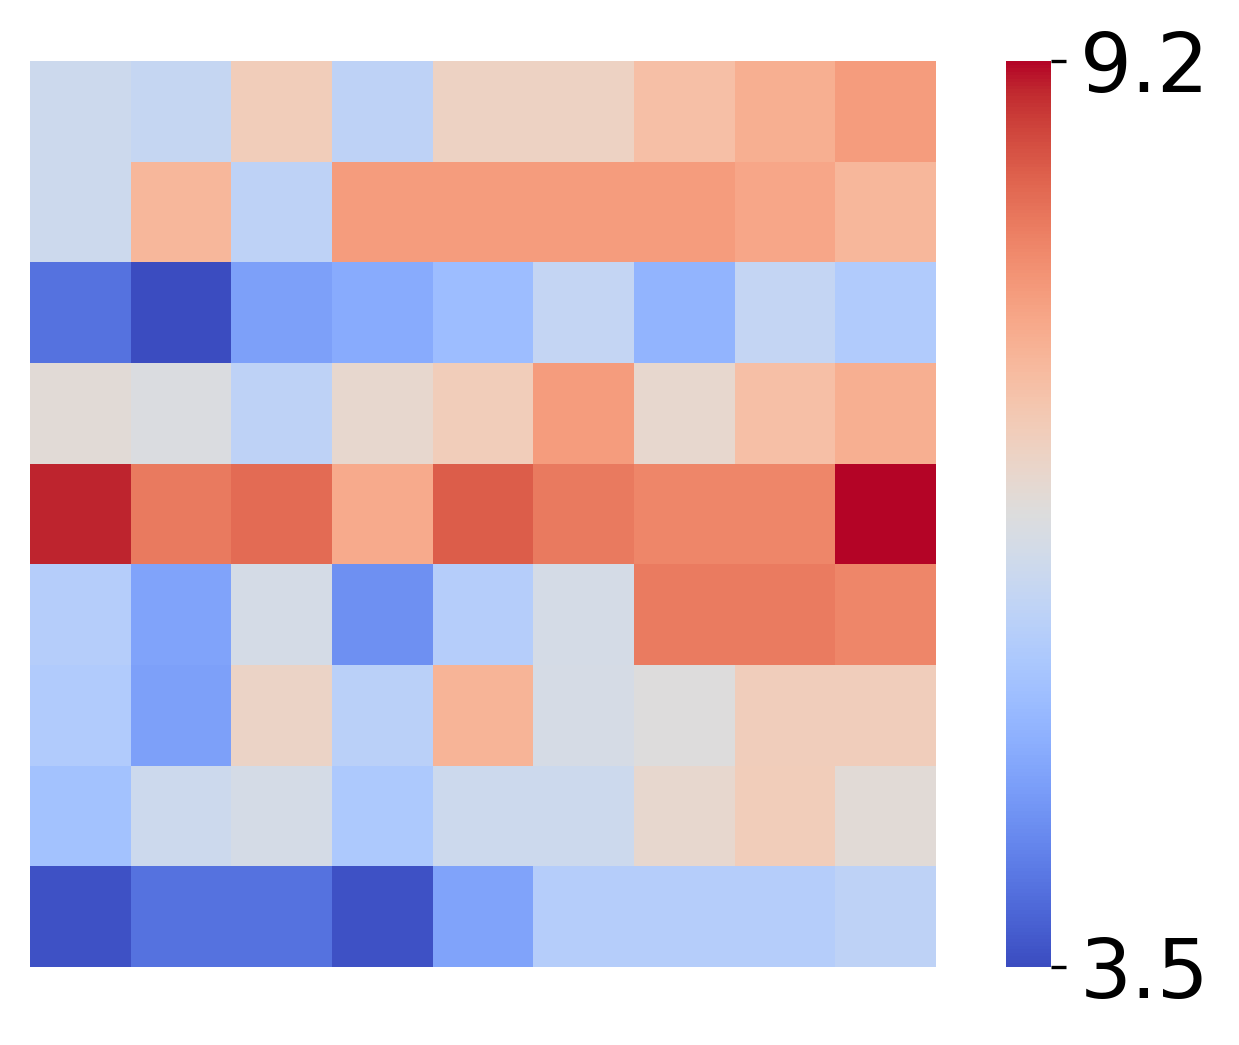

In [90]:
from human_utils_transdiagnostics import plot_td_quantile_analysis_results

quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), get_alternate_TD_representation(df['AD'], df['Compul'], method, -np.stack(df['n_sleeps'].values).sum(axis=1))[0], np.stack(df["effs"].values), "Observes", col2name="AD", groups = None, num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Observes", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Observes", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=True, square=square, axes_off=axes_off)


In [91]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_observes_AD_residual.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_observes_AD_residual.svg"))

### Compul

[[4.         4.28571429 4.71428571 5.14285714 5.28571429 5.
  5.28571429 5.42857143 5.57142857]
 [5.28571429 3.57142857 4.85714286 4.57142857 5.42857143 4.28571429
  5.57142857 6.71428571 5.57142857]
 [7.         6.66666667 7.66666667 5.66666667 7.66666667 8.
  7.5        8.33333333 8.16666667]
 [4.57142857 5.42857143 4.71428571 5.71428571 6.         7.28571429
  7.28571429 6.85714286 7.57142857]
 [5.83333333 6.83333333 5.83333333 7.16666667 6.33333333 6.5
  6.33333333 6.33333333 6.83333333]
 [5.42857143 5.14285714 5.57142857 4.57142857 6.28571429 7.14285714
  6.28571429 7.         6.85714286]
 [7.83333333 8.         7.16666667 7.5        7.83333333 8.33333333
  8.33333333 7.83333333 8.5       ]
 [3.42857143 3.85714286 6.14285714 5.28571429 6.42857143 6.85714286
  6.71428571 6.85714286 7.42857143]
 [8.28571429 7.42857143 7.71428571 6.14285714 7.42857143 7.
  8.14285714 8.28571429 7.85714286]]


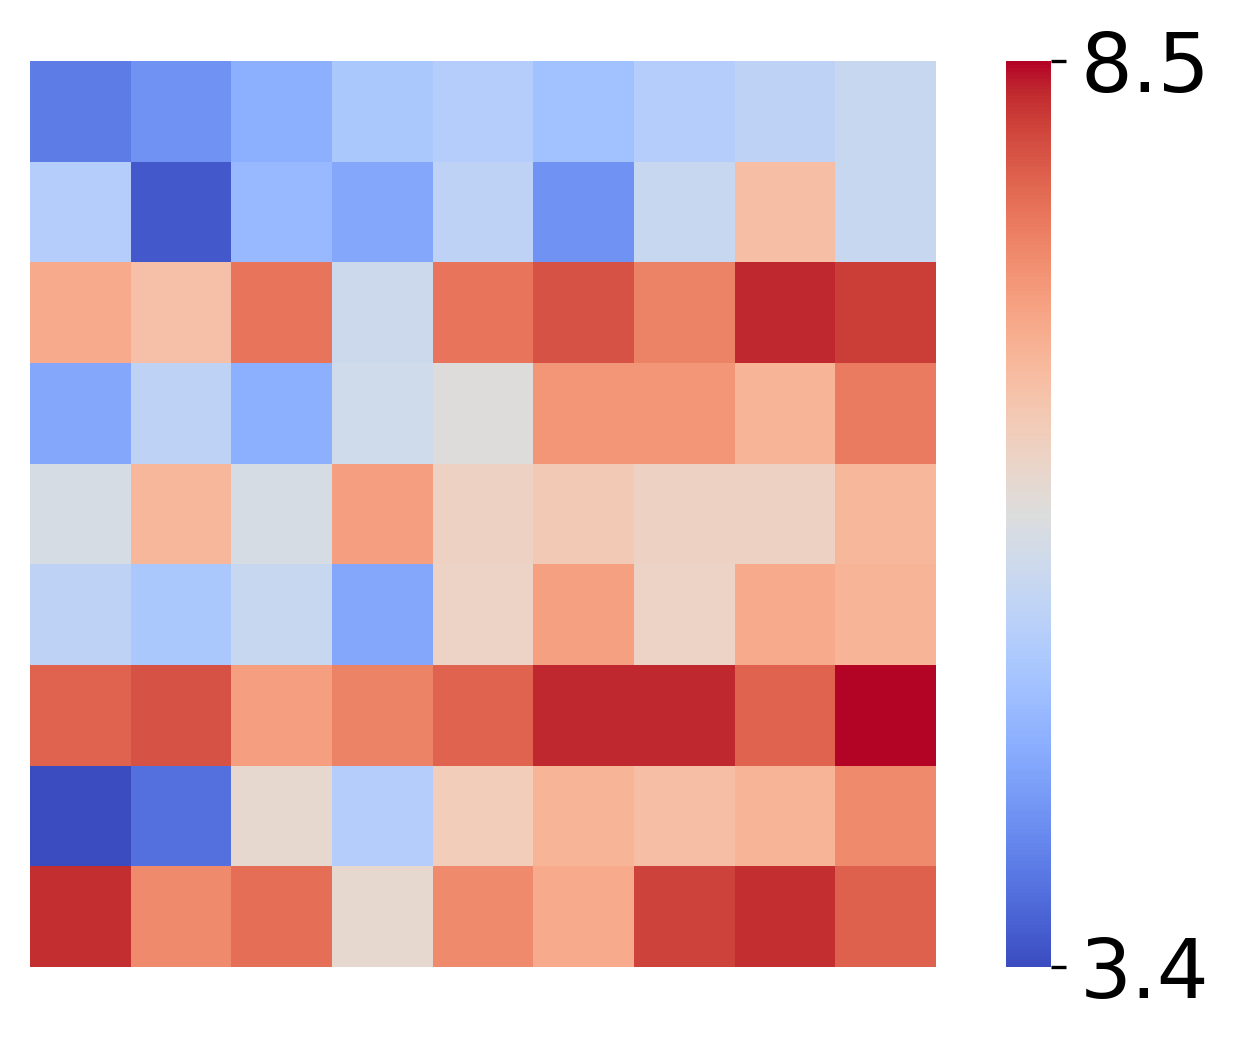

In [92]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Observes", col2name = "Compul", groups = None, num_bins =9, combine_groups = True, annot=False, square=square, axes_off=axes_off)

In [93]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_observes_Compul.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_observes_Compul.svg"))

### Compul Residual

PC1 loadings:  [-0.99899698 -0.0447777 ]
PC2 loadings:  [ 0.0447777  -0.99899698]
Variance explained by PC1:  0.574419642744996
Variance explained by PC2:  0.42558035725500404
Flipped PC1 to enforce second component to be negative.
[[8.28571429 7.42857143 7.71428571 6.14285714 7.42857143 7.
  8.14285714 8.28571429 7.85714286]
 [3.42857143 3.85714286 6.14285714 5.28571429 6.42857143 6.85714286
  6.71428571 6.85714286 7.42857143]
 [7.83333333 8.         7.16666667 7.5        7.83333333 8.33333333
  8.33333333 7.83333333 8.5       ]
 [5.42857143 5.14285714 5.57142857 4.57142857 6.28571429 7.14285714
  6.28571429 7.         6.85714286]
 [5.5        6.66666667 5.16666667 7.33333333 6.83333333 6.66666667
  6.         6.66666667 6.66666667]
 [4.85714286 5.42857143 5.57142857 4.57142857 5.85714286 7.42857143
  7.85714286 6.85714286 7.71428571]
 [6.5        6.66666667 6.66666667 6.66666667 7.16666667 7.5
  6.         7.5        7.16666667]
 [5.71428571 3.85714286 5.28571429 4.71428571 5.7142857

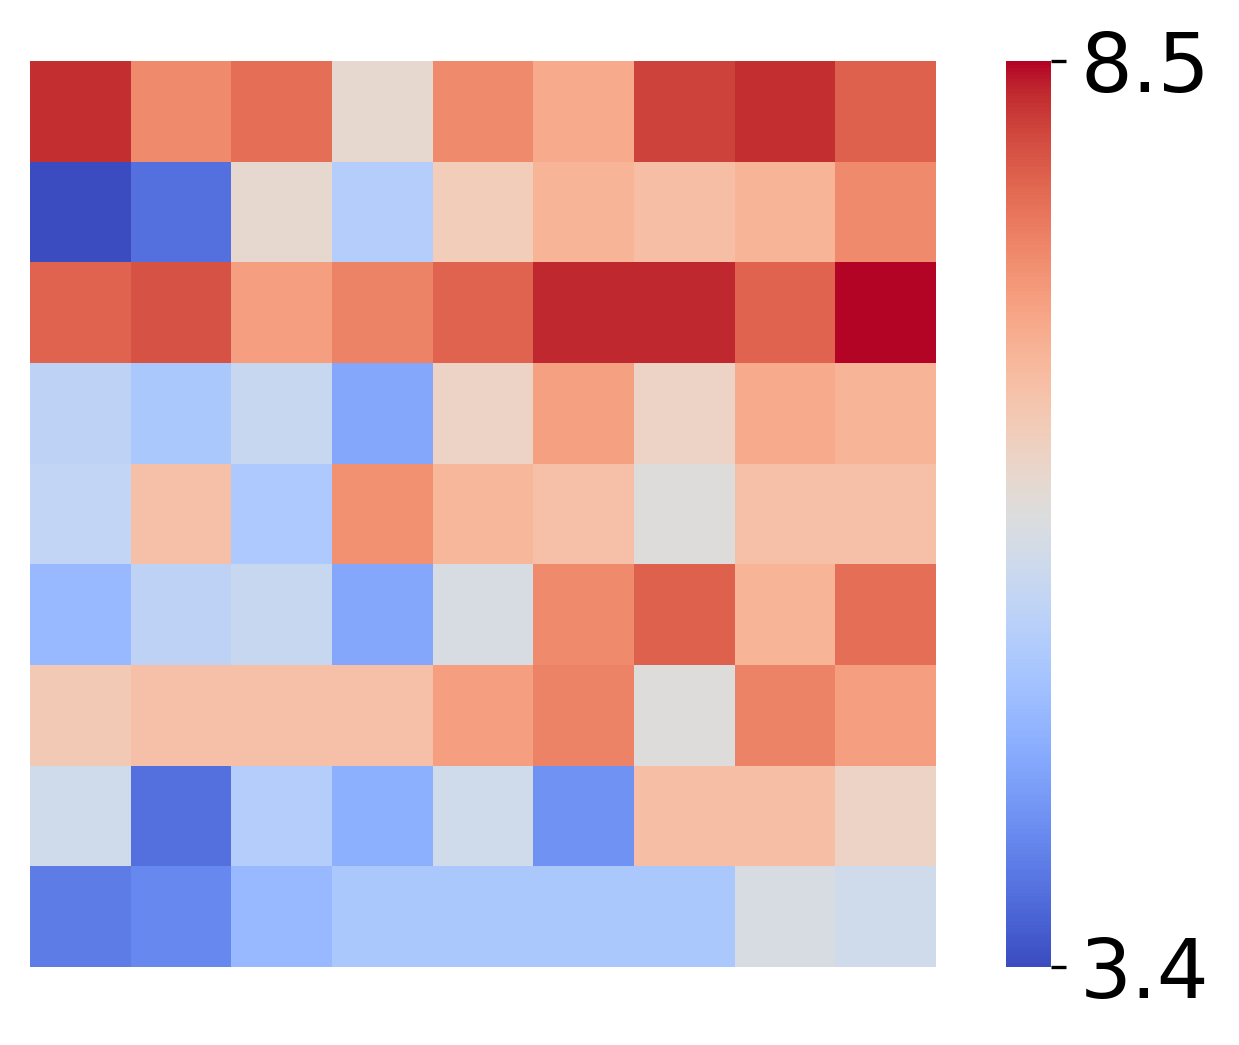

In [94]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), get_alternate_TD_representation(df['AD'], df['Compul'], method, -np.stack(df['n_sleeps'].values).sum(axis=1))[1], np.stack(df["effs"].values), "Observes", col2name = "Compul", groups = None, num_bins =9, combine_groups = True, annot=False, square=square, axes_off=axes_off)

In [95]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_observes_Compul_residual.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_observes_Compul_residual.svg"))

### SW

[[3.57142857 4.14285714 3.42857143 4.28571429 4.14285714 3.85714286
  3.14285714 4.28571429 3.85714286]
 [6.42857143 7.14285714 6.85714286 5.85714286 7.85714286 8.
  7.42857143 8.14285714 8.14285714]
 [5.5        5.16666667 5.66666667 6.66666667 6.         8.
  8.83333333 7.66666667 8.66666667]
 [6.         6.42857143 7.28571429 7.57142857 8.57142857 8.28571429
  8.57142857 8.14285714 8.71428571]
 [4.83333333 4.5        4.66666667 4.66666667 4.66666667 5.83333333
  5.83333333 5.66666667 6.        ]
 [6.         4.28571429 7.14285714 5.28571429 6.85714286 6.
  6.57142857 8.         6.85714286]
 [6.83333333 5.83333333 7.         6.83333333 7.16666667 6.83333333
  7.         7.5        7.33333333]
 [5.42857143 5.57142857 5.57142857 5.         6.57142857 7.
  7.14285714 7.42857143 7.71428571]
 [6.57142857 7.28571429 6.28571429 5.28571429 6.28571429 6.28571429
  6.85714286 6.57142857 6.85714286]]


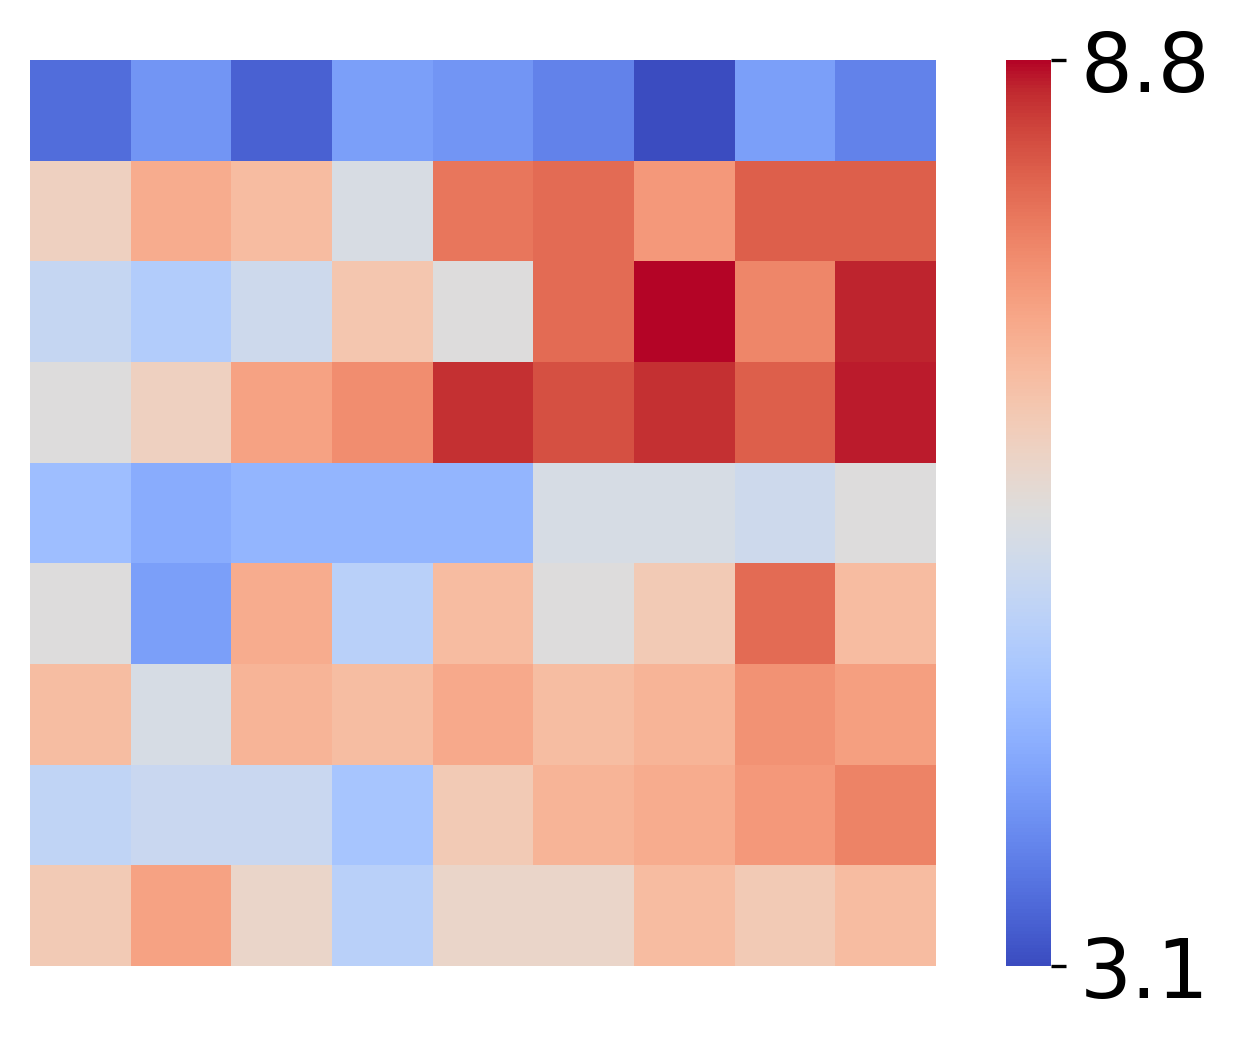

In [96]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['n_observes'].values).squeeze(), df['SW'], np.stack(df["effs"].values), "Observes", col2name = "SW", groups = None, num_bins =9, combine_groups = True, annot=False, square=square, axes_off=axes_off)

In [97]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_observes_SW.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_observes_SW.svg"))

### Trait-level Perturbations

In [98]:
from settings_anal import levc_human_ape_models as ape_models
from settings_anal import trait_simulated_participants_folder_t2 as simulated_participants_folder
from settings_anal import trait_sim_timestamp_t2 as sim_timestamp
from settings_anal import trait_sim_mag_perturbation as mag_perturbation
from settings_anal import trait_sim_bias_perturbation as bias_perturbation

effs = np.arange(0, 1.01, 0.125)

sim_rewss, sim_obss, sim_sleepss = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)
sim_sleepss = sim_sleepss.mean(axis=0)

## flip to correct for switching from tau to efficacy
sim_obss = np.flip(sim_obss.T,axis=1)
sim_sleepss = np.flip(sim_sleepss.T, axis=1)
sim_rewss = np.flip(sim_rewss.T, axis=1)

with open(os.path.join('data', 'sim_perturbed_participants', 'levc', 'sim', 'mag%dbias%d'%(mag_perturbation*100, bias_perturbation*100), '%s_simulated_participant_perturbations_sim_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

[[4.89876471 5.021      5.144      5.26023529 5.40617647 5.57311765
  5.70723529 5.81358824 5.90388235]
 [5.10076471 5.21717647 5.34441176 5.47070588 5.62864706 5.82688235
  5.92794118 5.99852941 6.05135294]
 [5.2565     5.3819375  5.491375   5.5985625  5.75825    5.95025
  6.047625   6.1078125  6.1693125 ]
 [5.321      5.44658824 5.55794118 5.67594118 5.84635294 6.00982353
  6.10964706 6.17488235 6.24152941]
 [5.365375   5.4914375  5.6074375  5.740375   5.89625    6.052375
  6.1535     6.2283125  6.29275   ]
 [5.44635294 5.56376471 5.68882353 5.79576471 5.95741176 6.12335294
  6.21823529 6.28235294 6.35070588]
 [5.515125   5.619      5.7244375  5.846375   6.0121875  6.162125
  6.26725    6.36675    6.4165    ]
 [5.61017647 5.733      5.83717647 5.97458824 6.12264706 6.26011765
  6.38882353 6.46258824 6.53394118]
 [5.79282353 5.88629412 6.00829412 6.16352941 6.29594118 6.44082353
  6.53870588 6.62952941 6.70217647]]


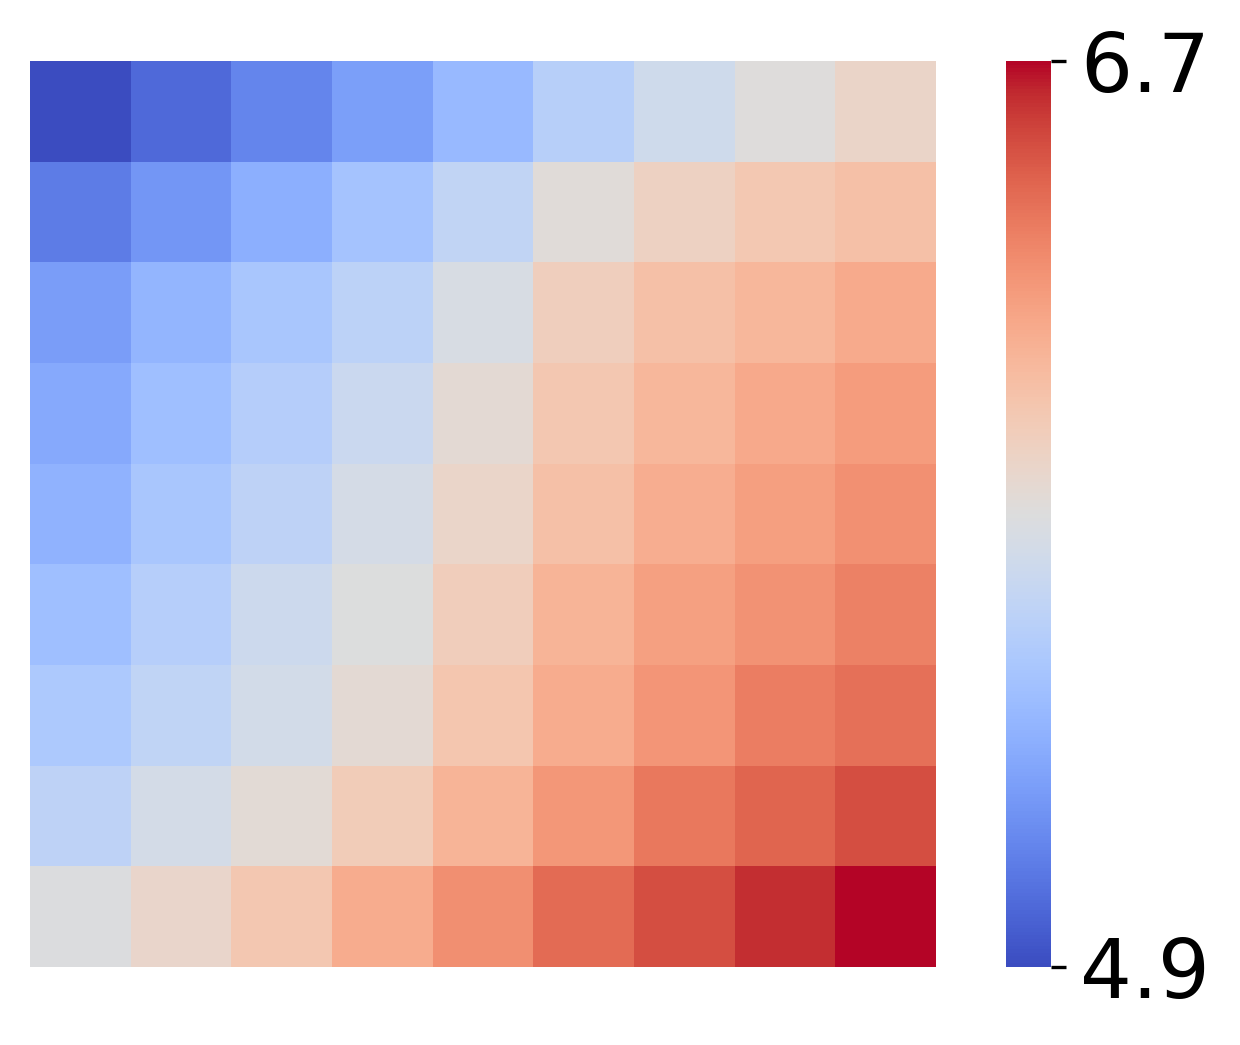

In [99]:
quantile_fig = plot_td_quantile_analysis_results(sim_obss, sim_participant_perturbations, effs, "Observes", col2name = "Belief", groups = None, num_bins =9, annot=False, square=square, axes_off=axes_off)

In [100]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_observes_NN.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_observes_NN.svg"))

### Permuted

In [101]:
from human_utils_behavioral_analysis import load_simulated_participants_across_models
from settings_anal import levc_human_ape_models as ape_models
from settings_anal import zeros_simulated_participants_folder_t2 as simulated_participants_folder
from settings_anal import zeros_sim_timestamp_t2 as sim_timestamp
from settings_anal import trait_sim_mag_perturbation as mag_perturbation
from settings_anal import trait_sim_bias_perturbation as bias_perturbation

effs = np.arange(0, 1.01, 0.125)

sim_rewss, sim_obss, sim_sleepss = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)
sim_sleepss = sim_sleepss.mean(axis=0)

## flip to correct for switching from tau to efficacy
sim_obss = np.flip(sim_obss.T,axis=1)
sim_sleepss = np.flip(sim_sleepss.T, axis=1)
sim_rewss = np.flip(sim_rewss.T, axis=1)

with open(os.path.join('data', 'sim_perturbed_participants', 'levc', 'nostruc', 'mag%dbias%d'%(mag_perturbation*100, bias_perturbation*100), '%s_simulated_participant_perturbations_nostruc_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

[[5.35536    5.47317333 5.58918667 5.7094     5.87556    6.03971333
  6.14371333 6.21030667 6.27811333]
 [5.35536    5.47317333 5.58918667 5.7094     5.87556    6.03971333
  6.14371333 6.21030667 6.27811333]
 [5.35536    5.47317333 5.58918667 5.7094     5.87556    6.03971333
  6.14371333 6.21030667 6.27811333]
 [5.35536    5.47317333 5.58918667 5.7094     5.87556    6.03971333
  6.14371333 6.21030667 6.27811333]
 [5.35536    5.47317333 5.58918667 5.7094     5.87556    6.03971333
  6.14371333 6.21030667 6.27811333]
 [5.35536    5.47317333 5.58918667 5.7094     5.87556    6.03971333
  6.14371333 6.21030667 6.27811333]
 [5.35536    5.47317333 5.58918667 5.7094     5.87556    6.03971333
  6.14371333 6.21030667 6.27811333]
 [5.35536    5.47317333 5.58918667 5.7094     5.87556    6.03971333
  6.14371333 6.21030667 6.27811333]
 [5.35536    5.47317333 5.58918667 5.7094     5.87556    6.03971333
  6.14371333 6.21030667 6.27811333]]


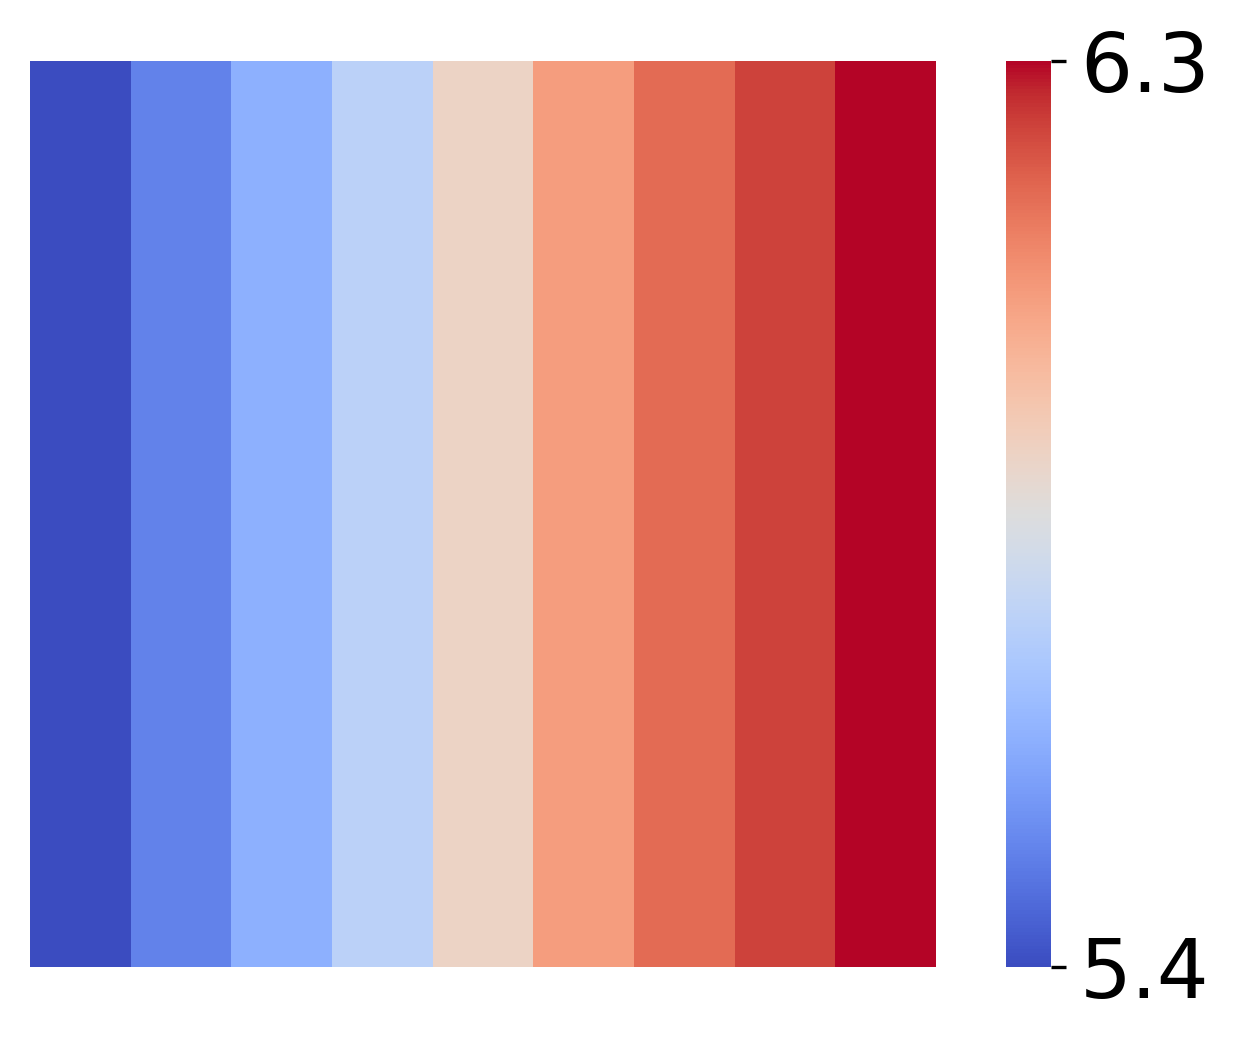

In [102]:
quantile_fig = plot_td_quantile_analysis_results(sim_obss, sim_participant_perturbations, effs, "Observes", col2name = "Belief", groups = None, num_bins =9, annot=False, square=square, axes_off=axes_off)

In [103]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_observes_NN_permuted.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_observes_NN_permuted.svg"))

## Panel E: Task 2 Rewards
### AD

In [104]:
mask = 'nomask'
iday = 3
day = 'day%d' %iday
with_nets = False
include_sleep = False
include_estimates = False
group = None

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/human_utils_project.py:1281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_day3['group'] = False


[[22.57142857 21.71428571 24.42857143 22.28571429 24.28571429 28.28571429
  26.42857143 28.28571429 31.71428571]
 [21.71428571 22.         25.85714286 26.85714286 28.28571429 26.71428571
  28.42857143 28.42857143 33.42857143]
 [24.33333333 28.33333333 23.83333333 27.83333333 28.66666667 31.
  28.66666667 30.5        28.        ]
 [22.57142857 23.14285714 24.28571429 25.85714286 25.57142857 26.42857143
  27.         28.57142857 30.57142857]
 [20.66666667 23.16666667 22.66666667 25.16666667 27.33333333 26.83333333
  29.5        29.5        29.33333333]
 [22.71428571 26.         26.71428571 28.28571429 29.28571429 24.57142857
  29.71428571 31.28571429 31.57142857]
 [21.83333333 24.16666667 26.16666667 23.83333333 27.16666667 25.66666667
  28.16666667 29.33333333 31.        ]
 [20.57142857 24.         25.42857143 23.85714286 24.14285714 24.71428571
  29.57142857 28.71428571 27.14285714]
 [23.         25.28571429 23.28571429 25.         23.14285714 25.28571429
  30.71428571 31.42857143 32.2

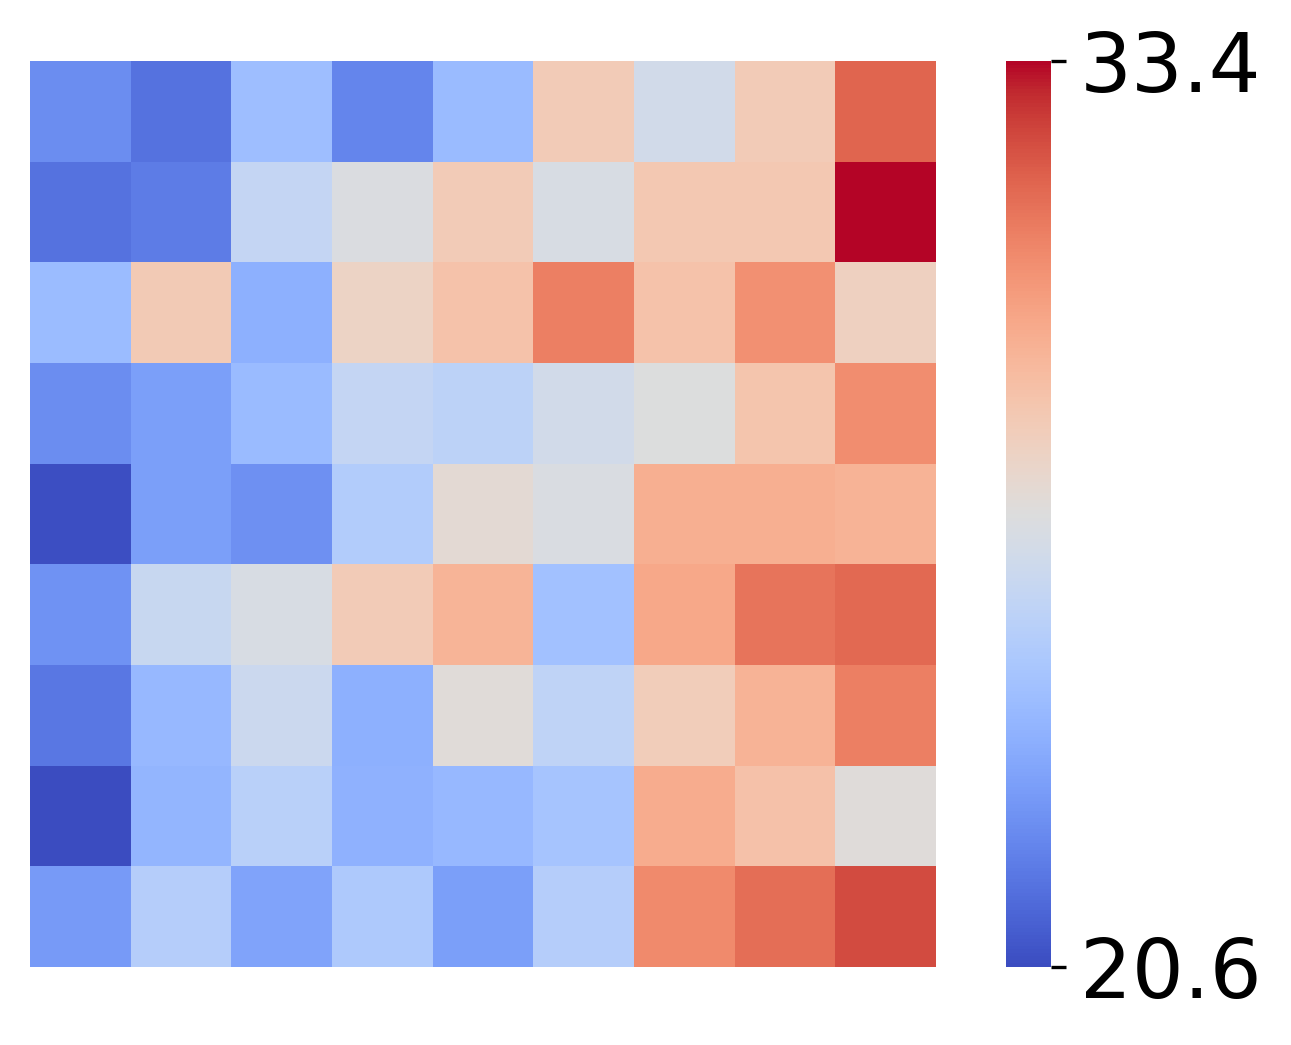

In [105]:
from human_utils_transdiagnostics import plot_td_quantile_analysis_results

quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Rewards", col2name="AD", groups = None, num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)


In [106]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_rewards_AD.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_rewards_AD.svg"))

### AD Residual

PC1 loadings:  [-0.99899698 -0.0447777 ]
PC2 loadings:  [ 0.0447777  -0.99899698]
Variance explained by PC1:  0.574419642744996
Variance explained by PC2:  0.42558035725500404
Flipped PC1 to enforce second component to be negative.
[[23.14285714 21.14285714 24.85714286 22.85714286 26.85714286 26.71428571
  27.14285714 27.28571429 33.14285714]
 [21.14285714 22.57142857 25.42857143 26.28571429 25.71428571 28.28571429
  27.71428571 29.42857143 32.        ]
 [24.33333333 28.33333333 23.83333333 27.83333333 28.66666667 31.
  28.66666667 30.5        28.        ]
 [22.57142857 24.         25.71428571 27.14285714 25.71428571 27.28571429
  26.28571429 28.42857143 31.28571429]
 [21.5        23.83333333 23.33333333 24.66666667 26.66666667 24.16666667
  30.16666667 29.33333333 28.5       ]
 [22.         24.57142857 24.71428571 27.42857143 29.71428571 26.
  29.85714286 31.57142857 31.57142857]
 [21.83333333 24.16666667 26.16666667 23.83333333 27.16666667 25.66666667
  28.16666667 29.33333333 31.   

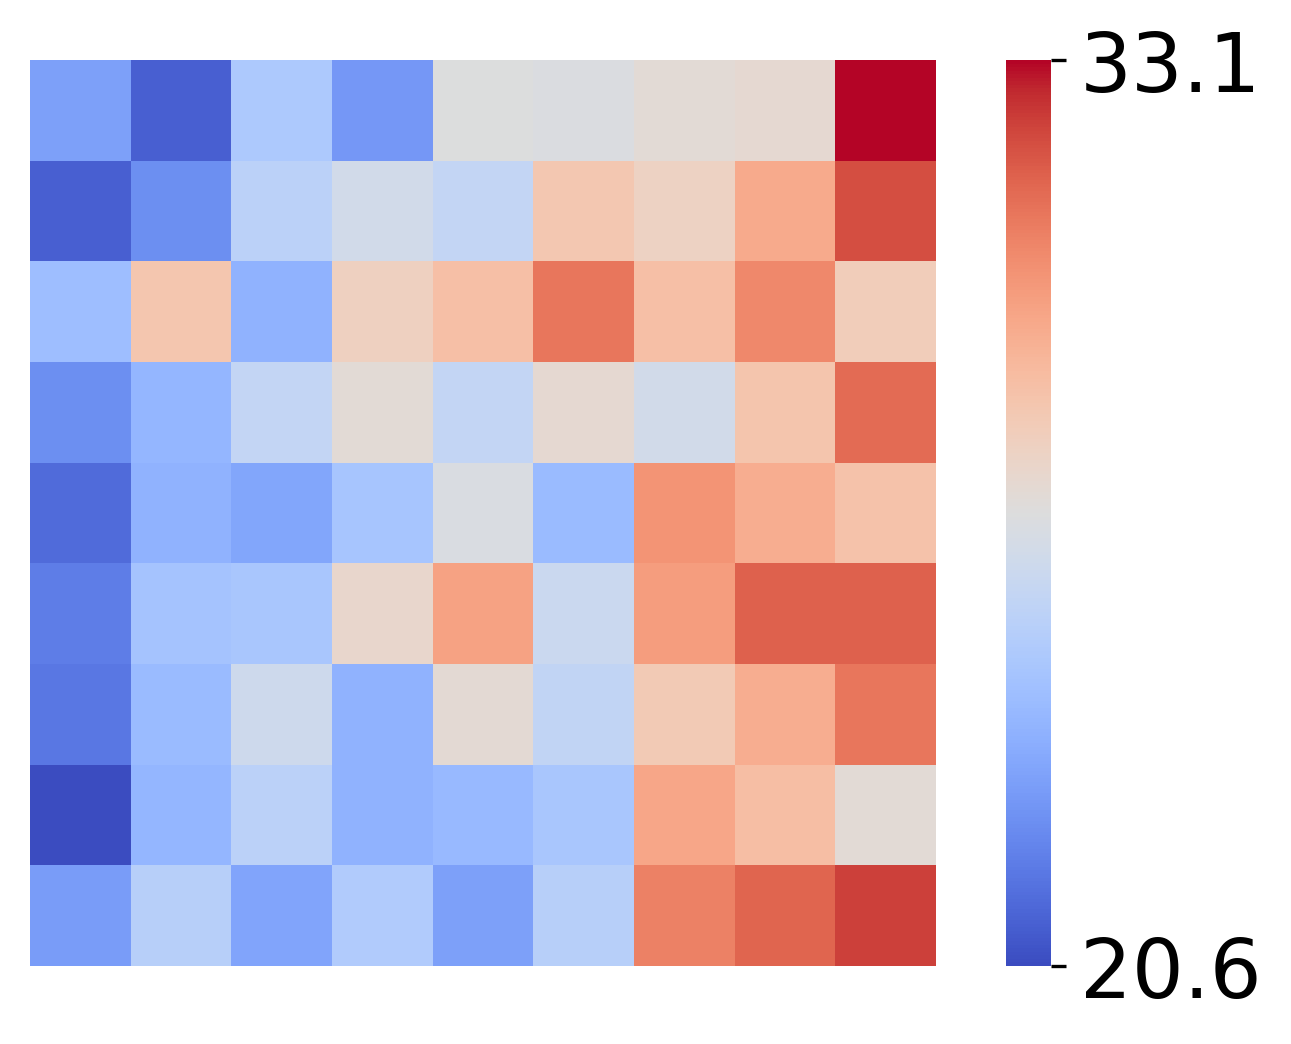

In [107]:
from human_utils_transdiagnostics import plot_td_quantile_analysis_results

quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), get_alternate_TD_representation(df['AD'], df['Compul'], method,-np.stack(df['n_sleeps'].values).sum(axis=1))[0], np.stack(df["effs"].values), "Rewards", col2name="AD", groups = None, num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Rewards", col2name="AD", groups = df["group"], num_bins=9, combine_groups = True, annot=False, flip_leastmost=True, square=square, axes_off=axes_off)
#quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), df['AD'], np.stack(df["effs"].values), "Rewards", col2name="AD", groups = None, num_bins=9, combine_groups = False, annot=False, flip_leastmost=True)


In [108]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_rewards_AD_residual.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_rewards_AD_residual.svg"))

### Compul

[[22.42857143 23.71428571 26.28571429 25.28571429 23.71428571 26.
  30.         28.14285714 32.71428571]
 [22.42857143 23.57142857 22.71428571 25.         25.14285714 27.28571429
  26.71428571 27.28571429 29.42857143]
 [20.16666667 25.16666667 26.66666667 28.5        30.66666667 30.16666667
  27.         29.33333333 33.5       ]
 [22.57142857 22.28571429 25.71428571 23.57142857 24.85714286 25.57142857
  26.28571429 31.14285714 28.14285714]
 [21.66666667 21.33333333 25.83333333 26.66666667 26.5        26.83333333
  29.33333333 26.         28.83333333]
 [25.14285714 25.14285714 26.14285714 25.71428571 26.42857143 26.42857143
  31.         31.14285714 31.71428571]
 [20.83333333 24.66666667 23.5        27.         27.83333333 27.
  28.66666667 28.         33.83333333]
 [22.42857143 25.14285714 24.57142857 23.71428571 27.28571429 25.57142857
  31.         31.85714286 28.42857143]
 [21.71428571 26.14285714 21.71428571 24.28571429 25.71428571 24.71428571
  28.         32.28571429 29.57142857]

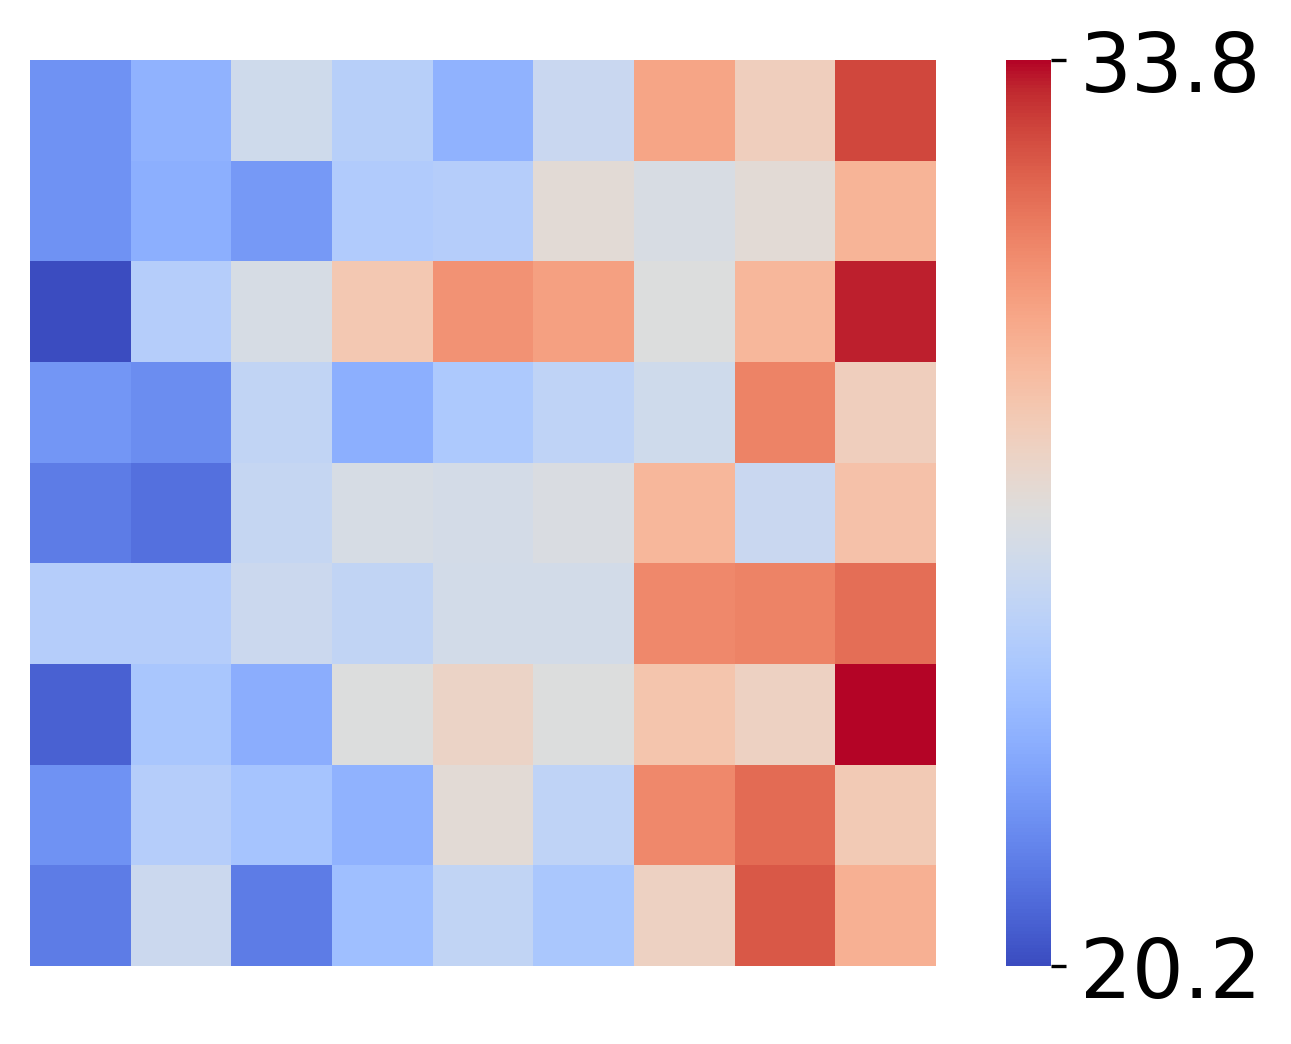

In [109]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), df['Compul'], np.stack(df["effs"].values), "Rewards", col2name = "Compul", groups = None, num_bins =9, combine_groups = True, annot=False, square=square, axes_off=axes_off)

In [110]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_rewards_Compul.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_rewards_Compul.svg"))

### Compul Residual

PC1 loadings:  [-0.99899698 -0.0447777 ]
PC2 loadings:  [ 0.0447777  -0.99899698]
Variance explained by PC1:  0.574419642744996
Variance explained by PC2:  0.42558035725500404
Flipped PC1 to enforce second component to be negative.
[[21.71428571 26.14285714 21.71428571 24.28571429 25.71428571 24.71428571
  28.         32.28571429 29.57142857]
 [22.42857143 25.14285714 24.57142857 23.71428571 27.28571429 25.57142857
  31.         31.85714286 28.42857143]
 [20.83333333 24.66666667 23.5        27.         27.83333333 27.
  28.66666667 28.         33.83333333]
 [25.14285714 25.14285714 26.14285714 25.71428571 26.42857143 26.42857143
  31.         31.14285714 31.71428571]
 [23.         21.66666667 25.16666667 26.33333333 25.16666667 27.16666667
  27.33333333 27.5        30.        ]
 [21.28571429 20.42857143 25.71428571 23.28571429 26.28571429 26.
  28.14285714 30.28571429 28.        ]
 [20.5        26.16666667 26.66666667 29.16666667 27.66666667 30.5
  25.5        28.         32.66666667]


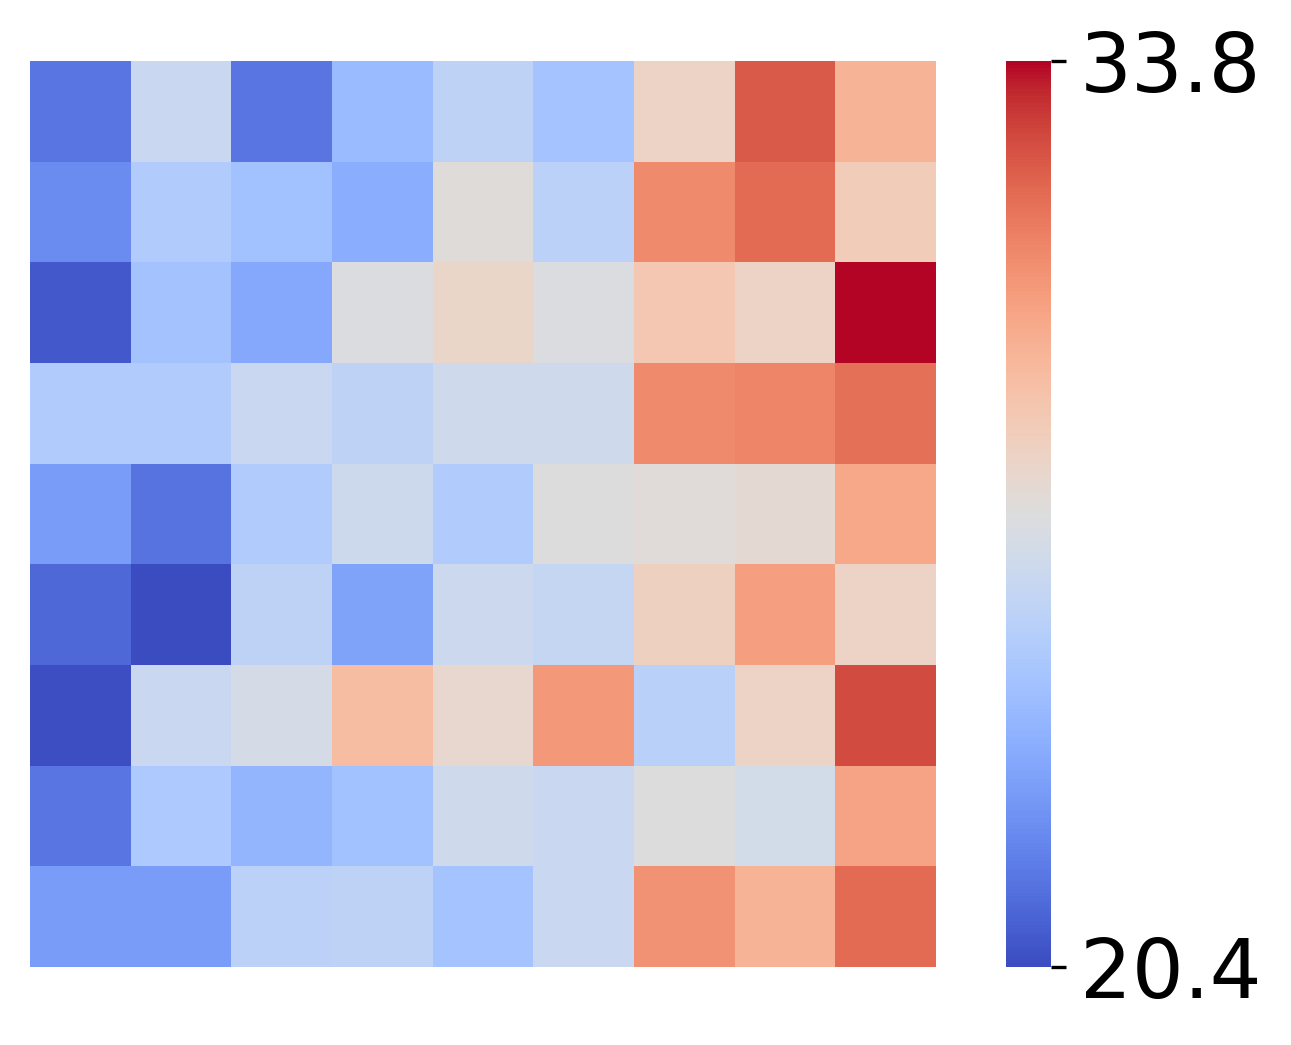

In [111]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), get_alternate_TD_representation(df['AD'], df['Compul'], method, -np.stack(df['n_sleeps'].values).sum(axis=1))[1], np.stack(df["effs"].values), "Rewards", col2name = "Compul", groups = None, num_bins =9, combine_groups = True, annot=False, square=square, axes_off=axes_off)

In [112]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_rewards_Compul_residual.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_rewards_Compul_residual.svg"))

### SW

[[22.28571429 23.28571429 26.57142857 25.14285714 22.         26.71428571
  27.42857143 26.28571429 34.28571429]
 [18.71428571 22.42857143 25.85714286 24.42857143 23.71428571 27.85714286
  27.85714286 30.57142857 30.28571429]
 [23.         25.33333333 25.33333333 26.33333333 26.5        26.
  25.66666667 29.83333333 29.16666667]
 [23.         23.57142857 27.14285714 26.         25.28571429 28.
  28.71428571 29.57142857 30.        ]
 [21.5        23.5        22.         24.83333333 29.16666667 27.16666667
  28.5        24.83333333 29.5       ]
 [24.42857143 27.28571429 24.28571429 26.         25.71428571 26.14285714
  32.71428571 31.28571429 31.42857143]
 [23.         25.33333333 24.33333333 27.83333333 30.         24.66666667
  31.66666667 32.33333333 29.83333333]
 [23.14285714 24.14285714 23.         23.57142857 27.42857143 24.42857143
  29.71428571 27.28571429 29.28571429]
 [21.         22.71428571 24.         25.14285714 28.42857143 27.71428571
  25.85714286 33.71428571 31.28571429]

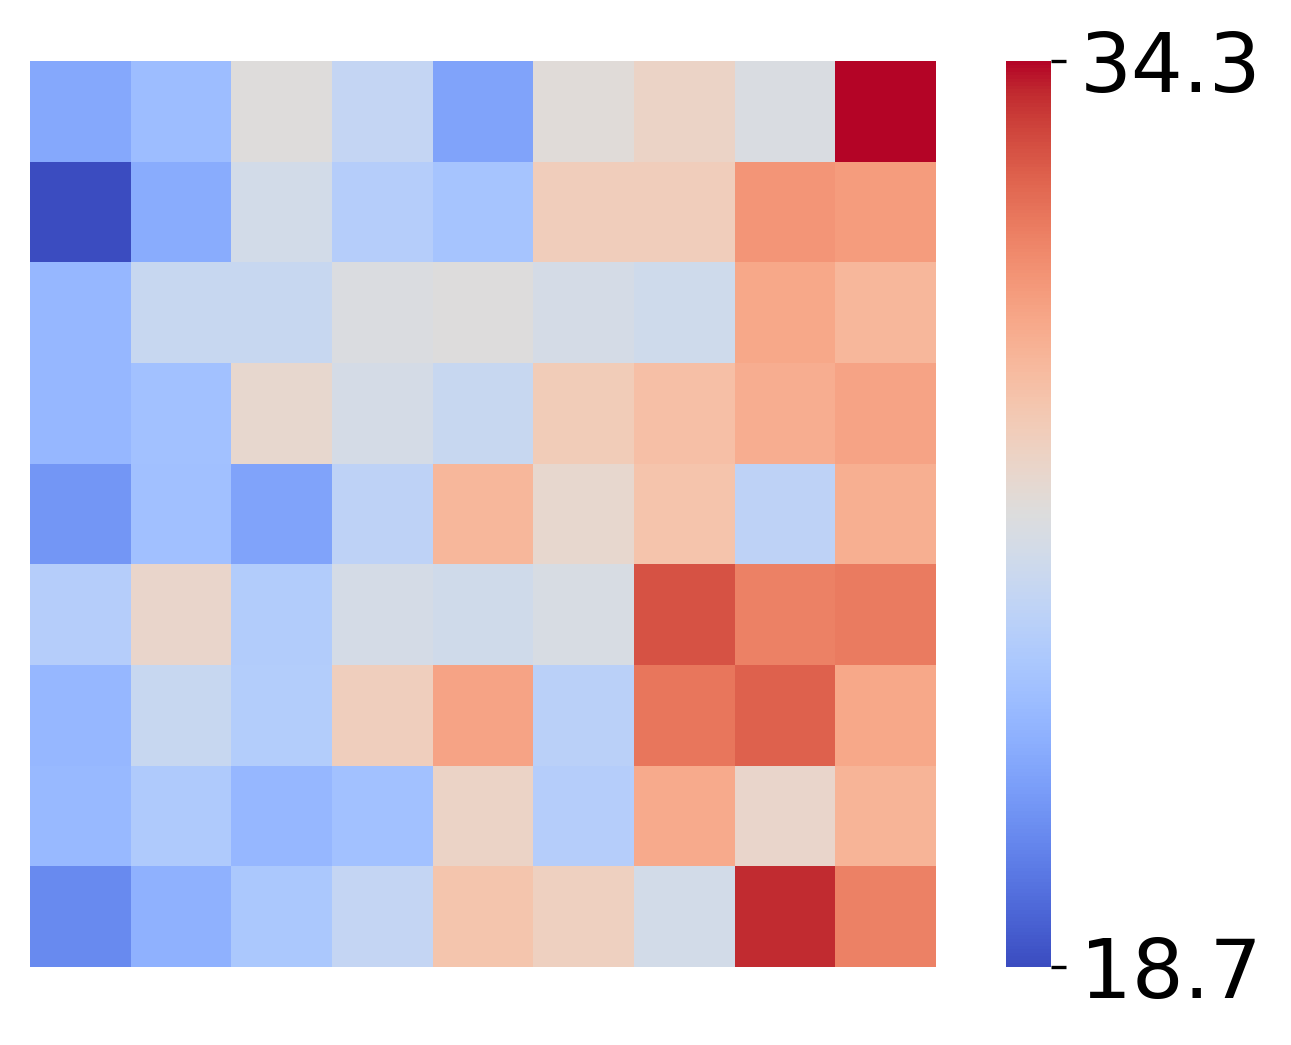

In [113]:
quantile_fig = plot_td_quantile_analysis_results(np.stack(df['rewards_tallies'].values).squeeze(), df['SW'], np.stack(df["effs"].values), "Observes", col2name = "SW", groups = None, num_bins =9, combine_groups = True, annot=False, square=square, axes_off=axes_off)

In [114]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_rewards_SW.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_rewards_SW.svg"))

### Trait-level Simulations

In [115]:
from settings_anal import levc_human_ape_models as ape_models
from settings_anal import trait_simulated_participants_folder_t2 as simulated_participants_folder
from settings_anal import trait_sim_timestamp_t2 as sim_timestamp
from settings_anal import trait_sim_mag_perturbation as mag_perturbation
from settings_anal import trait_sim_bias_perturbation as bias_perturbation
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models

effs = np.arange(0, 1.01, 0.125)

sim_rewss, sim_obss, sim_sleepss = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)
sim_sleepss = sim_sleepss.mean(axis=0)

## flip to correct for switching from tau to efficacy
sim_obss = np.flip(sim_obss.T,axis=1)
sim_sleepss = np.flip(sim_sleepss.T, axis=1)
sim_rewss = np.flip(sim_rewss.T, axis=1)

with open(os.path.join('data', 'sim_perturbed_participants', 'levc', 'sim', 'mag%dbias%d'%(mag_perturbation*100, bias_perturbation*100), '%s_simulated_participant_perturbations_sim_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

current mag perturbation 0.5 bias -0.8
[[25.42488235 26.73547059 28.22176471 29.546      30.93005882 31.80241176
  32.26264706 32.39994118 32.56141176]
 [26.08258824 27.37358824 28.66247059 29.97488235 31.30735294 32.20405882
  32.59570588 32.778      32.82847059]
 [26.08775    27.36475    28.6005     29.921625   31.286      32.4170625
  32.7979375  32.9330625  33.066625  ]
 [26.06276471 27.31317647 28.54764706 29.89929412 31.23070588 32.33170588
  32.88982353 33.00264706 33.15111765]
 [25.9579375  27.253125   28.477375   29.8355625  31.2093125  32.308625
  32.83575    33.0209375  33.2095625 ]
 [25.89917647 27.17405882 28.51882353 29.80005882 31.12882353 32.38064706
  32.98117647 33.14558824 33.26547059]
 [25.799875   27.089125   28.4604375  29.6679375  31.092875   32.384
  33.05525    33.32325    33.3794375 ]
 [25.64211765 26.86311765 28.09917647 29.40617647 30.831      32.23258824
  33.04770588 33.32552941 33.44335294]
 [25.16676471 26.42335294 27.68988235 29.10582353 30.57870588 32.

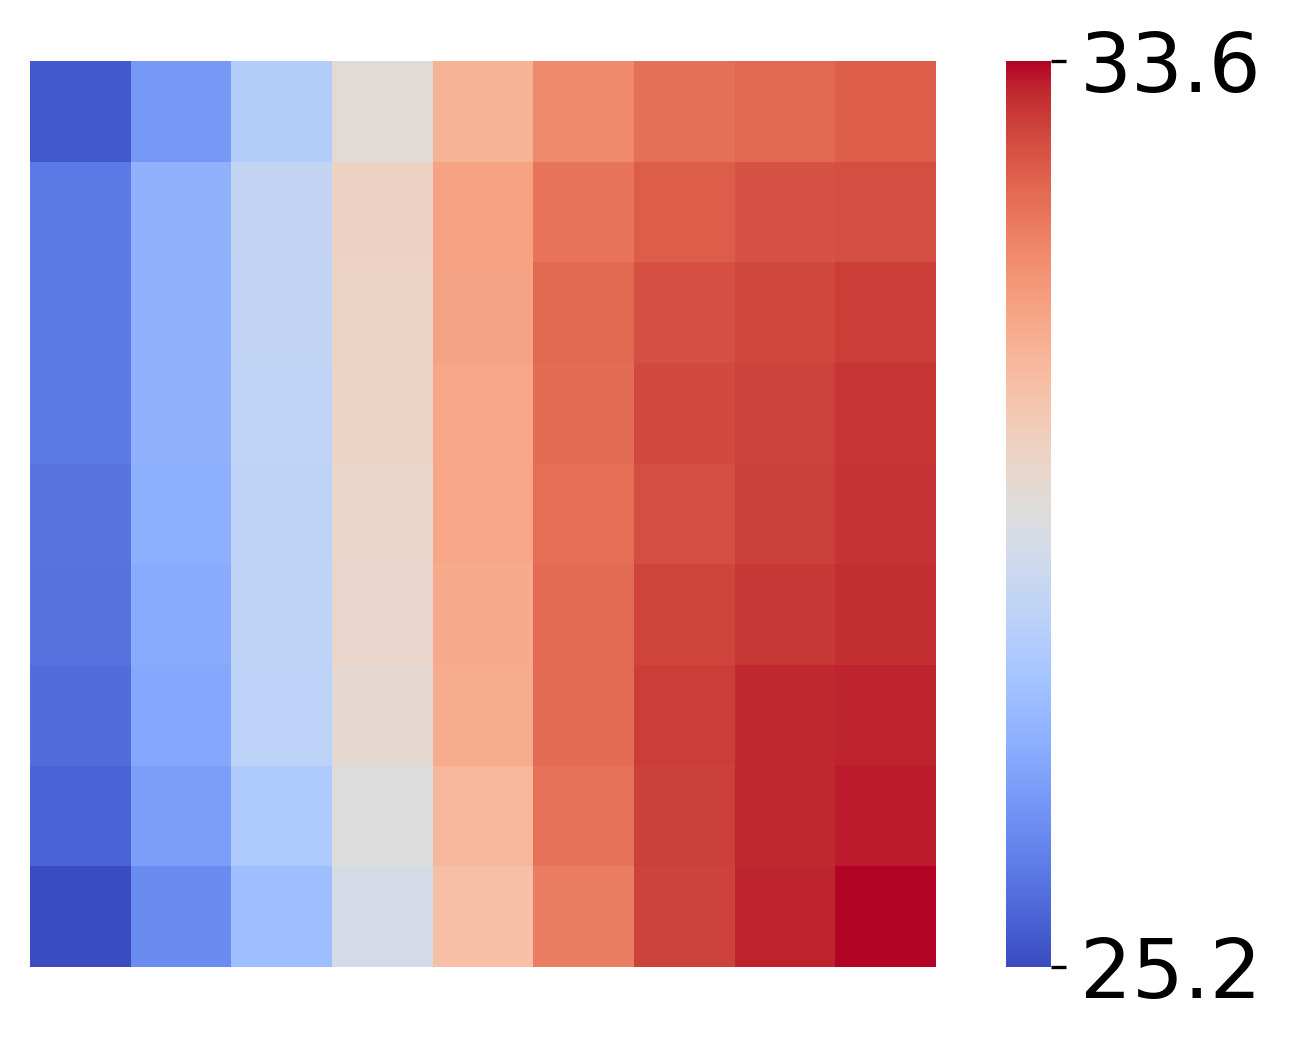

In [116]:
print("current mag perturbation", mag_perturbation, "bias", bias_perturbation)
quantile_fig = plot_td_quantile_analysis_results(sim_rewss, sim_participant_perturbations, effs, "Observes", col2name = "Belief", groups = None, num_bins =9, annot=False, square=square, axes_off=axes_off)

In [117]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_rewards_NN.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_rewards_NN.svg"))

### Permuted

In [118]:
from human_utils_behavioral_analysis import load_simulated_participants_across_models
from settings_anal import levc_human_ape_models as ape_models
from settings_anal import zeros_simulated_participants_folder_t2 as simulated_participants_folder
from settings_anal import zeros_sim_timestamp_t2 as sim_timestamp
from settings_anal import trait_sim_mag_perturbation as mag_perturbation
from settings_anal import trait_sim_bias_perturbation as bias_perturbation

effs = np.arange(0, 1.01, 0.125)

sim_rewss, sim_obss, sim_sleepss = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)
sim_sleepss = sim_sleepss.mean(axis=0)

## flip to correct for switching from tau to efficacy
sim_obss = np.flip(sim_obss.T,axis=1)
sim_sleepss = np.flip(sim_sleepss.T, axis=1)
sim_rewss = np.flip(sim_rewss.T, axis=1)

with open(os.path.join('data', 'sim_perturbed_participants', 'levc', 'nostruc', 'mag%dbias%d'%(mag_perturbation*100, bias_perturbation*100), '%s_simulated_participant_perturbations_nostruc_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

[[26.00169333 27.29667333 28.58760667 29.87141333 31.22623333 32.35754
  32.90988667 33.0869     33.18137333]
 [26.00169333 27.29667333 28.58760667 29.87141333 31.22623333 32.35754
  32.90988667 33.0869     33.18137333]
 [26.00169333 27.29667333 28.58760667 29.87141333 31.22623333 32.35754
  32.90988667 33.0869     33.18137333]
 [26.00169333 27.29667333 28.58760667 29.87141333 31.22623333 32.35754
  32.90988667 33.0869     33.18137333]
 [26.00169333 27.29667333 28.58760667 29.87141333 31.22623333 32.35754
  32.90988667 33.0869     33.18137333]
 [26.00169333 27.29667333 28.58760667 29.87141333 31.22623333 32.35754
  32.90988667 33.0869     33.18137333]
 [26.00169333 27.29667333 28.58760667 29.87141333 31.22623333 32.35754
  32.90988667 33.0869     33.18137333]
 [26.00169333 27.29667333 28.58760667 29.87141333 31.22623333 32.35754
  32.90988667 33.0869     33.18137333]
 [26.00169333 27.29667333 28.58760667 29.87141333 31.22623333 32.35754
  32.90988667 33.0869     33.18137333]]


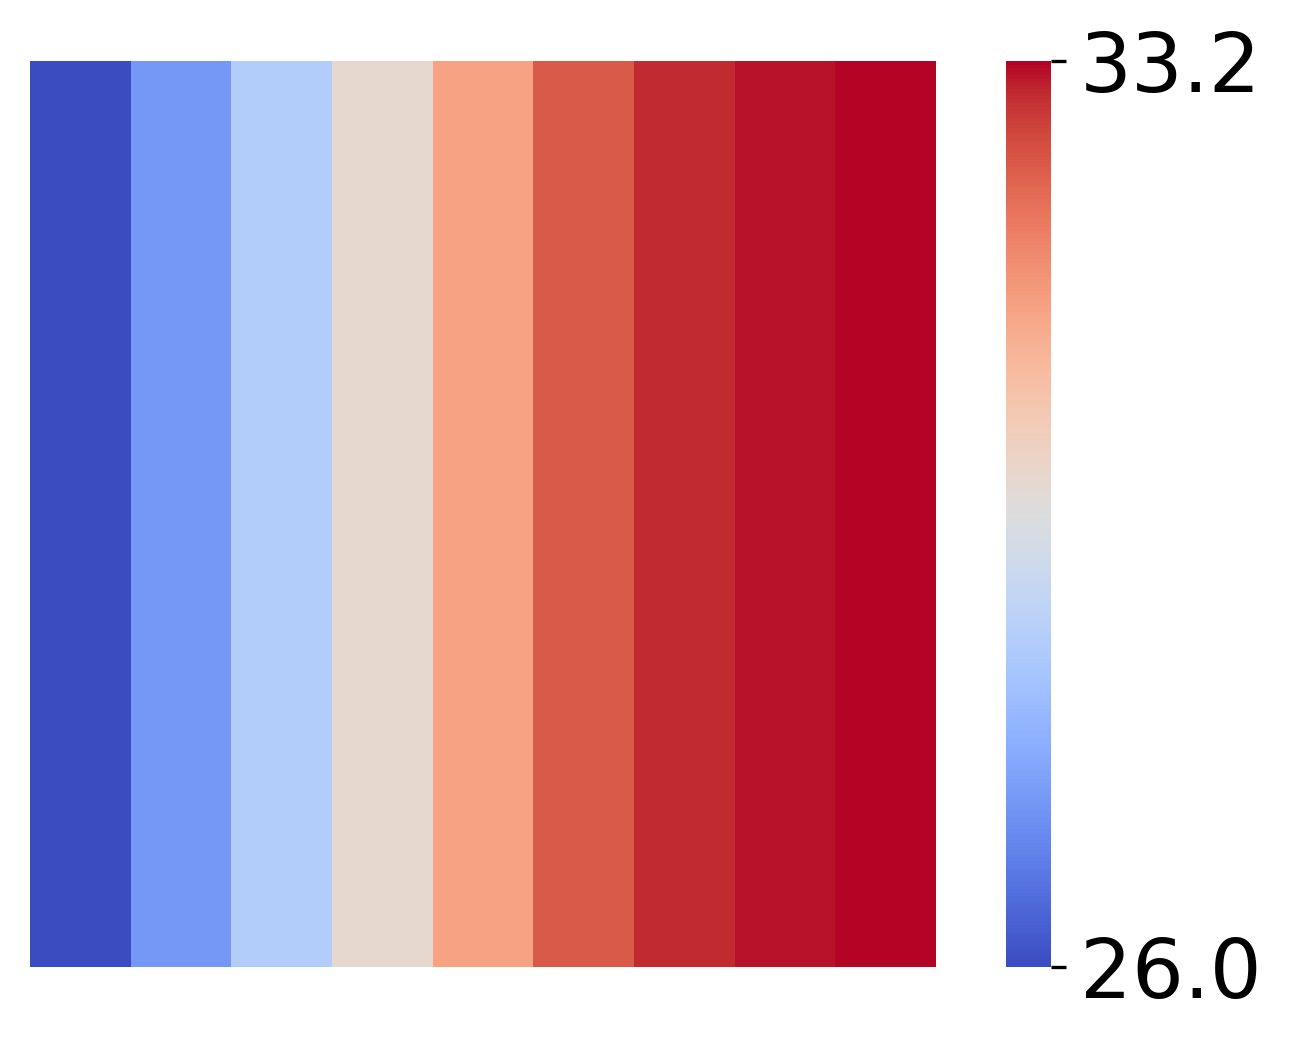

In [119]:
quantile_fig = plot_td_quantile_analysis_results(sim_rewss, sim_participant_perturbations, effs, "Observes", col2name = "Belief", groups = None, num_bins =9, annot=False, square=True, axes_off=True)

In [120]:
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_rewards_NN_permuted.png"))
quantile_fig.savefig(os.path.join(analysis_folder, "task2_td_quantile_rewards_NN_permuted.svg"))

## Panel F: Aggregated Similarities including unpermuted

In [121]:
from human_utils_behavioral_analysis import upper_tri_masking
from human_utils_transdiagnostics import compute_quantile_analysis
from sklearn.utils import resample

def combine_group_td_quantile_matrices(values, effs, tds, groups, num_bins=9, flip_leastmost = False, groupmins = None, groupmaxes = None, data_bins = None):

    if data_bins is None:
        data_bins = (None, None)
    
    quantile_matrix_g1, bins_g1 = compute_quantile_analysis(np.stack(values[~groups].values), tds[~groups], np.stack(effs[~groups].values),
                    num_bins=num_bins, flip_leastmost=flip_leastmost, bins=data_bins[0], take_quantile_on_col1=False)
    quantile_matrix_g2, bins_g2 = compute_quantile_analysis(np.stack(values[groups].values), tds[groups], np.stack(effs[groups].values), 
                    num_bins=num_bins, flip_leastmost = flip_leastmost, bins=data_bins[1], take_quantile_on_col1=False)
    
    if groupmins is None:
        groupmins = [np.nanmin(quantile_matrix_g1), np.nanmin(quantile_matrix_g2)]
    if groupmaxes is None:
        groupmaxes = [np.nanmax(quantile_matrix_g1), np.nanmax(quantile_matrix_g2)] 
    quantile_matrix_g1 = (quantile_matrix_g1 - groupmins[0])/(groupmaxes[0] - groupmins[0])
    quantile_matrix_g2 = (quantile_matrix_g2 - groupmins[1])/(groupmaxes[1] - groupmins[1])

    quantile_matrix = (~groups).sum() / len(df) * quantile_matrix_g1 + (groups).sum() / len(df) * quantile_matrix_g2

    return quantile_matrix, (bins_g1, bins_g2)

def compute_cosine_similarity(a, b, upper_tri = True, simmetric = simmetric):
    from sklearn.metrics.pairwise import cosine_similarity
    if upper_tri:
        a = upper_tri_masking(a)
        b = upper_tri_masking(b)
    if simmetric == 'cossim':
        sim = cosine_similarity(a.reshape((1,-1)), b.reshape((1,-1)))[0][0]
    elif simmetric == 'corr':
        sim = pearsonr(a.reshape((-1,)), b.reshape((-1,)))[0]
    return sim

def compute_resampled_td_cosine_similarity(item, groups,  item_effs, td, comparison, sim_participant_perturbations, effs = np.arange(0, 1.01, 0.125), n_iterations = 100, flip_leastmost=False, datamean = None, data_bins=None, meancenter = meancenter):

    #print(np.where(groups == False)[0].shape, np.where(groups == True)[0].shape)
    #print(item[np.where(groups == False)[0]], item[np.where(groups == True)[0]])

    #groupmins = [np.stack(item[np.where(groups == group)[0]].values).min() for group in [False, True]]
    #groupmaxes = [np.stack(item[np.where(groups == group)[0]].values).max() for group in [True, False]]

    data_bins=None
    #datamean=None

    bootstrapped_cos_sims = []
    for _ in range(n_iterations):
        #indicesA = item.index[np.where(groups == False)[0]]
        #indicesB = item.index[np.where(groups == True)[0]]
        indicesA = item.index

        bootstrapped_indicesA = resample(indicesA, replace=True, n_samples=len(indicesA))
        # bootstrapped_indicesB = resample(indicesB, replace=False, n_samples=len(indicesB))
        # bootstrapped_indices = np.sort(np.concatenate((bootstrapped_indicesA, bootstrapped_indicesB)))

        # ## find corresponding integer indices
        # bootstrapped_integer_indices = np.array([np.where(item.index == index)[0][0] for index in bootstrapped_indices])
        #print("check",bootstrapped_integer_indices)

        # print("td", td)
        # print("td shape", td.shape)
        #print("item bootstrap shape", item.loc[bootstrapped_indices].shape)

        #bootstrapped_indices_comparison = resample(np.arange(len(comparison)), replace=True, n_samples=len(comparison))

        #bootstrapped_data_corr, bootstrapped_data_pvs = combine_group_correlation_matrices(item.loc[bootstrapped_indices], df.loc[bootstrapped_indices, 'effs_day2'], df.loc[bootstrapped_indices, 'group_day2'].values)
        #bootstrapped_data_corr, bootstrapped_data_pvs = combine_group_correlation_matrices(item.loc[bootstrapped_indices], item_effs.loc[bootstrapped_indices], groups.loc[bootstrapped_indices], covar=covar_subindexed, effs_covar=effs_covar_subindexed, values2=item2_subindexed, effs2 = item2_effs_subindexed)
        #bootstrapped_data_tds, _ = combine_group_td_quantile_matrices(item.loc[bootstrapped_indices], item_effs.loc[bootstrapped_indices], td[bootstrapped_integer_indices], groups.loc[bootstrapped_indices].values, num_bins=9, flip_leastmost=flip_leastmost, data_bins=data_bins)
        #bootstrapped_comp_corr, bootstrapped_comp_pvs = compute_2D_correlation_matrices(comparison, comparison2, effs, effs)
        print(bootstrapped_indicesA)
        bootstrapped_data_tds, _ = compute_quantile_analysis(np.stack(item.loc[bootstrapped_indicesA].values), td, np.stack(item_effs.loc[bootstrapped_indicesA].values), num_bins=9)
        bootstrapped_sim_tds, _ = compute_quantile_analysis(comparison, sim_participant_perturbations, effs, num_bins=9, take_quantile_on_col1=False)

        ## min-max norm of sim_tds
        # bootstrapped_data_tds = (bootstrapped_data_tds - bootstrapped_data_tds.min())/(bootstrapped_data_tds.max() - bootstrapped_data_tds.min())
        # ## min-max norm of sim_tds
        bootstrapped_sim_tds = (bootstrapped_sim_tds - bootstrapped_sim_tds.min())/(bootstrapped_sim_tds.max() - bootstrapped_sim_tds.min())

        ## MEAN CENTERED
        if (datamean is None and "center" in meancenter) or meancenter == "thiscenter":
            bootstrapped_data_tds = bootstrapped_data_tds - bootstrapped_data_tds.mean()
        elif meancenter == "datacenter":
            bootstrapped_data_tds = bootstrapped_data_tds - datamean
        # bootstrapped_sim_tds = bootstrapped_sim_tds - bootstrapped_sim_tds.mean()

        bootstrapped_cos_sim = compute_cosine_similarity(bootstrapped_data_tds, bootstrapped_sim_tds, upper_tri = False)
        bootstrapped_cos_sims.append(bootstrapped_cos_sim)
    return bootstrapped_cos_sims

def compute_resampled_td_cosine_similarity_difference(item, groups,  item_effs, td, comparison, sim_participant_perturbations, comparison2, sim_participant_perturbations2, effs = np.arange(0, 1.01, 0.125), n_iterations = 100, flip_leastmost=False, datamean=None, data_bins=None, td_name=None, item_name=None, difftype=difftype):

    data_bins=None
    datamean=None

    bootstrapped_cos_sims = []
    for i in range(n_iterations):
        # indicesA = item.index[np.where(groups == False)[0]]
        # indicesB = item.index[np.where(groups == True)[0]]
        indicesA = item.index

        bootstrapped_indicesA = resample(indicesA, replace=True, n_samples=len(indicesA))
        # #bootstrapped_indicesB = resample(indicesB, replace=False, n_samples=len(indicesB))
        # bootstrapped_indices = np.sort(np.concatenate((bootstrapped_indicesA, bootstrapped_indicesB)))

        ## find corresponding integer indices
        #bootstrapped_integer_indices = np.array([np.where(item.index == index)[0][0] for index in bootstrapped_indices])
        #print("check",bootstrapped_integer_indices)

        #bootstrapped_indices_comparison = resample(np.arange(len(comparison)), replace=True, n_samples=len(comparison))

        #bootstrapped_data_corr, bootstrapped_data_pvs = combine_group_correlation_matrices(item.loc[bootstrapped_indices], df.loc[bootstrapped_indices, 'effs_day2'], df.loc[bootstrapped_indices, 'group_day2'].values)
        #bootstrapped_data_corr, bootstrapped_data_pvs = combine_group_correlation_matrices(item.loc[bootstrapped_indices], item_effs.loc[bootstrapped_indices], groups.loc[bootstrapped_indices], covar=covar_subindexed, effs_covar=effs_covar_subindexed, values2=item2_subindexed, effs2 = item2_effs_subindexed)
        #bootstrapped_data_tds, _ = combine_group_td_quantile_matrices(item.loc[bootstrapped_indices], item_effs.loc[bootstrapped_indices], td[bootstrapped_integer_indices], groups.loc[bootstrapped_indices].values, num_bins=9, flip_leastmost=flip_leastmost, data_bins=data_bins)
        #bootstrapped_comp_corr, bootstrapped_comp_pvs = compute_2D_correlation_matrices(comparison, comparison2, effs, effs)
        bootstrapped_data_tds, _ = compute_quantile_analysis(np.stack(item.loc[bootstrapped_indicesA].values), td, np.stack(item_effs.loc[bootstrapped_indicesA].values), num_bins=9)
        bootstrapped_sim_tds, _ = compute_quantile_analysis(comparison, sim_participant_perturbations, effs, num_bins=9, take_quantile_on_col1=False)
        bootstrapped_sim_tds2, _ = compute_quantile_analysis(comparison2, sim_participant_perturbations2, effs, num_bins=9, take_quantile_on_col1=False)

        ## min-max norm of sim_tds
        # bootstrapped_data_tds = (bootstrapped_data_tds - bootstrapped_data_tds.min())/(bootstrapped_data_tds.max() - bootstrapped_data_tds.min())
        # ## min-max norm of sim_tds
        bootstrapped_sim_tds = (bootstrapped_sim_tds - bootstrapped_sim_tds.min())/(bootstrapped_sim_tds.max() - bootstrapped_sim_tds.min())
        bootstrapped_sim_tds2 = (bootstrapped_sim_tds2 - bootstrapped_sim_tds2.min())/(bootstrapped_sim_tds2.max() - bootstrapped_sim_tds2.min())

        # fig = plot_td_quantile_analysis_results(np.stack(item.loc[bootstrapped_indices].values).squeeze(), td[bootstrapped_integer_indices], np.stack(item_effs.loc[bootstrapped_indices].values), item_name, col2name=td_name, groups =  groups.loc[bootstrapped_indices].values, num_bins=9, combine_groups = True, annot=False, flip_leastmost=False, square=square, axes_off=False)
        # os.makedirs(os.path.join(analysis_folder, 'bootstraps', td_name, item_name), exist_ok=True)
        # fig.savefig(os.path.join(analysis_folder, 'bootstraps', td_name, item_name, "td_quantile_%s_%s_BOOTSTRAP%d.png" %(td_name, item_name, i)))

        ## MEAN CENTER
        if (datamean is None and "center" in meancenter) or meancenter == "thiscenter":
            bootstrapped_data_tds = bootstrapped_data_tds - bootstrapped_data_tds.mean()
        elif meancenter == "datacenter":
            bootstrapped_data_tds = bootstrapped_data_tds - datamean
        # bootstrapped_sim_tds = bootstrapped_sim_tds - bootstrapped_sim_tds.mean()
        # bootstrapped_sim_tds2 = bootstrapped_sim_tds2 - bootstrapped_sim_tds2.mean()

        bootstrapped_cos_sim = compute_cosine_similarity(bootstrapped_data_tds, bootstrapped_sim_tds, upper_tri = False)
        bootstrapped_cos_sim2 = compute_cosine_similarity(bootstrapped_data_tds, bootstrapped_sim_tds2, upper_tri = False)
        if difftype == "diff":
            bootstrapped_cos_sims.append(bootstrapped_cos_sim - bootstrapped_cos_sim2)
        elif difftype == "logdiff":
            bootstrapped_cos_sims.append(np.log(bootstrapped_cos_sim) - np.log(bootstrapped_cos_sim2))
        elif difftype == "ratio":
            bootstrapped_cos_sims.append(bootstrapped_cos_sim / bootstrapped_cos_sim2)
        elif difftype == "frac_rem":
            bootstrapped_cos_sims.append((bootstrapped_cos_sim - bootstrapped_cos_sim2) / (1 - bootstrapped_cos_sim2))
        else:
            assert False, "invalid difftype"
    return bootstrapped_cos_sims

In [122]:
%%capture

rows = []

n_iterations=100

### TASK 1
mask = 'nomask'
iday = 2
day = 'day%d' %iday
with_nets = False
include_sleep = False
include_estimates = False
group = None

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_anal import pepe_human_ape_models as ape_models
from settings_anal import trait_simulated_participants_folder_t1 as simulated_participants_folder
from settings_anal import trait_sim_timestamp_t1 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)

sim_rewss, sim_obss, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)

## flip to correct for switching from tau to efficacy
sim_obss = np.flip(sim_obss.T,axis=1)
sim_rewss = np.flip(sim_rewss.T, axis=1)

original_mag_perturbation = 1
with open(os.path.join('data', 'sim_perturbed_participants', 'pepe', 'sim', 'mag%d'%(original_mag_perturbation*100), '%s_simulated_participant_perturbations_sim_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

## ESTIMATES
sim_estss = (np.tile(np.arange(0, 1.01, 0.125), (len(sim_participant_perturbations),1)).T + sim_participant_perturbations).T

## LOAD UNPERTURBED
from human_utils_behavioral_analysis import compute_2D_correlation, load_simulated_participants_across_models
from settings_anal import pepe_human_ape_models as ape_models
from settings_anal import zeros_simulated_participants_folder_t1 as simulated_participants_folder
from settings_anal import zeros_sim_timestamp_t1 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)

zeros_rewss, zeros_obss, _ = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp)
zeros_rewss = zeros_rewss.mean(axis=0)
zeros_obss = zeros_obss.mean(axis=0)

## flip to correct for switching from tau to efficacy
zeros_obss = np.flip(zeros_obss.T,axis=1)
zeros_rewss = np.flip(zeros_rewss.T, axis=1)

original_mag_perturbation = 1
with open(os.path.join('data', 'sim_perturbed_participants', 'pepe', 'nostruc', 'mag%d'%(original_mag_perturbation*100), '%s_simulated_participant_perturbations_nostruc_mag.pkl' %sim_timestamp), 'rb') as f:
    zeros_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

## ESTIMATES
zeros_estss = (np.tile(np.arange(0, 1.01, 0.125), (len(zeros_participant_perturbations),1)).T + zeros_participant_perturbations).T

comparisons_names = ["Trait", "Zeros"]
comparisons_perturbations = [sim_participant_perturbations, zeros_participant_perturbations]

for item_name, item, comparisons, in zip(['Rews', 'Obs', 'Ests'], 
            [df['rewards_tallies'], df['n_observes'], df['efficacy_estimates']], 
            [[sim_rewss, zeros_rewss], [sim_obss, zeros_obss] , [sim_estss, zeros_estss]],
            ):
    for td_name in ['PC1', 'PC2', 'Compul', 'AD', 'SW']:
        print(item_name, td_name)
        for comparison_name, comparison, comparison_perturbations in zip(comparisons_names, comparisons, comparisons_perturbations):
            if td_name == 'PC1':
                td = get_alternate_TD_representation(df['AD'], df['Compul'], method, np.stack(df['n_observes'].values).sum(axis=1))[0]
            elif td_name == 'PC2':
                td = get_alternate_TD_representation(df['AD'], df['Compul'], method, np.stack(df['n_observes'].values).sum(axis=1))[1]
            else:
                td = df[td_name]
            if td_name == 'AD':
                flip_leastmost = False
            else:
                flip_leastmost = False
            print(item, td)
            data_tds, data_bins =  compute_quantile_analysis(np.stack(item.values), td, np.stack(df['effs'].values), num_bins=9)

            sim_tds, _ = compute_quantile_analysis(comparison, comparison_perturbations, effs, num_bins=9, take_quantile_on_col1=False, )
            sim_tds = (sim_tds - sim_tds.min())/(sim_tds.max() - sim_tds.min())

            ## MEAN CENTER
            print(data_tds)
            datamean = data_tds.mean()
            if "center" in meancenter:
                data_tds = data_tds - datamean
                sim_tds = sim_tds - sim_tds.mean()

            print(data_tds, sim_tds)
            cos_sim = compute_cosine_similarity(data_tds, sim_tds, upper_tri=False)

            bootstrapped_cos_sims = compute_resampled_td_cosine_similarity(item, df['group'], df['effs'], td, comparison, comparison_perturbations, n_iterations=n_iterations, flip_leastmost=flip_leastmost, datamean = datamean, data_bins=data_bins)
            ci = pd.Series(bootstrapped_cos_sims).quantile([0.025, 0.975])
            rows.append({"task": "T1", "Transdiagnostic": td_name, "item": item_name, "Comparison": comparison_name, "Cosine Similarity": cos_sim, "Lower": ci.iloc[0], "Upper": ci.iloc[1]})

for item_name, item, comparisons, in zip(['Rews', 'Obs', 'Ests'], 
            [df['rewards_tallies'], df['n_observes'], df['efficacy_estimates']], 
            [[sim_rewss, zeros_rewss], [sim_obss, zeros_obss] , [sim_estss, zeros_estss],],
            ):
    for td_name in ['PC1', 'PC2', 'Compul', 'AD', 'SW']:
        print(item_name, td_name)
        for comparison_name, comparison, comparison_perturbations in zip(comparisons_names, comparisons, comparisons_perturbations):
            if td_name == 'PC1':
                td = get_alternate_TD_representation(df['AD'], df['Compul'], method, np.stack(df['n_observes'].values).sum(axis=1))[0]
            elif td_name == 'PC2':
                td = get_alternate_TD_representation(df['AD'], df['Compul'], method, np.stack(df['n_observes'].values).sum(axis=1))[1]
            else:
                td = df[td_name]
        if td_name == 'AD':
            #flip_leastmost = True
            flip_leastmost = False
        else:
            flip_leastmost = False
        data_tds, data_bins =  compute_quantile_analysis(np.stack(item.values), td, np.stack(df['effs'].values), num_bins=9)
        
        sim_tds, _ = compute_quantile_analysis(comparisons[0], comparisons_perturbations[0], effs, num_bins=9, take_quantile_on_col1=False, )
        print(sim_tds)
        sim_tds2, _ = compute_quantile_analysis(comparisons[1], comparisons_perturbations[1], effs, num_bins=9, take_quantile_on_col1=False, )

        ## min-max norm of sim_tds
        # ## min-max norm of sim_tds
        sim_tds = (sim_tds - sim_tds.min())/(sim_tds.max() - sim_tds.min())
        sim_tds2 = (sim_tds2 - sim_tds2.min())/(sim_tds2.max() - sim_tds2.min())
    
        ## MEAN CENTER
        datamean = data_tds.mean()
        if "center" in meancenter:
            data_tds = data_tds - datamean
            sim_tds = sim_tds - sim_tds.mean()
            sim_tds2 = sim_tds2 - sim_tds2.mean()

        cos_sim = compute_cosine_similarity(data_tds, sim_tds, upper_tri=False)
        cos_sim2 = compute_cosine_similarity(data_tds, sim_tds2, upper_tri=False)
        if difftype == "diff":
            diff = cos_sim - cos_sim2
        elif difftype == "logdiff":
            diff = np.log(cos_sim) - np.log(cos_sim2)
        elif difftype == "ratio":
            diff = cos_sim / cos_sim2
        elif difftype == "frac_rem":
            diff = (cos_sim - cos_sim2) / (1 - cos_sim2)
      
        bootstrapped_cos_sims = compute_resampled_td_cosine_similarity_difference(item, df['group'], df['effs'], td, comparisons[0], 
            comparisons_perturbations[0], comparisons[1], comparisons_perturbations[1], n_iterations=n_iterations, 
            flip_leastmost=flip_leastmost, datamean=datamean, data_bins = None, td_name= "T1 " + td_name, item_name=item_name)
        ci = pd.Series(bootstrapped_cos_sims).quantile([0.025, 0.975])
        rows.append({"task": "T1", "Transdiagnostic": td_name, "item": item_name, "Comparison": "Similarity Difference", "Cosine Similarity": diff, "Lower": ci.iloc[0], "Upper": ci.iloc[1], "N Positive Difference": (np.array(bootstrapped_cos_sims) > 0).sum()})


### TASK 2
mask = 'nomask'
iday = 3
day = 'day%d' %iday
with_nets = False
include_sleep = False
include_estimates = False
group = None

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

from settings_anal import levc_human_ape_models as ape_models
from settings_anal import trait_simulated_participants_folder_t2 as simulated_participants_folder
from settings_anal import trait_sim_timestamp_t2 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)

sim_rewss, sim_obss, sim_sleepss = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)
sim_rewss = sim_rewss.mean(axis=0)
sim_obss = sim_obss.mean(axis=0)
sim_sleepss = sim_sleepss.mean(axis=0)

## flip to correct for switching from tau to efficacy
sim_obss = np.flip(sim_obss.T,axis=1)
sim_sleepss = np.flip(sim_sleepss.T, axis=1)
sim_rewss = np.flip(sim_rewss.T, axis=1)

from settings_anal import trait_sim_mag_perturbation as mag_perturbation
from settings_anal import trait_sim_bias_perturbation as bias_perturbation
with open(os.path.join('data', 'sim_perturbed_participants', 'levc', 'sim', 'mag%dbias%d'%(mag_perturbation*100, bias_perturbation*100), '%s_simulated_participant_perturbations_sim_mag.pkl' %sim_timestamp), 'rb') as f:
    sim_participant_perturbations = - pickle.load(f) ## multiply by -1 to convert from tau to efficacy

## LOAD UNPERTURBED
from human_utils_behavioral_analysis import load_simulated_participants_across_models
from settings_anal import levc_human_ape_models as ape_models
from settings_anal import zeros_simulated_participants_folder_t2 as simulated_participants_folder
from settings_anal import zeros_sim_timestamp_t2 as sim_timestamp

effs = np.arange(0, 1.01, 0.125)

zeros_rewss, zeros_obss, zeros_sleepss = load_simulated_participants_across_models(simulated_participants_folder, ape_models, sim_timestamp, include_sleep=True)
zeros_rewss = zeros_rewss.mean(axis=0)
zeros_obss = zeros_obss.mean(axis=0)
zeros_sleepss = zeros_sleepss.mean(axis=0)

## flip to correct for switching from tau to efficacy
zeros_obss = np.flip(zeros_obss.T,axis=1)
zeros_rewss = np.flip(zeros_rewss.T, axis=1)
zeros_sleepss = np.flip(zeros_sleepss.T, axis=1)

for item_name, item, comparisons in zip([ 'Rews', 'Sleeps', 'Obs',],
                                         [ df['rewards_tallies'], df['n_sleeps'], df['n_observes'],], 
                                         [[sim_rewss, zeros_rewss], [sim_sleepss, zeros_sleepss], [sim_obss, zeros_obss], ]):

    for td_name in ['PC1', 'PC2', 'Compul', 'AD', 'SW']:
        print(item_name, td_name)
        for comparison_name, comparison, comparison_perturbations in zip(comparisons_names, comparisons, comparisons_perturbations):
            print(comparison_name, comparison, comparison_perturbations)
            if td_name == 'PC1':
                td = get_alternate_TD_representation(df['AD'], df['Compul'], method, np.stack(df['n_sleeps'].values).sum(axis=1))[0]
            elif td_name == 'PC2':
                td = get_alternate_TD_representation(df['AD'], df['Compul'], method, np.stack(df['n_sleeps'].values).sum(axis=1))[1]
            else:
                td = df[td_name]
            if td_name == 'AD':
                #flip_leastmost = True
                flip_leastmost = False
            else:
                flip_leastmost = False
            #data_tds, data_bins = combine_group_td_quantile_matrices(item, df['effs'], td, df['group'].values, flip_leastmost=flip_leastmost)
            data_tds, data_bins =  compute_quantile_analysis(np.stack(item.values), td, np.stack(df['effs'].values), num_bins=9)
            sim_tds, _ = compute_quantile_analysis(comparison, comparison_perturbations, effs, num_bins=9, take_quantile_on_col1=False, )
            
            ## min-max norm of sim_tds
            # data_tds = (data_tds - data_tds.min())/(data_tds.max() - data_tds.min())
            # ## min-max norm of sim_tds
            sim_tds = (sim_tds - sim_tds.min())/(sim_tds.max() - sim_tds.min())

            ## MEAN CENTER
            datamean = data_tds.mean()
            if "center" in meancenter:
                data_tds = data_tds - datamean
                sim_tds = sim_tds - sim_tds.mean()

            #print(data_tds, sim_tds)

            cos_sim = compute_cosine_similarity(data_tds, sim_tds, upper_tri=False)

            bootstrapped_cos_sims = compute_resampled_td_cosine_similarity(item, df['group'], df['effs'], td, comparison, comparison_perturbations, n_iterations=n_iterations, flip_leastmost=flip_leastmost, datamean=datamean, data_bins= data_bins)
            ci = pd.Series(bootstrapped_cos_sims).quantile([0.025, 0.975])
            rows.append({"task": "T2", "Transdiagnostic": td_name, "item": item_name, "Comparison": comparison_name, "Cosine Similarity": cos_sim, "Lower": ci.iloc[0], "Upper": ci.iloc[1]})

for item_name, item, comparisons in zip([ 'Rews', 'Sleeps', 'Obs',],
                                         [ df['rewards_tallies'], df['n_sleeps'], df['n_observes'],], 
                                         [[sim_rewss, zeros_rewss], [sim_sleepss, zeros_sleepss], [sim_obss, zeros_obss], ]):
    for td_name in ['PC1', 'PC2', 'Compul', 'AD', 'SW']:
        print(item_name, td_name)
        for comparison_name, comparison, comparison_perturbations in zip(comparisons_names, comparisons, comparisons_perturbations):
            if td_name == 'PC1':
                td = get_alternate_TD_representation(df['AD'], df['Compul'], method, np.stack(df['n_sleeps'].values).sum(axis=1))[0]
            elif td_name == 'PC2':
                td = get_alternate_TD_representation(df['AD'], df['Compul'], method, np.stack(df['n_sleeps'].values).sum(axis=1))[1]
            else:
                td = df[td_name]
            if td_name == 'AD':
                #flip_leastmost = True
                flip_leastmost = False
            else:
                flip_leastmost = False
            #data_tds, data_bins = combine_group_td_quantile_matrices(item, df['effs'], td, df['group'].values, flip_leastmost=flip_leastmost)
            data_tds, data_bins =  compute_quantile_analysis(np.stack(item.values), td, np.stack(df['effs'].values), num_bins=9)
            sim_tds, _ = compute_quantile_analysis(comparisons[0], comparisons_perturbations[0], effs, num_bins=9, take_quantile_on_col1=False, )
            sim_tds2, _ = compute_quantile_analysis(comparisons[1], comparisons_perturbations[1], effs, num_bins=9, take_quantile_on_col1=False, )
            
            sim_tds = (sim_tds - sim_tds.min())/(sim_tds.max() - sim_tds.min())
            sim_tds2 = (sim_tds2 - sim_tds2.min())/(sim_tds2.max() - sim_tds2.min())

            ## MEAN CENTER
            datamean = data_tds.mean()
            if "center" in meancenter:
                data_tds = data_tds - data_tds.mean()
                sim_tds = sim_tds - sim_tds.mean()
                sim_tds2 = sim_tds2 - sim_tds2.mean()

            print(data_tds, sim_tds, sim_tds2)

            cos_sim = compute_cosine_similarity(data_tds, sim_tds, upper_tri=False)
            cos_sim2 = compute_cosine_similarity(data_tds, sim_tds2, upper_tri=False)
            if difftype == "diff":
                diff = cos_sim - cos_sim2
            elif difftype == "logidff":
                diff = np.log(cos_sim) - np.log(cos_sim2)
            elif difftype == "ratio":
                diff = cos_sim/cos_sim2
            elif difftype == "frac_rem":
                diff = (cos_sim - cos_sim2)/(1 - cos_sim2)

            bootstrapped_cos_sims = compute_resampled_td_cosine_similarity_difference(item, df['group'], df['effs'], td, comparisons[0],
                comparisons_perturbations[0], comparisons[1], comparisons_perturbations[1], n_iterations=n_iterations,
                flip_leastmost=flip_leastmost,  td_name="T2 " + td_name, item_name=item_name)
            ci = pd.Series(bootstrapped_cos_sims).quantile([0.025, 0.975])
            rows.append({"task": "T2", "Transdiagnostic": td_name, "item": item_name, "Comparison": "Similarity Difference", "Cosine Similarity": diff, "Lower": ci.iloc[0], "Upper": ci.iloc[1],"N Positive Difference": (np.array(bootstrapped_cos_sims) > 0).sum()})
        
### COMBINATION
df_cosim = pd.DataFrame(rows)

df_cosim['Name'] = df_cosim['task'] + ' ' + df_cosim['item'] #+ ' ' + df_cosim['Transdiagnostic']

print(df_cosim.head())

In [123]:
df_cosim.to_pickle(os.path.join(analysis_folder, 'df_cosim.pkl'))

In [124]:
df_cosim = pd.read_pickle(os.path.join(analysis_folder, 'df_cosim.pkl'))
df_cosim = df_cosim.drop(columns=['N Positive Difference'])

df_cosim.round(3)[((df_cosim['Transdiagnostic'] == 'PC1') | (df_cosim['Transdiagnostic'] == 'PC2') )& (df_cosim['Comparison'] != 'Similarity Difference') ]


,task,Transdiagnostic,item,Comparison,Cosine Similarity,Lower,Upper,Name
0,T1,PC1,Rews,Trait,0.027,-0.318,0.364,T1 Rews
1,T1,PC1,Rews,Zeros,0.069,-0.348,0.352,T1 Rews
2,T1,PC2,Rews,Trait,-0.124,-0.292,0.307,T1 Rews
3,T1,PC2,Rews,Zeros,-0.126,-0.399,0.323,T1 Rews
10,T1,PC1,Obs,Trait,-0.020,-0.252,0.195,T1 Obs
11,T1,PC1,Obs,Zeros,0.011,-0.398,0.339,T1 Obs
12,T1,PC2,Obs,Trait,-0.025,-0.260,0.254,T1 Obs
13,T1,PC2,Obs,Zeros,0.167,-0.406,0.422,T1 Obs
20,T1,PC1,Ests,Trait,0.201,-0.458,0.461,T1 Ests
21,T1,PC1,Ests,Zeros,0.449,-0.710,0.729,T1 Ests


In [125]:
df_cosim.round(3)[((df_cosim['Transdiagnostic'] != 'PC1') & (df_cosim['Transdiagnostic'] != 'PC2') )& (df_cosim['Comparison'] != 'Similarity Difference') ]

,task,Transdiagnostic,item,Comparison,Cosine Similarity,Lower,Upper,Name
4,T1,Compul,Rews,Trait,-0.034,-0.391,0.166,T1 Rews
5,T1,Compul,Rews,Zeros,0.001,-0.419,0.254,T1 Rews
6,T1,AD,Rews,Trait,0.456,0.013,0.569,T1 Rews
7,T1,AD,Rews,Zeros,0.404,-0.045,0.542,T1 Rews
8,T1,SW,Rews,Trait,0.503,0.262,0.716,T1 Rews
9,T1,SW,Rews,Zeros,0.399,-0.020,0.593,T1 Rews
14,T1,Compul,Obs,Trait,-0.122,-0.382,0.130,T1 Obs
15,T1,Compul,Obs,Zeros,-0.293,-0.510,0.280,T1 Obs
16,T1,AD,Obs,Trait,0.280,0.067,0.575,T1 Obs
17,T1,AD,Obs,Zeros,0.304,0.013,0.618,T1 Obs


In [126]:
df_cosim = df_cosim[((df_cosim['Transdiagnostic'] == 'PC1') | (df_cosim['Transdiagnostic'] == 'PC2')) & (df_cosim['Comparison'] == 'Similarity Difference') & (df_cosim['item'] != 'Ests')]

## change the column name from "Cosime Similarity" "Similarity Difference"
diff_df = df_cosim.rename(columns={'Cosine Similarity': 'Fraction Remaining'})

diff_df

,task,Transdiagnostic,item,Comparison,Fraction Remaining,Lower,Upper,Name
30,T1,PC1,Rews,Similarity Difference,-0.044622,-0.089667,0.074490,T1 Rews
31,T1,PC2,Rews,Similarity Difference,0.001779,-0.101434,0.076384,T1 Rews
35,T1,PC1,Obs,Similarity Difference,-0.031177,-0.286982,0.202631,T1 Obs
36,T1,PC2,Obs,Similarity Difference,-0.230754,-0.384787,0.185903,T1 Obs
75,T2,PC1,Rews,Similarity Difference,-0.011189,-0.015501,0.013514,T2 Rews
76,T2,PC1,Rews,Similarity Difference,-0.011189,-0.014727,0.011553,T2 Rews
77,T2,PC2,Rews,Similarity Difference,0.002018,-0.017277,0.017275,T2 Rews
78,T2,PC2,Rews,Similarity Difference,0.002018,-0.024043,0.011508,T2 Rews
85,T2,PC1,Sleeps,Similarity Difference,-0.003181,-0.111280,0.092986,T2 Sleeps
86,T2,PC1,Sleeps,Similarity Difference,-0.003181,-0.123025,0.107506,T2 Sleeps


/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

0 -0.08966673868887365 0.07449027043754679 -0.044622136965115224
2 -0.2869821898981166 0.2026313925705284 -0.031176928671486717
1 -0.1014338141771988 0.07638369411814164 0.0017786072027079125
3 -0.3847874501636253 0.1859027358519292 -0.2307541410112378


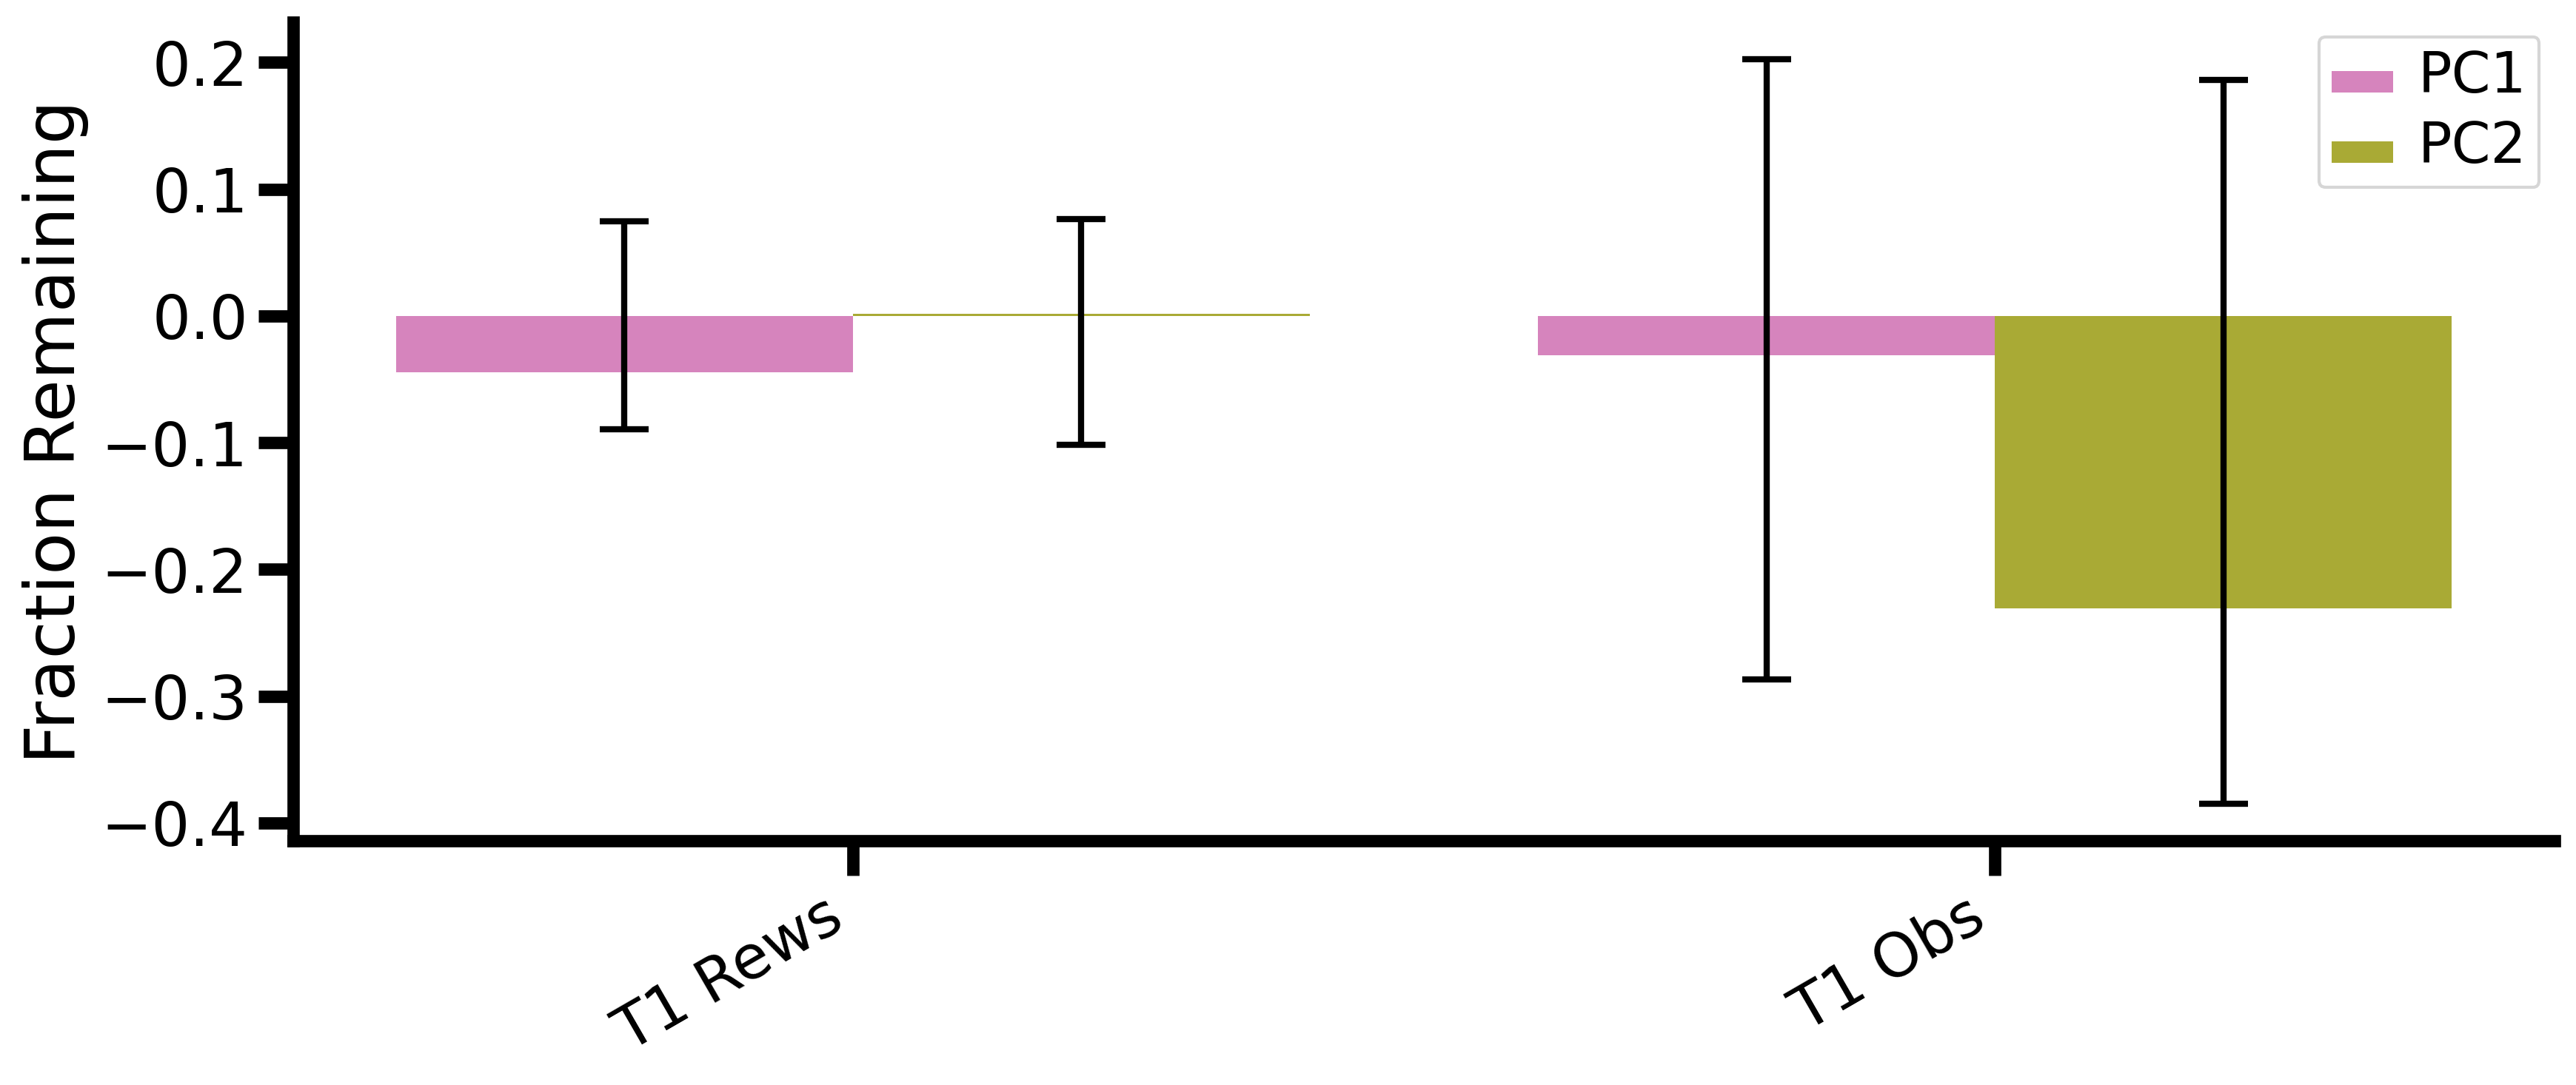

In [127]:
import seaborn as sns

fig = plt.figure(figsize=(13.135, 4.886), dpi=300)
ax = fig.add_subplot(111)

#y_name = 'Similarity Difference'
y_name = 'Fraction Remaining'

### Create a Seaborn
s = sns.barplot(x='Name', y=y_name, data=diff_df[diff_df['task'] == 'T1'], ax=ax, hue='Transdiagnostic', palette=['C6', 'C8'])

# Remove the legend title
legend = ax.legend()
legend.set_title('')

ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xlabel(None)

for bar in ax.patches:
    # Get the height of the bar
    height = bar.get_height()
    # Find the index where 'Cosine Similarity' is close to the height of the bar
    index = np.where(np.isclose(diff_df[y_name], height))[0][0]
    lower = diff_df.loc[diff_df.index[index], 'Lower']
    upper = diff_df.loc[diff_df.index[index], 'Upper']
    mean = diff_df.loc[diff_df.index[index], y_name]
    print(index, lower, upper, mean)
    plt.errorbar(x=bar.get_x() + bar.get_width() / 2, y=mean, 
                 yerr=[[mean-lower], [upper-mean]], fmt='none', ecolor='black', capsize=8, elinewidth=2, markeredgewidth=2)
    

format_axis(ax, font_size_multiplier=1.4)

In [128]:
fig.savefig(os.path.join(analysis_folder, 'similarity_barplot_pcs.png'))
fig.savefig(os.path.join(analysis_folder, 'similarity_barplot_pcs.svg'))

/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

0 -0.08966673868887365 0.07449027043754679 -0.044622136965115224
2 -0.2869821898981166 0.2026313925705284 -0.031176928671486717


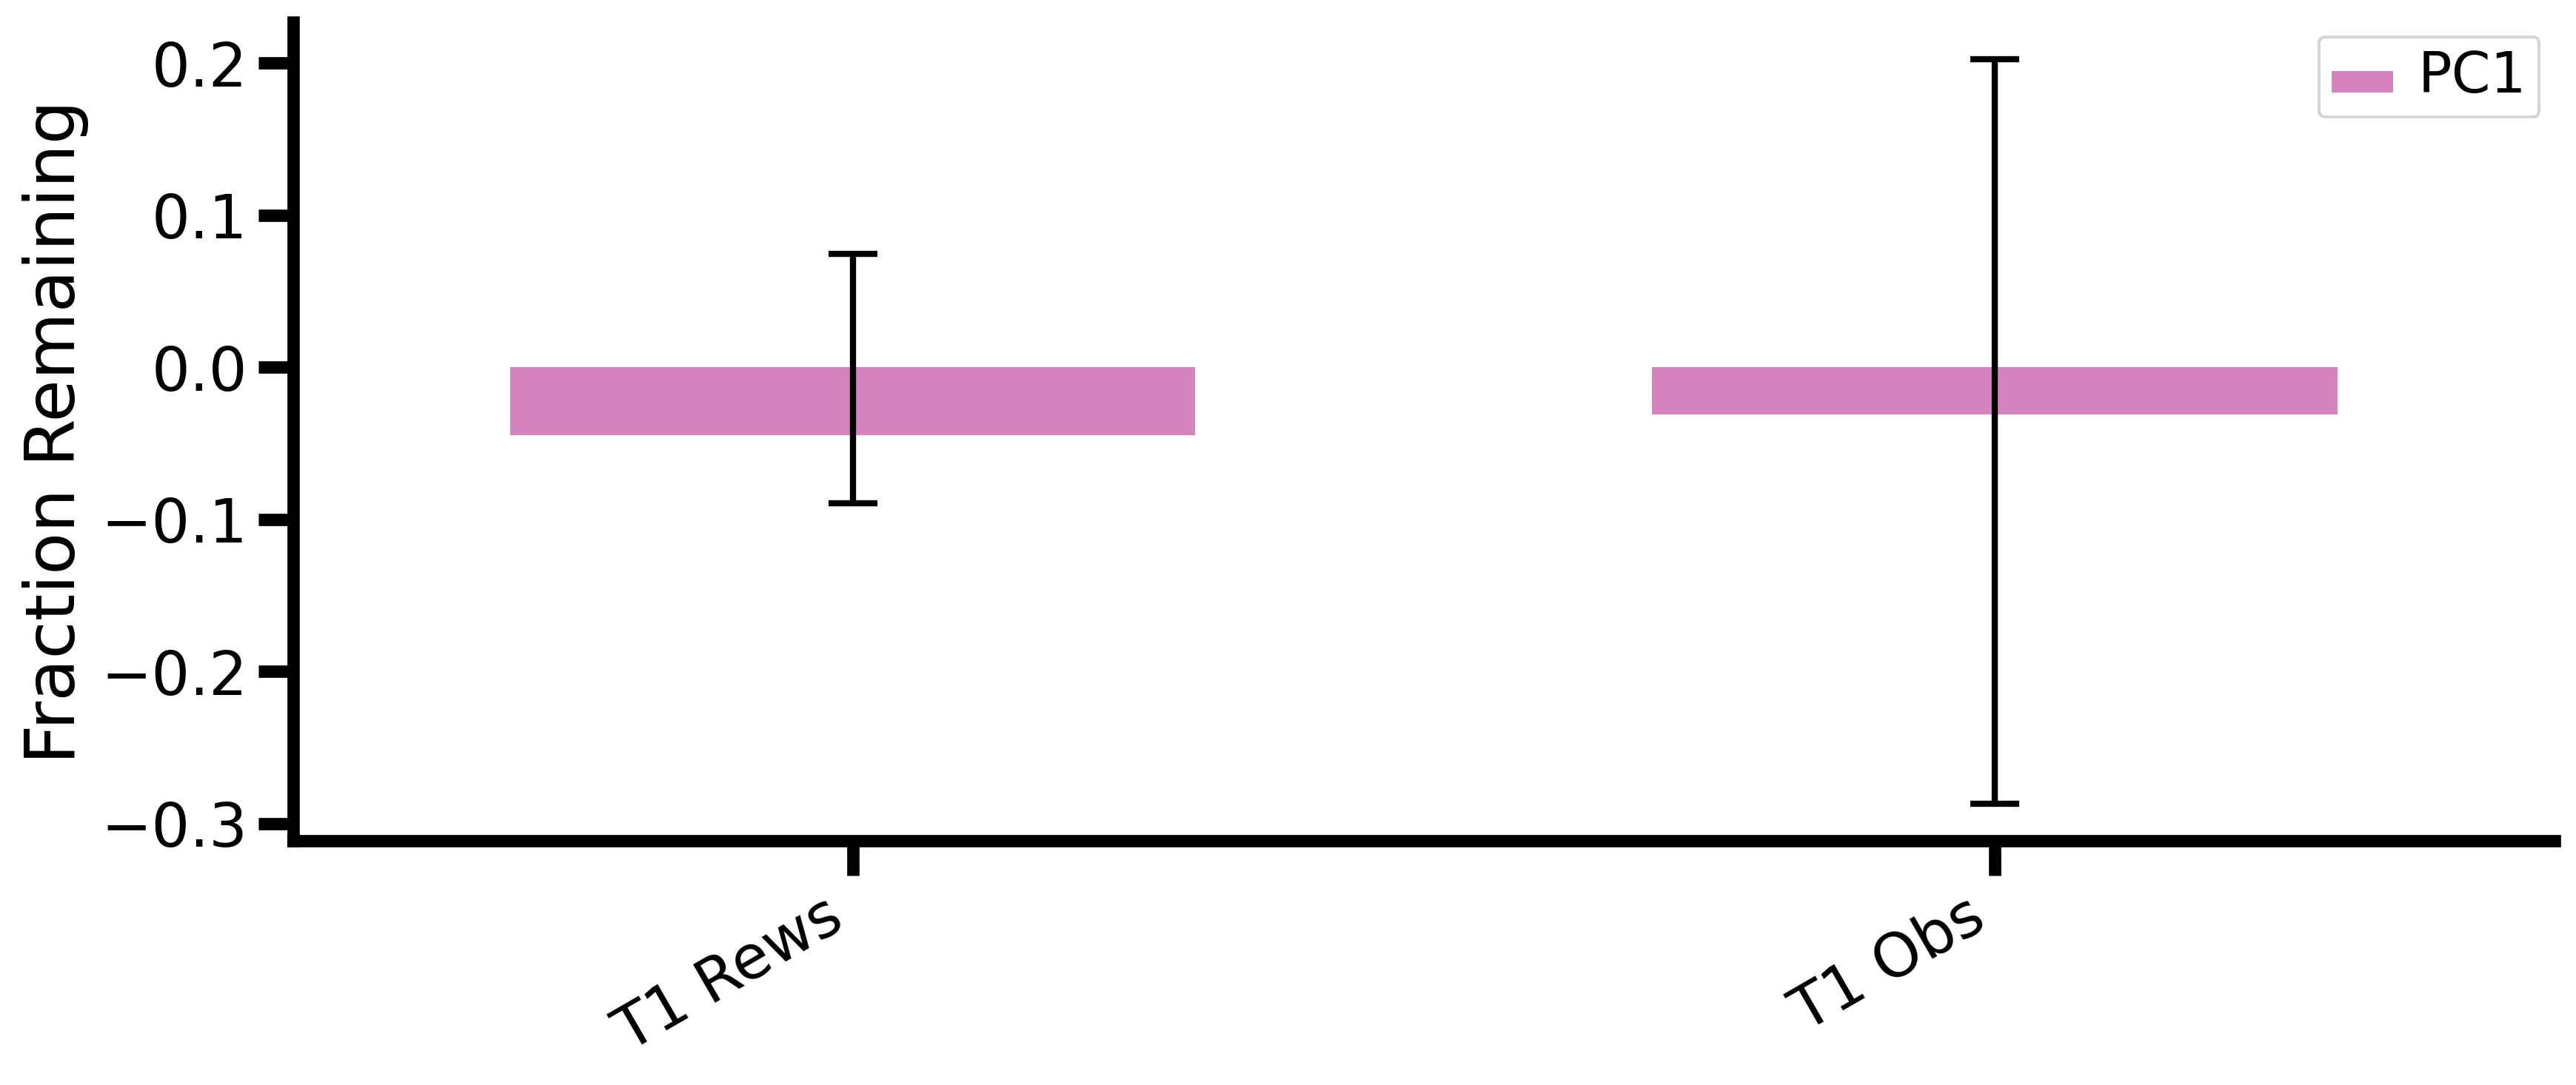

In [129]:
import seaborn as sns

fig = plt.figure(figsize=(13.135, 4.886), dpi=300)
ax = fig.add_subplot(111)

y_name = 'N Positive Difference'
y_name = 'Fraction Remaining'


### Create a Seaborn
s = sns.barplot(x='Name', y=y_name, data=diff_df[(diff_df['Transdiagnostic'] == "PC1") & (diff_df['task'] == 'T1')], ax=ax, hue='Transdiagnostic', palette=['C6', 'C8'])

# Remove the legend title
legend = ax.legend()
legend.set_title('')

ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xlabel(None)

for bar in ax.patches:
    # Get the height of the bar
    height = bar.get_height()
    # Find the index where 'Cosine Similarity' is close to the height of the bar
    index = np.where(np.isclose(diff_df[y_name], height))[0][0]
    lower = diff_df.loc[diff_df.index[index], 'Lower']
    upper = diff_df.loc[diff_df.index[index], 'Upper']
    mean = diff_df.loc[diff_df.index[index], y_name]
    print(index, lower, upper, mean)
    plt.errorbar(x=bar.get_x() + bar.get_width() / 2, y=mean, 
                 yerr=[[mean-lower], [upper-mean]], fmt='none', ecolor='black', capsize=8, elinewidth=2, markeredgewidth=2)
    
new_value = 0.6
for patch in ax.patches :
    current_width = patch.get_width()
    diff = current_width - new_value

    # we change the bar width
    patch.set_width(new_value)

    # we recenter the bar
    patch.set_x(patch.get_x() + diff * .5)

    
format_axis(ax, font_size_multiplier=1.4)

In [130]:
fig.savefig(os.path.join(analysis_folder, 'similarity_barplot_pc1.png'))
fig.savefig(os.path.join(analysis_folder, 'similarity_barplot_pc1.svg'))

/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

1 -0.1014338141771988 0.07638369411814164 0.0017786072027079125
3 -0.3847874501636253 0.1859027358519292 -0.2307541410112378
6 -0.01727741007600556 0.01727459211659879 0.0020183669265213086
10 -0.11335425898418257 0.12712468534713056 -0.050644726806096614
14 -0.19742909259620614 0.10725259362582182 -0.0915914846425277


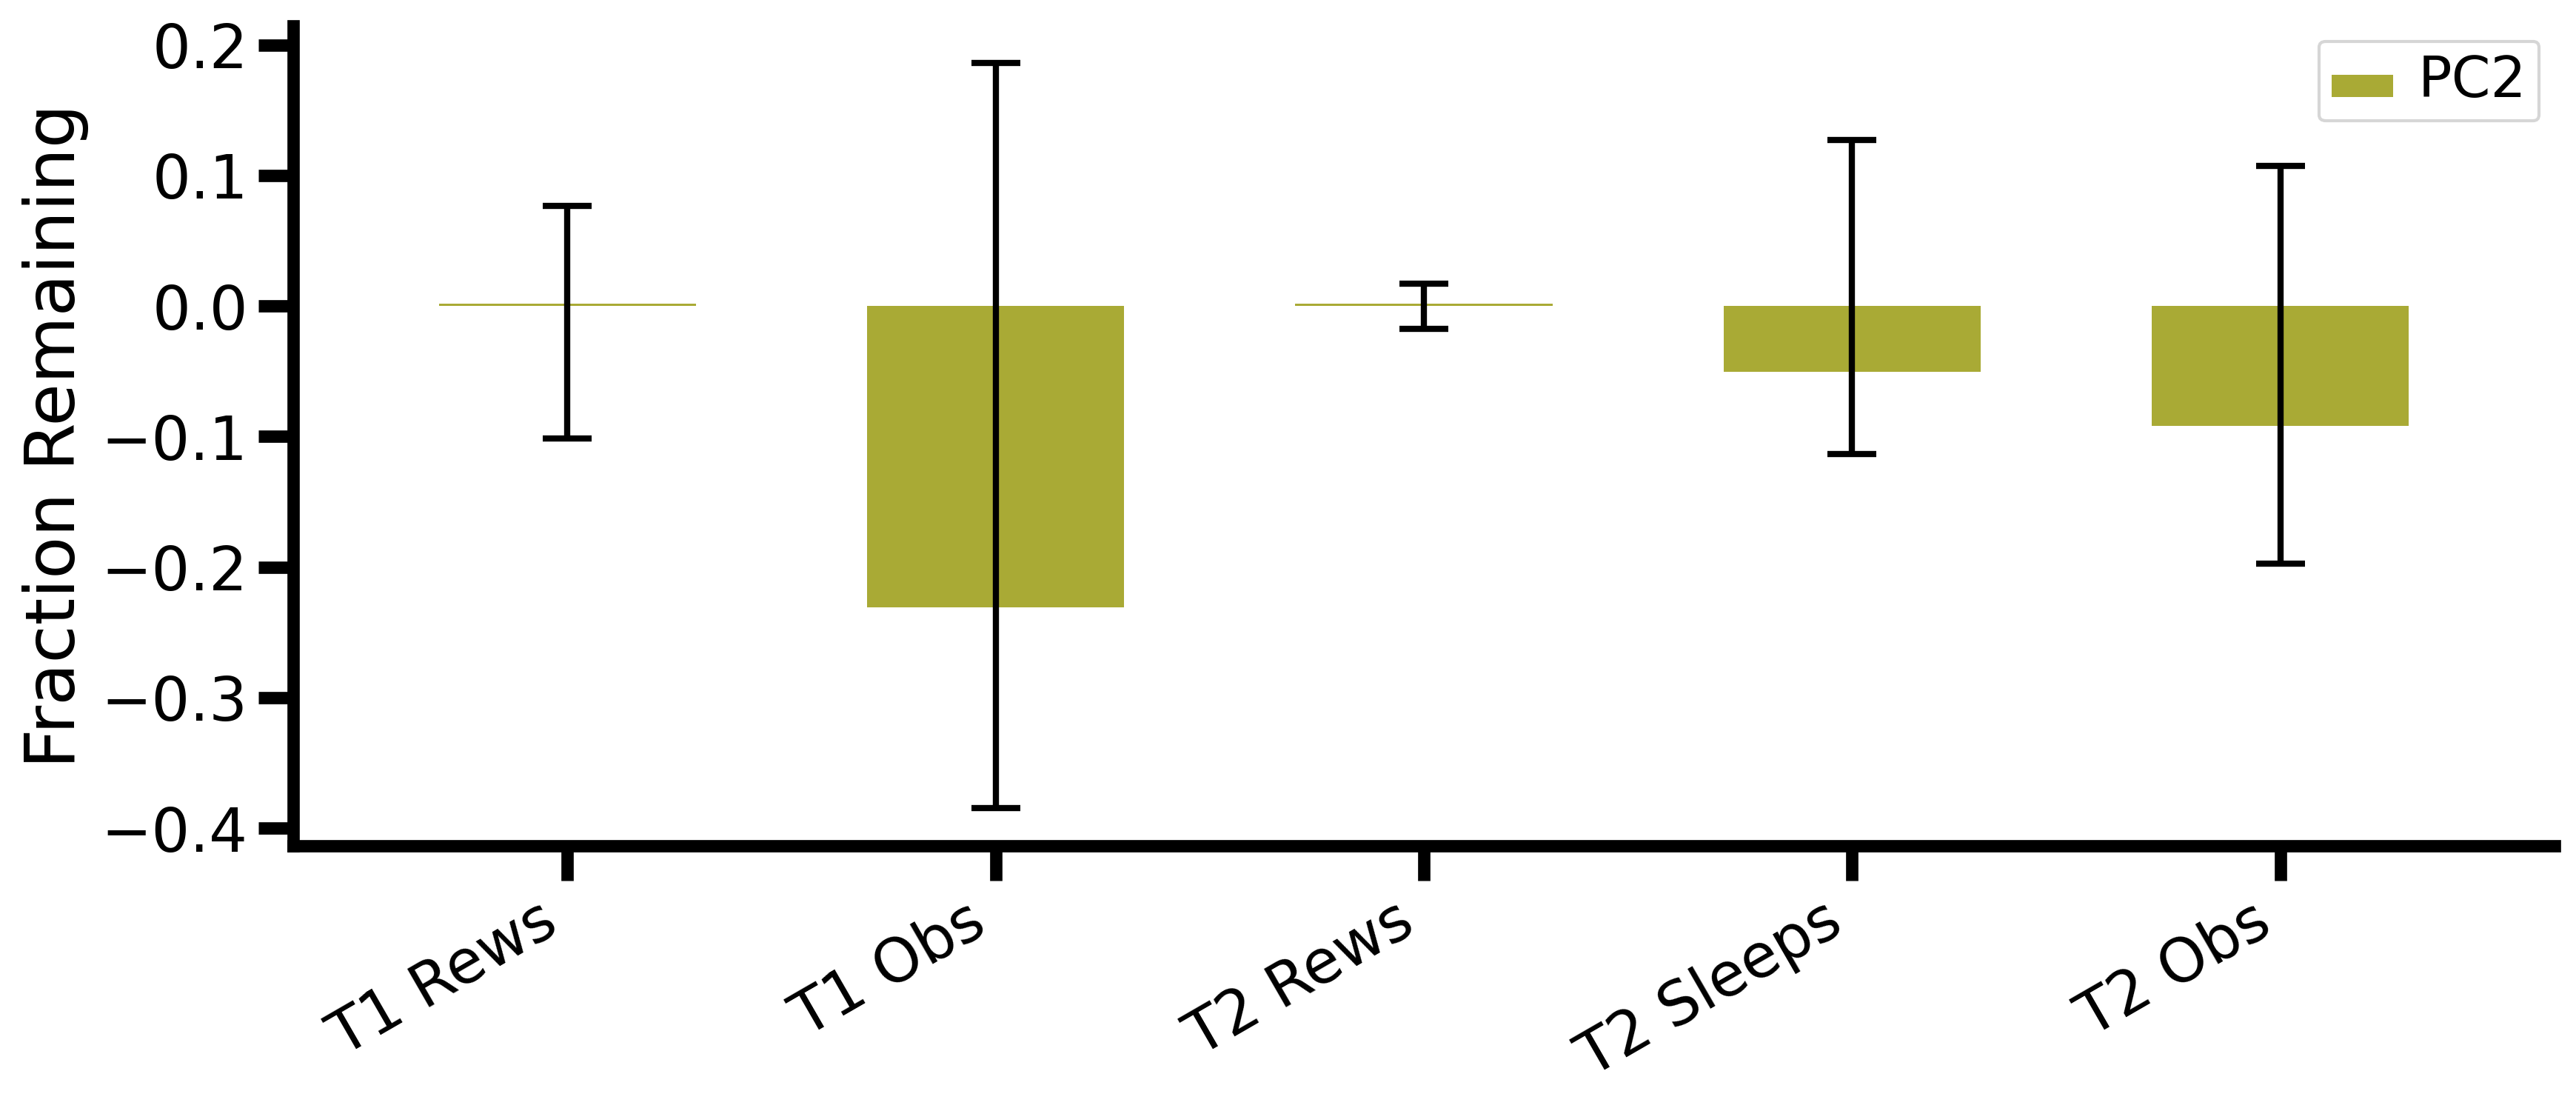

In [131]:
import seaborn as sns

fig = plt.figure(figsize=(13.135, 4.886), dpi=300)
ax = fig.add_subplot(111)

y_name = 'N Positive Difference'
y_name = 'Fraction Remaining'


### Create a Seaborn
s = sns.barplot(x='Name', y=y_name, data=diff_df[diff_df['Transdiagnostic'] == "PC2"], ax=ax, hue='Transdiagnostic', palette=['C8'])

# Remove the legend title
legend = ax.legend()
legend.set_title('')

ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xlabel(None)

for bar in ax.patches:
    # Get the height of the bar
    height = bar.get_height()
    # Find the index where 'Cosine Similarity' is close to the height of the bar
    index = np.where(np.isclose(diff_df[y_name], height))[0][0]
    lower = diff_df.loc[diff_df.index[index], 'Lower']
    upper = diff_df.loc[diff_df.index[index], 'Upper']
    mean = diff_df.loc[diff_df.index[index], y_name]
    print(index, lower, upper, mean)
    plt.errorbar(x=bar.get_x() + bar.get_width() / 2, y=mean, 
                 yerr=[[mean-lower], [upper-mean]], fmt='none', ecolor='black', capsize=8, elinewidth=2, markeredgewidth=2)
    
new_value = 0.6
for patch in ax.patches :
    current_width = patch.get_width()
    diff = current_width - new_value

    # we change the bar width
    patch.set_width(new_value)

    # we recenter the bar
    patch.set_x(patch.get_x() + diff * .5)

    
format_axis(ax, font_size_multiplier=1.4)

In [132]:
fig.savefig(os.path.join(analysis_folder, 'similarity_barplot_pc2.png'))
fig.savefig(os.path.join(analysis_folder, 'similarity_barplot_pc2.svg'))

## Panel G: Optimal Linear Projection
### Task 1 Observes

In [133]:
def plot_optimal_combination_model(y_loweff, y_pred_loweff, y_higheff, y_pred_higheff, ylabel = None):
    fig = plt.figure(dpi=300, figsize=(10.639, 4.754))
    ax = fig.add_subplot(111)
    ax.scatter(y_pred_loweff, y_loweff, color='lime', label=r'$\xi \in \{0, 0.125, 0.25, 0.375\}$', alpha=0.75, marker='D', s=80)
    ax.scatter(y_pred_higheff, y_higheff, color='darkgreen', label=r'$\xi \in \{0.625, 0.75, 0.875, 1\}$', alpha=0.85, s=80)

    ## plot diagonal line across whole plot
    min_value = min(y_pred_loweff.min(), y_pred_higheff.min())
    max_value = max(y_pred_higheff.max(), y_pred_loweff.max())
    
    ax.plot([min_value, max_value], [min_value, max_value], color='black', linestyle='--', label='Prediction')
    ax.legend()

    format_axis(ax, font_size_multiplier=1.4)
    ax.set_xlabel('Linear AD/Compul Prediction')
    ax.set_ylabel(ylabel)
    return fig

In [134]:
mask = 'nomask'
iday = 2
day = 'day%d' %iday
with_nets = False
include_sleep = False
include_estimates = False
group = None

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

df['n_observes_higheff'] = df['n_observes'].apply(lambda x : np.mean(x[:4]))
df['n_observes_loweff'] = df['n_observes'].apply(lambda x : np.mean(x[5:]))

/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/human_utils_project.py:1281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_day3['group'] = False


In [135]:
X = df[['AD', 'Compul']]
y_loweff = df['n_observes_loweff']
X = sm.add_constant(X)
model_loweff = sm.OLS(y_loweff,X)
results_loweff = model_loweff.fit()
results_loweff.params
results_loweff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      n_observes_loweff   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     3.492
Date:                Thu, 29 Aug 2024   Prob (F-statistic):             0.0371
Time:                        13:19:36   Log-Likelihood:                -143.31
No. Observations:                  60   AIC:                             292.6
Df Residuals:                      57   BIC:                             298.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6331      0.360     15.668      0.000       4.913       6.353
AD            -0.7000      0.407     -1.719      0.091      -1.515       0.115
Compul         0.9596      0.473      2.030      0.047       0.013       1.906
==============================================================================
Omnibus:                        2.246   Durbin-Watson:                   1.815
Prob(Omnibus):                  0.325   Jarque-Bera (JB):                1.679
Skew:                          -0.223   Prob(JB):                        0.432
Kurtosis:                       2.313   Cond. No.                         1.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [136]:
X = df[['AD', 'Compul']]
y_higheff = df['n_observes_higheff']
X = sm.add_constant(X)
model_higheff = sm.OLS(y_higheff,X)
results_higheff = model_higheff.fit()
results_higheff.params 
results_higheff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     n_observes_higheff   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.168
Date:                Thu, 29 Aug 2024   Prob (F-statistic):              0.318
Time:                        13:19:36   Log-Likelihood:                -142.56
No. Observations:                  60   AIC:                             291.1
Df Residuals:                      57   BIC:                             297.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8247      0.355     16.405      0.000       5.114       6.536
AD            -0.5654      0.402     -1.406      0.165      -1.371       0.240
Compul         0.2886      0.467      0.618      0.539      -0.646       1.223
==============================================================================
Omnibus:                        0.053   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.974   Jarque-Bera (JB):                0.038
Skew:                          -0.033   Prob(JB):                        0.981
Kurtosis:                       2.896   Cond. No.                         1.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

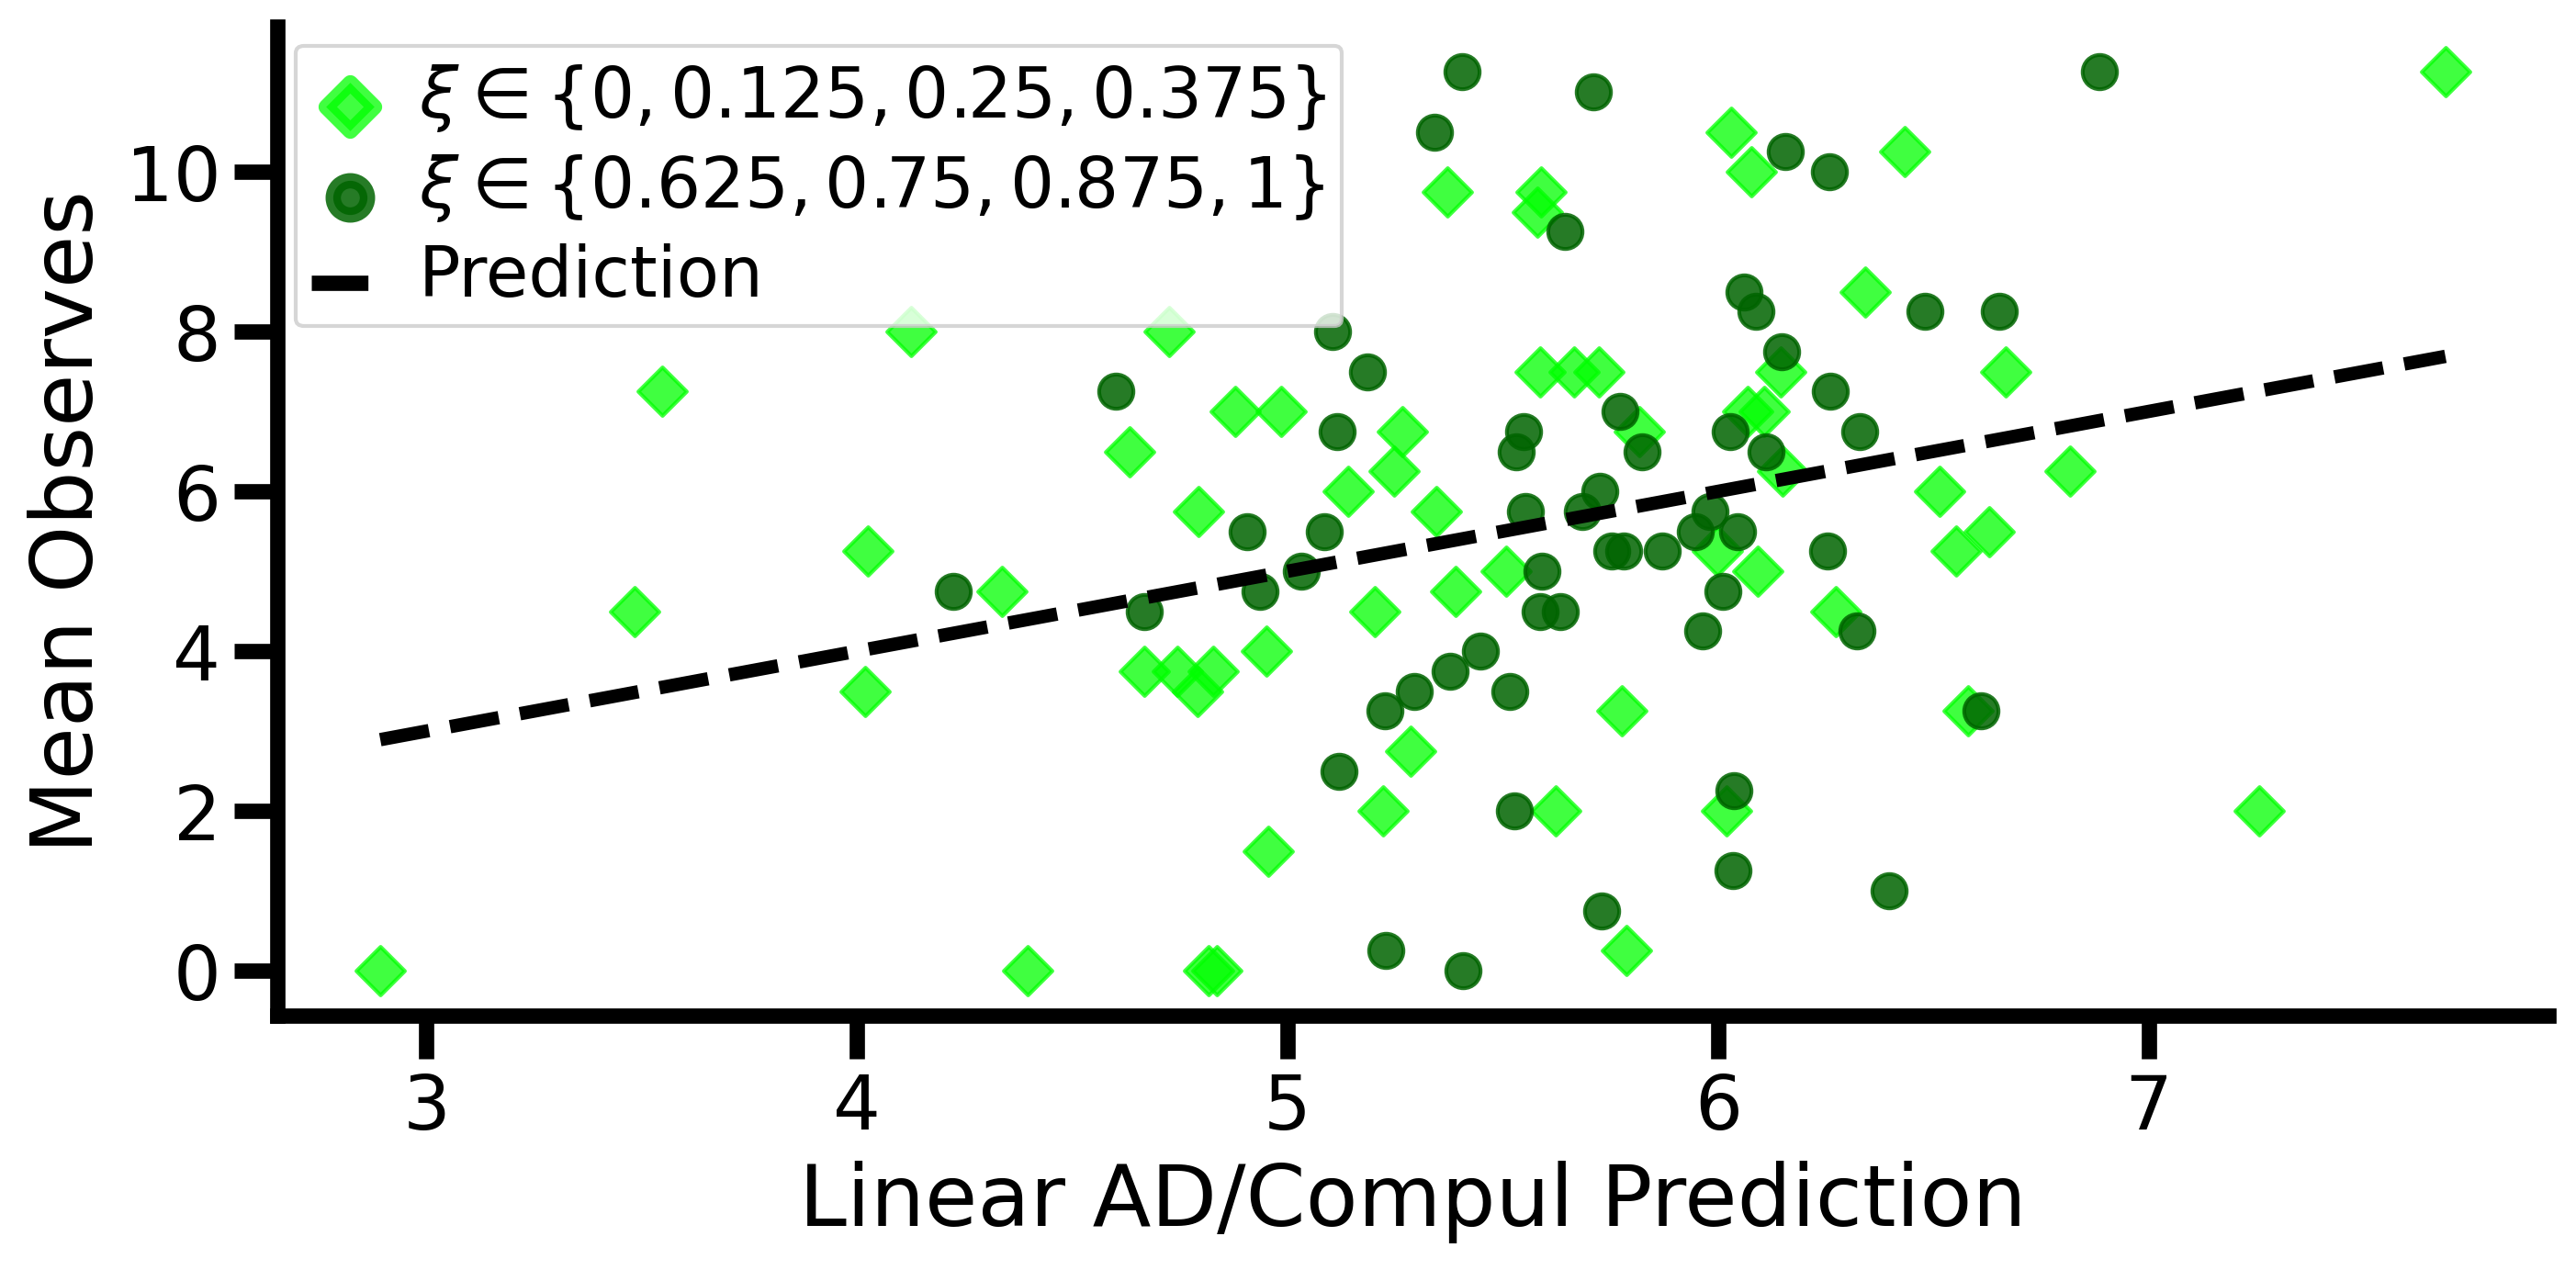

In [137]:
fig = plot_optimal_combination_model(y_loweff, results_loweff.predict(X), y_higheff, results_higheff.predict(X), ylabel='Mean Observes')

In [138]:
fig.savefig(os.path.join(analysis_folder, 'lm_task1_observes.png'))
fig.savefig(os.path.join(analysis_folder, 'lm_task1_observes.svg'))

### Task 1 Rewards

In [139]:
mask = 'nomask'
iday = 2
day = 'day%d' %iday
with_nets = False
include_sleep = False
include_estimates = False
group = None

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

df['rewards_tallies_higheff'] = df['rewards_tallies'].apply(lambda x : np.mean(x[:4]))
df['rewards_tallies_loweff'] = df['rewards_tallies'].apply(lambda x : np.mean(x[5:]))

/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/human_utils_project.py:1281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_day3['group'] = False


In [140]:
X = df[['AD', 'Compul']]
y_loweff = df['rewards_tallies_loweff']
X = sm.add_constant(X)
model_loweff = sm.OLS(y_loweff,X)
results_loweff = model_loweff.fit()
results_loweff.params
results_loweff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     rewards_tallies_loweff   R-squared:                       0.006
Model:                                OLS   Adj. R-squared:                 -0.029
Method:                     Least Squares   F-statistic:                    0.1742
Date:                    Thu, 29 Aug 2024   Prob (F-statistic):              0.841
Time:                            13:19:38   Log-Likelihood:                -147.94
No. Observations:                      60   AIC:                             301.9
Df Residuals:                          57   BIC:                             308.2
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.7002      0.388     68.747      0.000      25.923      27.478
AD            -0.1818      0.440     -0.413      0.681      -1.063       0.699
Compul        -0.2122      0.511     -0.416      0.679      -1.235       0.810
==============================================================================
Omnibus:                        2.119   Durbin-Watson:                   1.805
Prob(Omnibus):                  0.347   Jarque-Bera (JB):                2.080
Skew:                          -0.413   Prob(JB):                        0.353
Kurtosis:                       2.612   Cond. No.                         1.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [141]:
X = df[['AD', 'Compul']]
y_higheff = df['rewards_tallies_higheff']
X = sm.add_constant(X)
model_higheff = sm.OLS(y_higheff,X)
results_higheff = model_higheff.fit()
results_higheff.params
results_higheff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     rewards_tallies_higheff   R-squared:                       0.022
Model:                                 OLS   Adj. R-squared:                 -0.013
Method:                      Least Squares   F-statistic:                    0.6266
Date:                     Thu, 29 Aug 2024   Prob (F-statistic):              0.538
Time:                             13:19:38   Log-Likelihood:                -135.93
No. Observations:                       60   AIC:                             277.9
Df Residuals:                           57   BIC:                             284.1
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.8783      0.318     81.404      0.000      25.242      26.515
AD             0.1888      0.360      0.524      0.602      -0.532       0.910
Compul         0.4104      0.418      0.982      0.330      -0.427       1.247
==============================================================================
Omnibus:                        0.329   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.848   Jarque-Bera (JB):                0.505
Skew:                           0.038   Prob(JB):                        0.777
Kurtosis:                       2.557   Cond. No.                         1.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

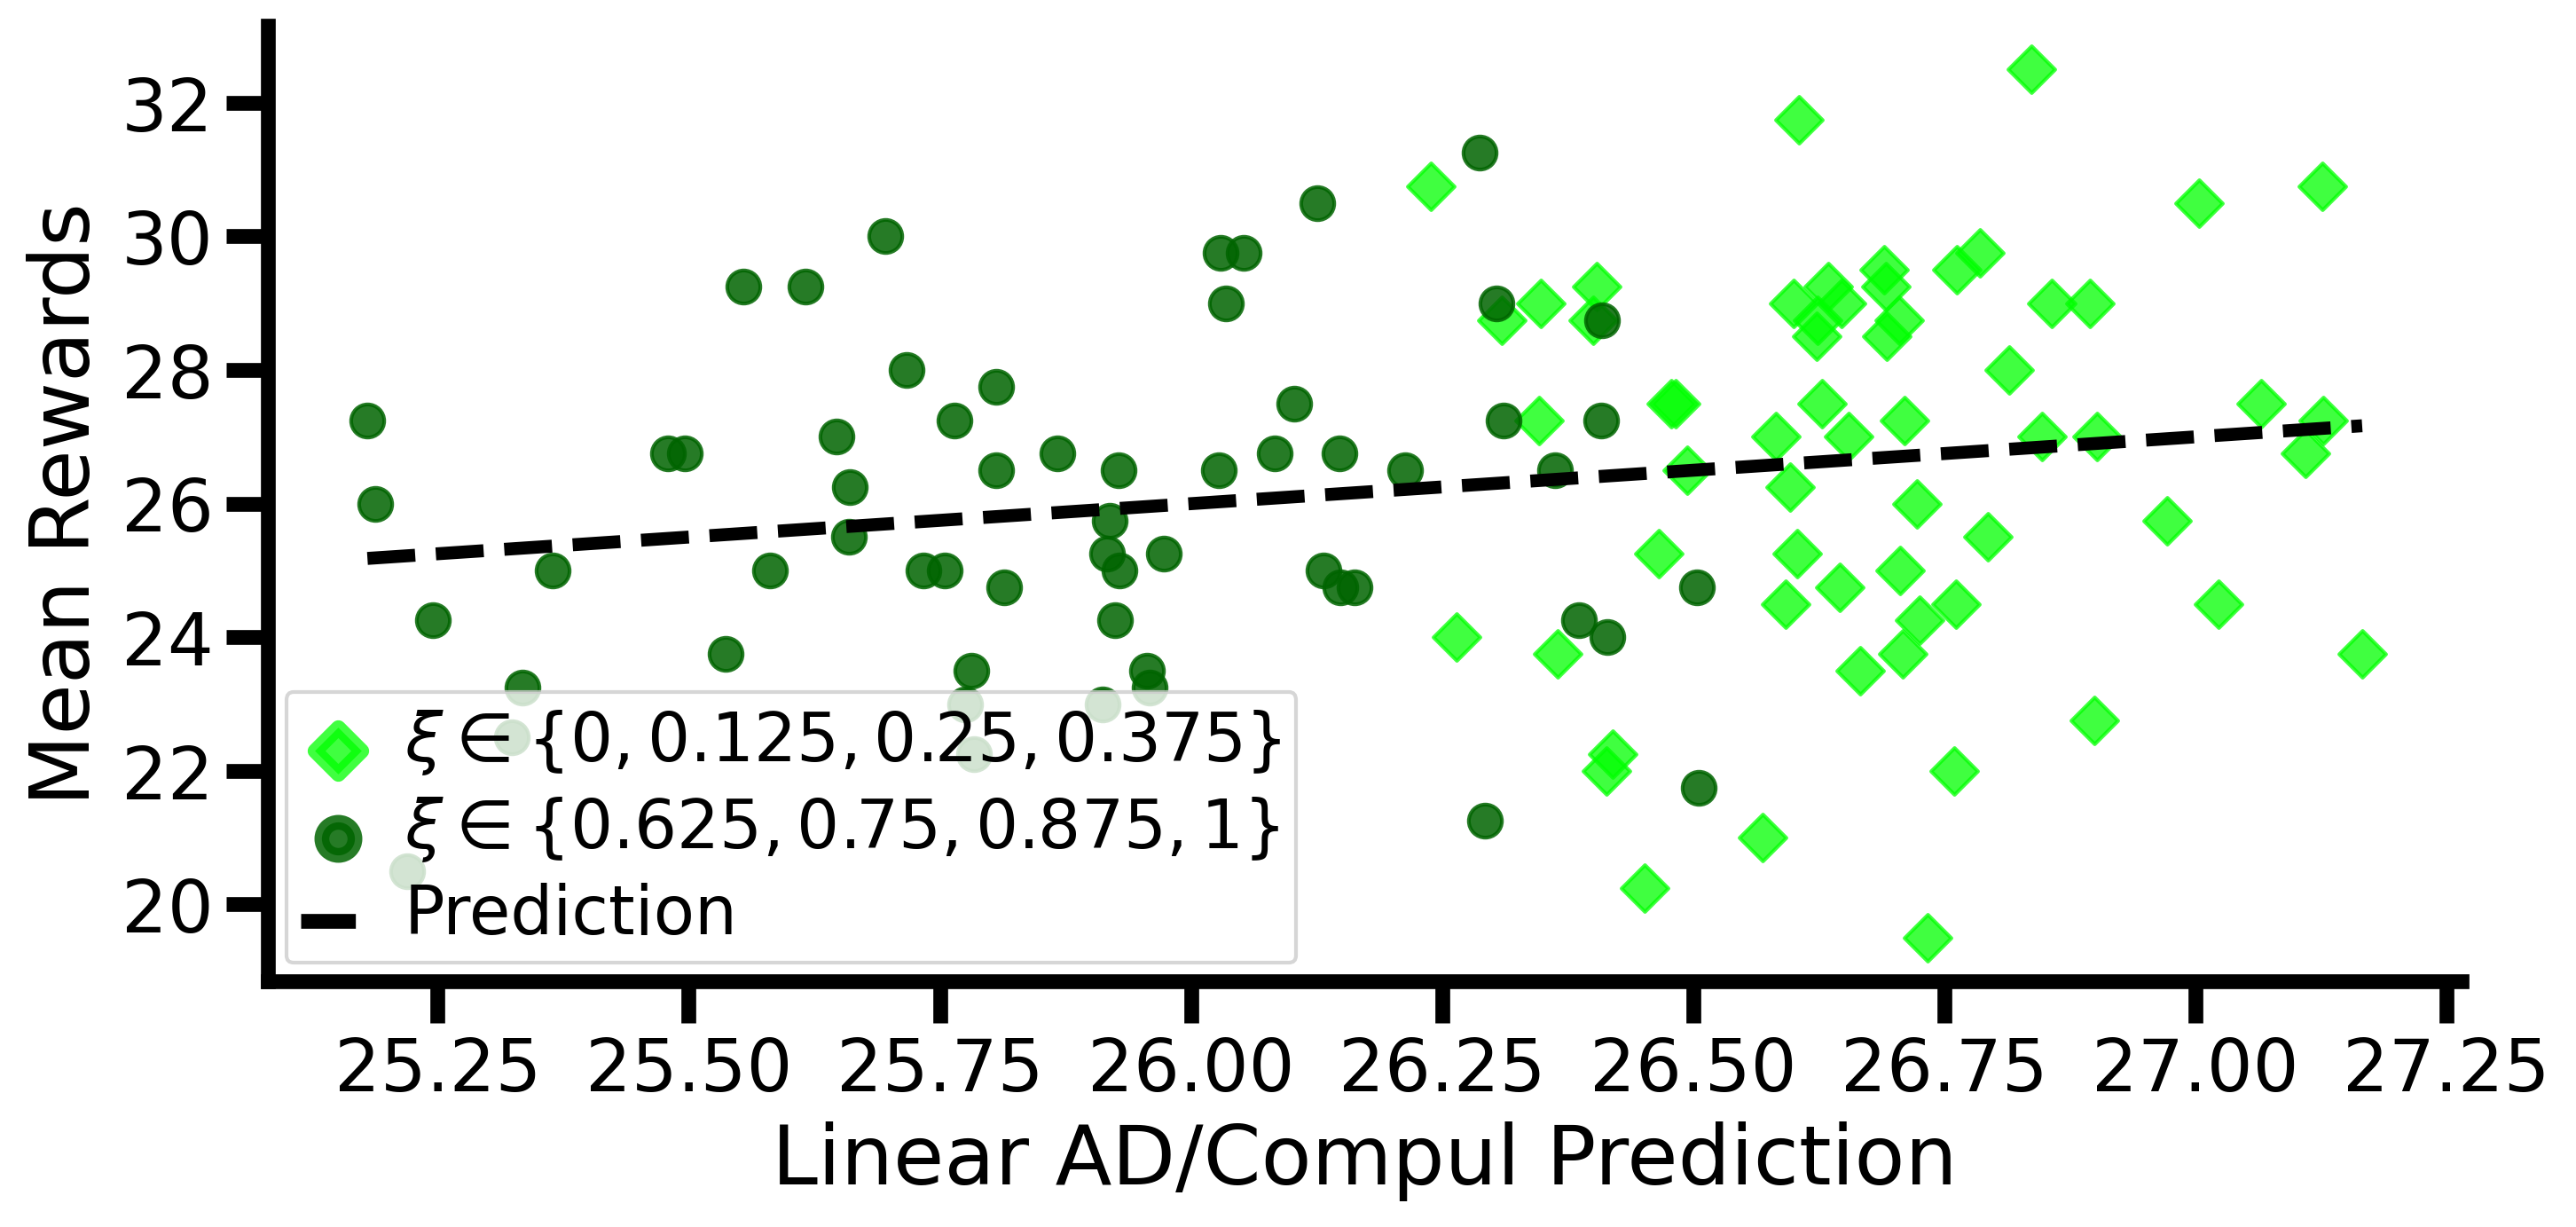

In [142]:
fig = plot_optimal_combination_model(y_loweff, results_loweff.predict(X), y_higheff, results_higheff.predict(X), ylabel='Mean Rewards')

In [143]:
fig.savefig(os.path.join(analysis_folder, 'lm_task1_rewards.png'))
fig.savefig(os.path.join(analysis_folder, 'lm_task1_rewards.svg'))

### Task 2 Sleeps

In [144]:
mask = 'nomask'
iday = 3
day = 'day%d' %iday
with_nets = False
include_sleep = False
include_estimates = False
group = None

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

df['n_sleeps_higheff'] = df['n_sleeps'].apply(lambda x : np.mean(x[:4]))
df['n_sleeps_loweff'] = df['n_sleeps'].apply(lambda x : np.mean(x[5:]))

/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/human_utils_project.py:1281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_day3['group'] = False


In [145]:
X = df[['AD', 'Compul']]
y_loweff = df['n_sleeps_loweff']
X = sm.add_constant(X)
model_loweff = sm.OLS(y_loweff,X)
results_loweff = model_loweff.fit()
results_loweff.params
results_loweff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        n_sleeps_loweff   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1.405
Date:                Thu, 29 Aug 2024   Prob (F-statistic):              0.254
Time:                        13:19:39   Log-Likelihood:                -115.82
No. Observations:                  60   AIC:                             237.6
Df Residuals:                      57   BIC:                             243.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9178      0.227      8.435      0.000       1.463       2.373
AD             0.3347      0.257      1.300      0.199      -0.181       0.850
Compul        -0.3216      0.299     -1.076      0.287      -0.920       0.277
==============================================================================
Omnibus:                        7.973   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                7.426
Skew:                           0.838   Prob(JB):                       0.0244
Kurtosis:                       3.405   Cond. No.                         1.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [146]:
X = df[['AD', 'Compul']]
y_higheff = df['n_sleeps_higheff']
X = sm.add_constant(X)
model_higheff = sm.OLS(y_higheff,X)
results_higheff = model_higheff.fit()
results_higheff.params
results_higheff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       n_sleeps_higheff   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.022
Method:                 Least Squares   F-statistic:                    0.3657
Date:                Thu, 29 Aug 2024   Prob (F-statistic):              0.695
Time:                        13:19:39   Log-Likelihood:                -111.83
No. Observations:                  60   AIC:                             229.7
Df Residuals:                      57   BIC:                             235.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5698      0.213     12.079      0.000       2.144       2.996
AD             0.2005      0.241      0.832      0.409      -0.282       0.683
Compul        -0.0581      0.280     -0.208      0.836      -0.618       0.502
==============================================================================
Omnibus:                        0.550   Durbin-Watson:                   1.665
Prob(Omnibus):                  0.760   Jarque-Bera (JB):                0.650
Skew:                           0.206   Prob(JB):                        0.722
Kurtosis:                       2.700   Cond. No.                         1.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

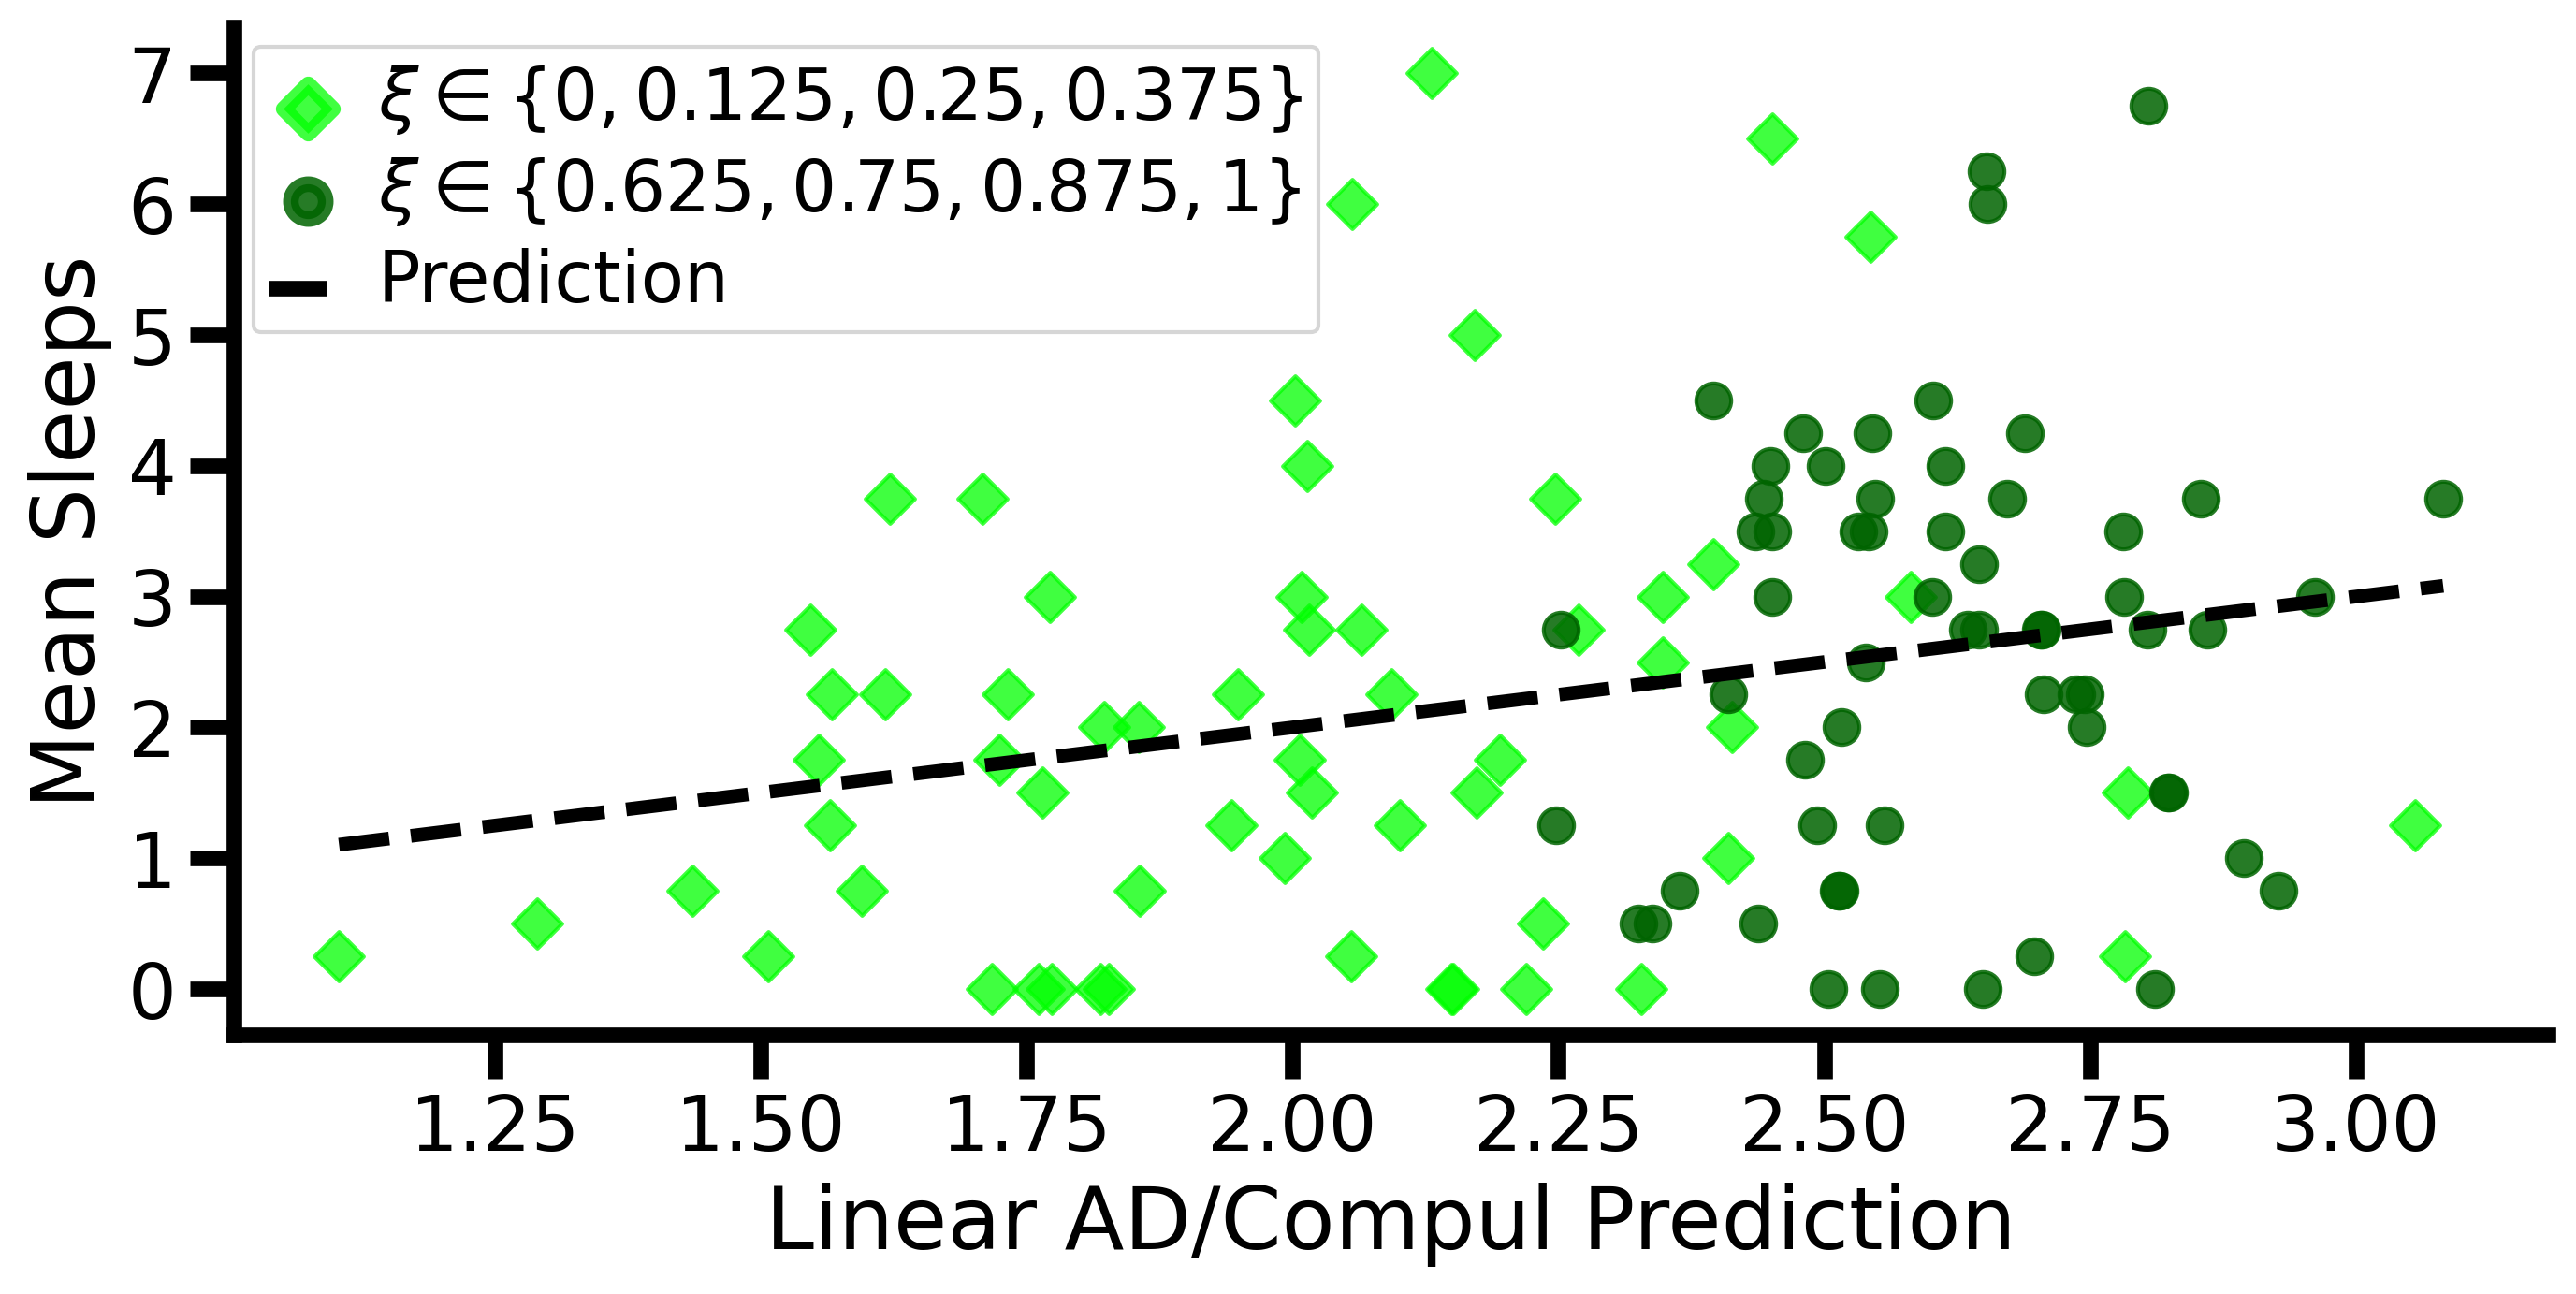

In [147]:
fig = plot_optimal_combination_model(y_loweff, results_loweff.predict(X), y_higheff, results_higheff.predict(X), ylabel='Mean Sleeps')

In [148]:
fig.savefig(os.path.join(analysis_folder, 'lm_task2_sleep.png'))
fig.savefig(os.path.join(analysis_folder, 'lm_task2_sleep.svg'))

In [149]:
X = df[['AD', 'Compul']]
y = np.stack(df['n_sleeps'].values).sum(axis=1)
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
results.params
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.191
Date:                Thu, 29 Aug 2024   Prob (F-statistic):              0.311
Time:                        13:19:40   Log-Likelihood:                -238.82
No. Observations:                  60   AIC:                             483.6
Df Residuals:                      57   BIC:                             489.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.1077      1.766     11.385      0.000      16.571      23.644
AD             2.4786      2.000      1.239      0.220      -1.526       6.484
Compul        -2.1752      2.322     -0.937      0.353      -6.825       2.475
==============================================================================
Omnibus:                        1.445   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.485   Jarque-Bera (JB):                1.459
Skew:                           0.339   Prob(JB):                        0.482
Kurtosis:                       2.649   Cond. No.                         1.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Task 2 Observes

In [150]:
mask = 'nomask'
iday = 3
day = 'day%d' %iday
with_nets = False
include_sleep = False
include_estimates = False
group = None

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

df['n_observes_higheff'] = df['n_observes'].apply(lambda x : np.mean(x[:4]))
df['n_observes_loweff'] = df['n_observes'].apply(lambda x : np.mean(x[5:]))

/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/human_utils_project.py:1281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_day3['group'] = False


In [151]:
X = df[['AD', 'Compul']]
y_loweff = df['n_observes_loweff']
X = sm.add_constant(X)
model_loweff = sm.OLS(y_loweff,X)
results_loweff = model_loweff.fit()
results_loweff.params
results_loweff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      n_observes_loweff   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     2.132
Date:                Thu, 29 Aug 2024   Prob (F-statistic):              0.128
Time:                        13:19:40   Log-Likelihood:                -147.10
No. Observations:                  60   AIC:                             300.2
Df Residuals:                      57   BIC:                             306.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.5643      0.383     17.140      0.000       5.797       7.331
AD            -0.5680      0.434     -1.310      0.196      -1.436       0.301
Compul         0.8127      0.504      1.614      0.112      -0.196       1.821
==============================================================================
Omnibus:                        3.449   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.178   Jarque-Bera (JB):                3.356
Skew:                          -0.544   Prob(JB):                        0.187
Kurtosis:                       2.599   Cond. No.                         1.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [152]:
X = df[['AD', 'Compul']]
y_higheff = df['n_observes_higheff']
X = sm.add_constant(X)
model_higheff = sm.OLS(y_higheff,X)
results_higheff = model_higheff.fit()
results_higheff.params
results_higheff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     n_observes_higheff   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     2.887
Date:                Thu, 29 Aug 2024   Prob (F-statistic):             0.0639
Time:                        13:19:40   Log-Likelihood:                -141.52
No. Observations:                  60   AIC:                             289.0
Df Residuals:                      57   BIC:                             295.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.5573      0.349     18.791      0.000       5.859       7.256
AD            -0.7906      0.395     -2.001      0.050      -1.582       0.001
Compul         0.6229      0.459      1.358      0.180      -0.296       1.542
==============================================================================
Omnibus:                        2.851   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.240   Jarque-Bera (JB):                2.135
Skew:                          -0.448   Prob(JB):                        0.344
Kurtosis:                       3.225   Cond. No.                         1.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

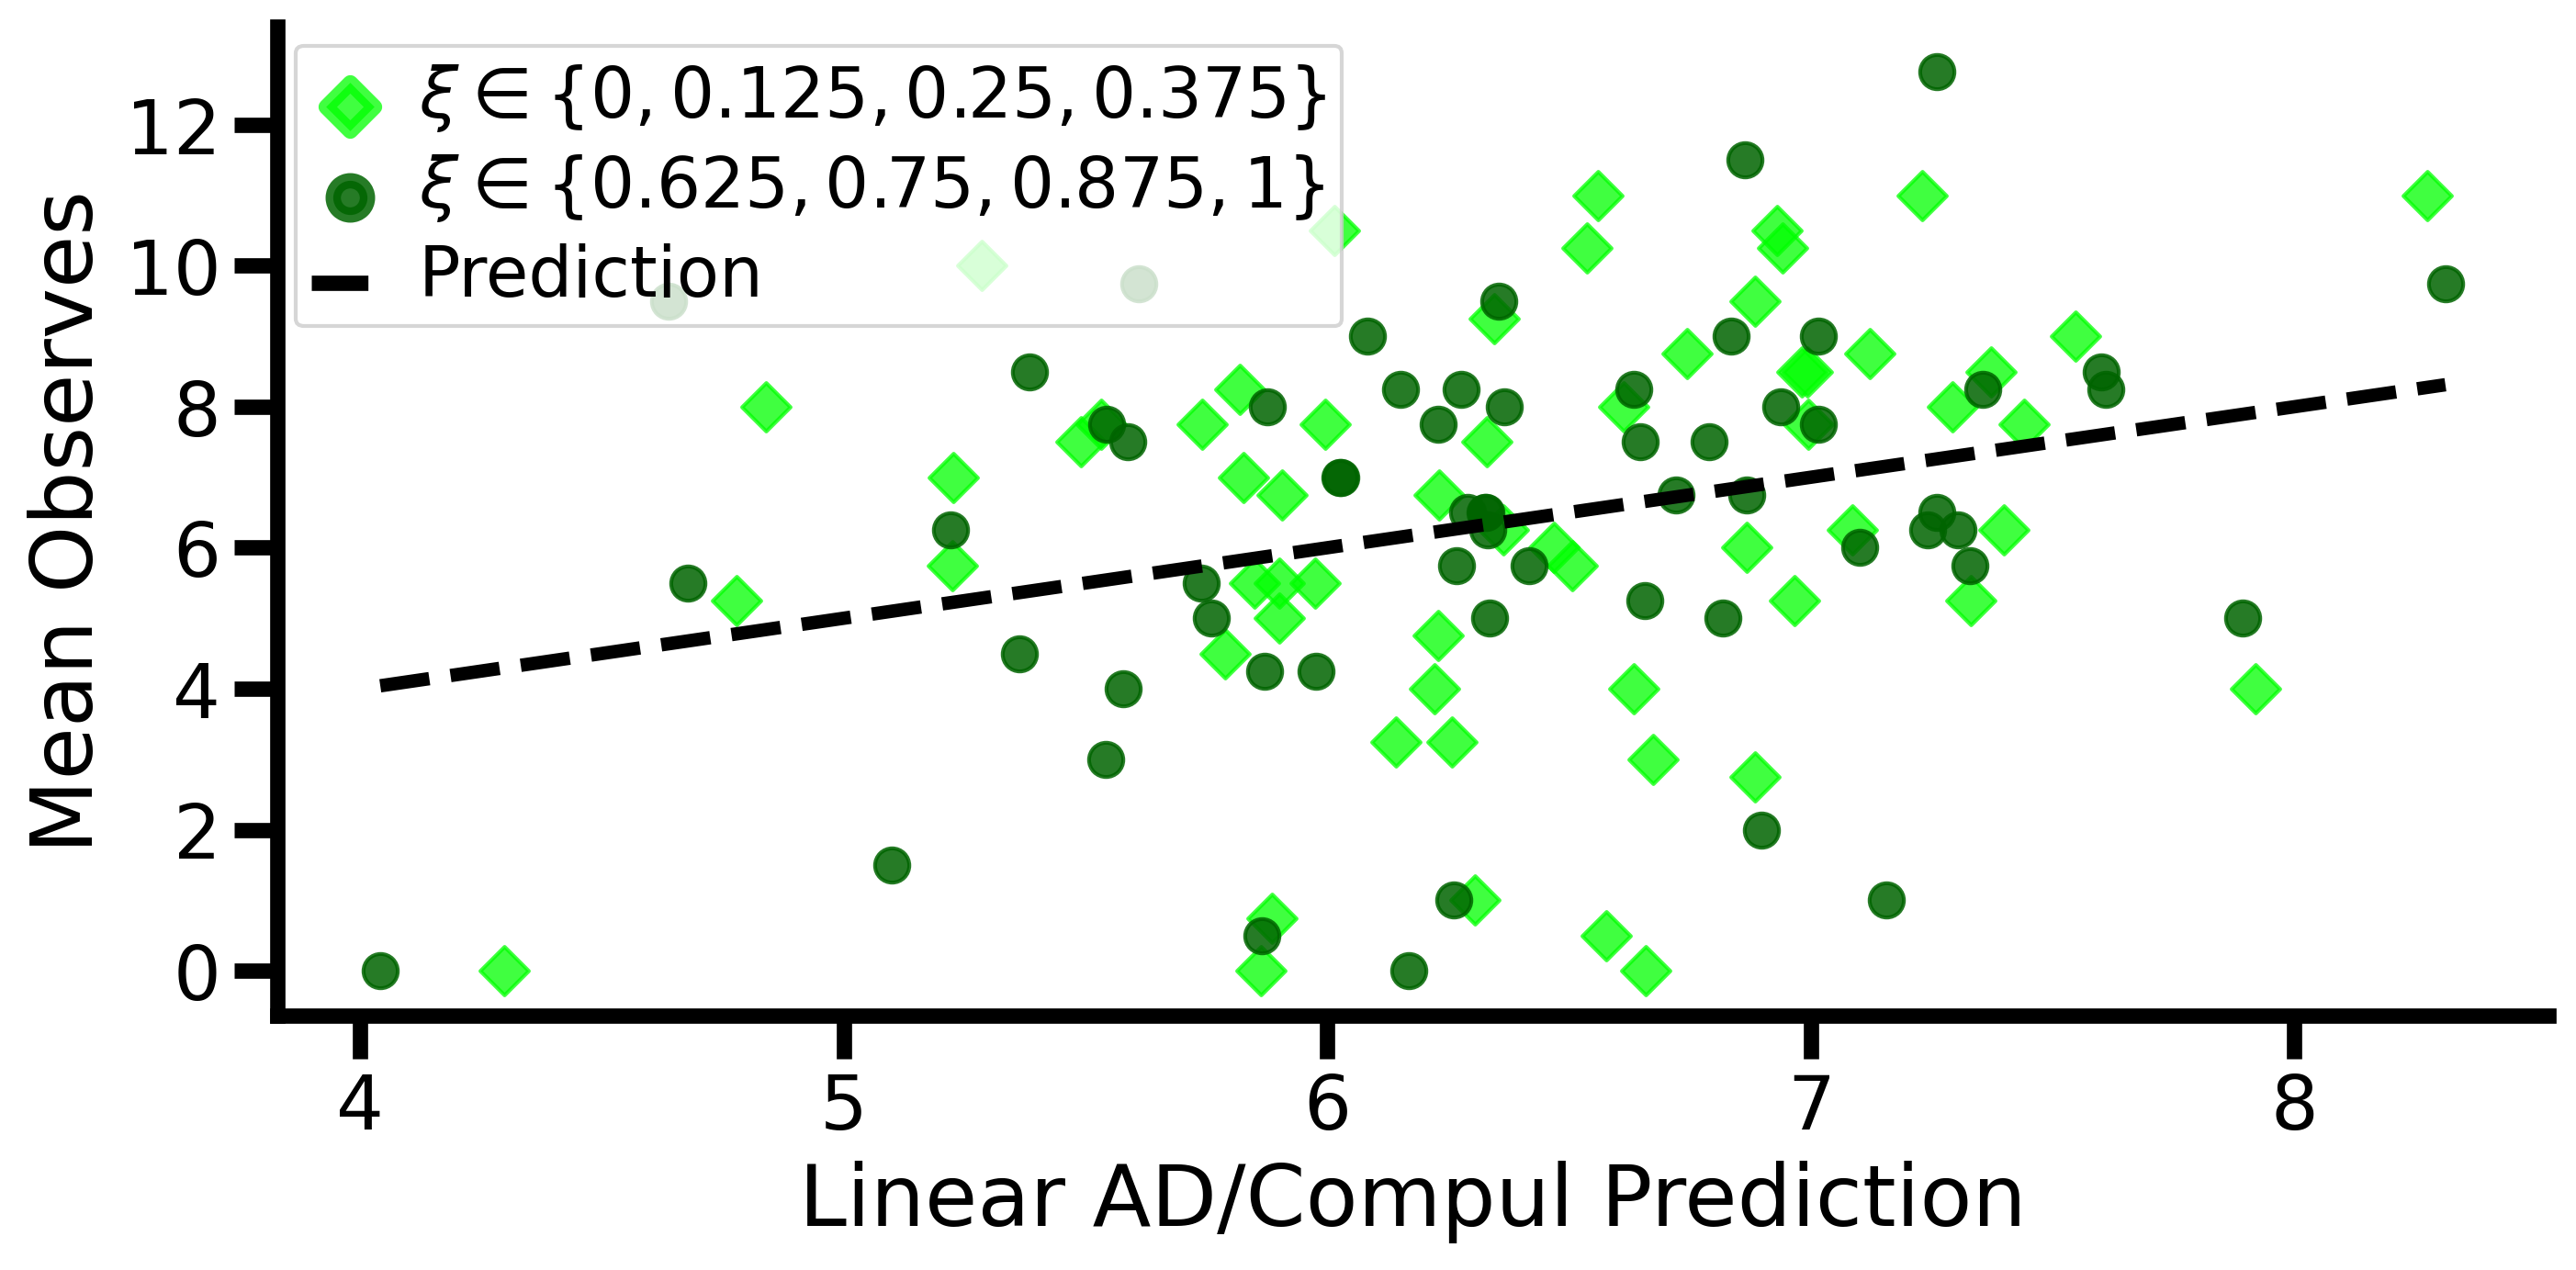

In [153]:
fig = plot_optimal_combination_model(y_loweff, results_loweff.predict(X), y_higheff, results_higheff.predict(X), ylabel='Mean Observes')

In [154]:
fig.savefig(os.path.join(analysis_folder, 'lm_task2_observes.png'))
fig.savefig(os.path.join(analysis_folder, 'lm_task2_observes.svg'))

### Task 2 Rewards

In [155]:
mask = 'nomask'
iday = 3
day = 'day%d' %iday
with_nets = False
include_sleep = False
include_estimates = False
group = None

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

df['rewards_higheff'] = df['rewards_tallies'].apply(lambda x : np.mean(x[:4]))
df['rewards_loweff'] = df['rewards_tallies'].apply(lambda x : np.mean(x[5:]))

/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/human_utils_project.py:1281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_day3['group'] = False


In [156]:
X = df[['AD', 'Compul']]
y_loweff = df['rewards_loweff']
X = sm.add_constant(X)
model_loweff = sm.OLS(y_loweff,X)
results_loweff = model_loweff.fit()
results_loweff.params
results_loweff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rewards_loweff   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.026
Method:                 Least Squares   F-statistic:                    0.2631
Date:                Thu, 29 Aug 2024   Prob (F-statistic):              0.770
Time:                        13:19:41   Log-Likelihood:                -141.81
No. Observations:                  60   AIC:                             289.6
Df Residuals:                      57   BIC:                             295.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.5299      0.351     75.654      0.000      25.828      27.232
AD             0.1029      0.397      0.259      0.797      -0.692       0.898
Compul        -0.3140      0.461     -0.681      0.499      -1.237       0.609
==============================================================================
Omnibus:                        0.168   Durbin-Watson:                   1.431
Prob(Omnibus):                  0.919   Jarque-Bera (JB):                0.007
Skew:                           0.027   Prob(JB):                        0.996
Kurtosis:                       3.003   Cond. No.                         1.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [157]:
X = df[['AD', 'Compul']]
y_higheff = df['rewards_higheff']
X = sm.add_constant(X)
model_higheff = sm.OLS(y_higheff,X)
results_higheff = model_higheff.fit()
results_higheff.params
results_higheff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        rewards_higheff   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.030
Method:                 Least Squares   F-statistic:                    0.1424
Date:                Thu, 29 Aug 2024   Prob (F-statistic):              0.868
Time:                        13:19:41   Log-Likelihood:                -144.64
No. Observations:                  60   AIC:                             295.3
Df Residuals:                      57   BIC:                             301.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.2380      0.368     71.383      0.000      25.502      26.974
AD            -0.0215      0.416     -0.052      0.959      -0.855       0.812
Compul         0.2570      0.483      0.532      0.597      -0.711       1.225
==============================================================================
Omnibus:                        2.500   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.286   Jarque-Bera (JB):                2.282
Skew:                           0.471   Prob(JB):                        0.319
Kurtosis:                       2.841   Cond. No.                         1.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [158]:
fig.savefig(os.path.join(analysis_folder, 'lm_task2_rewards.png'))
fig.savefig(os.path.join(analysis_folder, 'lm_task2_rewards.svg'))

## Stats

### Without group assignment

In [159]:
from human_utils_transdiagnostics import preprocess_for_quantile_analysis
from scipy.stats import ttest_ind

rows = []
effs = np.arange(0, 1.01, 0.125)
num_bins = 9

### TASK 1
mask = 'nomask'
iday = 2
day = 'day%d' %iday
with_nets = False
include_sleep = False
include_estimates = False
group = None

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

for item_name, item in zip(['Observes', 'Rewards'], [df['n_observes'], df['rewards_tallies']]):
    for td_name in ['AD', 'Compul', 'SW']:
        
        td = df[td_name]
        item_group = np.stack(item.values)
        td_group = td
        eff_group = np.stack(df['effs'].values)
        data_tds_group, td_quantiled_group = preprocess_for_quantile_analysis(item_group, td_group, eff_group)

        data_quantiled_group = [] ## first axis: efficacies, second axis: quantiles, third axis: participants

        for i in range(len(effs)):
            
            # Extracting all i-th efficacy values across rows
            #print(data_tds_group)
            all_effs = np.array([row[i] for row in data_tds_group])

            # Calculating quantile bins for the i-th efficacy values
            bins = np.quantile(td_quantiled_group, q=np.linspace(0, 1, num_bins+1))
            binss = bins
            
            # For each bin, calculate the average col2 score
            efficacy_quantiled = []
            for bin_index in range(num_bins):

                in_bin = (td_quantiled_group >= bins[bin_index]) & (td_quantiled_group < bins[bin_index+1])
                if bin_index == num_bins - 1:
                    in_bin |= (td_quantiled_group == bins[-1])

                efficacy_quantiled.append(all_effs[in_bin])
        
            data_quantiled_group.append(efficacy_quantiled)

        #print(data_quantiled_group)
        ### PERFORM T_TEST OVER NONILES
        for efficacy_group_name, efficacy_group in zip(['Low', 'High'], [np.arange(0, 4), np.arange(5, 9)]):
            nonile_groupss = []
            for nonile_group_name, nonile_group in zip(['Low', 'High'], [np.arange(0, 4), np.arange(5, 9)]):
                
                nonile_groups = []

                ## get average value for an individual in given nonile group
                for eff in efficacy_group:
                    for nonile in nonile_group:
                        n_participants = len(data_quantiled_group[eff][nonile])
                        part_values = []
                        for part_id in range(n_participants):
                            part_values.append(data_quantiled_group[eff][nonile][part_id])
                    nonile_groups.append(np.mean(part_values))
                nonile_groupss.append(nonile_groups)
            
            # Perform a t-test between the two groups
            t_stat, p_value = ttest_ind(nonile_groupss[0], nonile_groupss[1], equal_var=False)

            #print(f'T-test results:\nT-statistic: {t_stat}, P-value: {p_value}')
            ### Average within noniles        
            rows.append({"task": "T1", "Transdiagnostic": td_name, "item": item_name, "Efficacy Group": efficacy_group_name, "Low Noniles Mean": np.mean(nonile_groupss[0]), "High Noniles Mean": np.mean(nonile_groupss[1]), "t stat": t_stat, "p value": p_value})

# ### TASK 2
mask = 'nomask'
iday = 3
day = 'day%d' %iday
with_nets = False
include_sleep = False
include_estimates = False
group = None

df, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

for item_name, item in zip(['Sleeps', 'Observes', 'Rewards',], [df['n_sleeps'], df['n_observes'], df['rewards_tallies']]):
    for td_name in ['AD', 'Compul', 'SW']:
        td = df[td_name]
        item_group = np.stack(item.values)
        td_group = td
        eff_group = np.stack(df['effs'].values)
        data_tds_group, td_quantiled_group = preprocess_for_quantile_analysis(item_group, td_group, eff_group)

        data_quantiled_group = [] ## first axis: efficacies, second axis: quantiles, third axis: participants

        for i in range(len(effs)):
            
            # Extracting all i-th efficacy values across rows
            #print(data_tds_group)
            all_effs = np.array([row[i] for row in data_tds_group])

            # Calculating quantile bins for the i-th efficacy values
            bins = np.quantile(td_quantiled_group, q=np.linspace(0, 1, num_bins+1))
            binss = bins
            
            # For each bin, calculate the average col2 score
            efficacy_quantiled = []
            for bin_index in range(num_bins):

                in_bin = (td_quantiled_group >= bins[bin_index]) & (td_quantiled_group < bins[bin_index+1])
                if bin_index == num_bins - 1:
                    in_bin |= (td_quantiled_group == bins[-1])

                efficacy_quantiled.append(all_effs[in_bin])
        
            data_quantiled_group.append(efficacy_quantiled)

        #print(data_quantiled_group)
        ### PERFORM T_TEST OVER NONILES
        for efficacy_group_name, efficacy_group in zip(['Low', 'High'], [np.arange(0, 4), np.arange(5, 9)]):
            nonile_groupss = []
            for nonile_group_name, nonile_group in zip(['Low', 'High'], [np.arange(0, 4), np.arange(5, 9)]):
                
                nonile_groups = []

                ## get average value for an individual in given nonile group
                for eff in efficacy_group:
                    for nonile in nonile_group:
                        n_participants = len(data_quantiled_group[eff][nonile])
                        part_values = []
                        for part_id in range(n_participants):
                            part_values.append(data_quantiled_group[eff][nonile][part_id])
                    nonile_groups.append(np.mean(part_values))
                nonile_groupss.append(nonile_groups)
            
            # Perform a t-test between the two groups
            t_stat, p_value = ttest_ind(nonile_groupss[0], nonile_groupss[1], equal_var=False)

            #print(f'T-test results:\nT-statistic: {t_stat}, P-value: {p_value}')
            ### Average within noniles        
            rows.append({"task": "T2", "Transdiagnostic": td_name, "item": item_name, "Efficacy Group": efficacy_group_name, "Low Noniles Mean": np.mean(nonile_groupss[0]), "High Noniles Mean": np.mean(nonile_groupss[1]), "t stat": t_stat, "p value": p_value})
        
### COMBINATION
df_ttest = pd.DataFrame(rows)

#df_ttest['Name'] = df_cosim['task'] + ' ' + df_cosim['item']

df_ttest

/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/human_utils_project.py:1281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_day3['group'] = False
/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/human_utils_project.py:1281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_day3['group'] = False


,task,Transdiagnostic,item,Efficacy Group,Low Noniles Mean,High Noniles Mean,t stat,p value
0,T1,AD,Observes,Low,4.750000,3.250000,3.124714,0.032279
1,T1,AD,Observes,High,7.107143,6.071429,1.485715,0.189773
2,T1,Compul,Observes,Low,4.000000,6.107143,-3.759157,0.013380
3,T1,Compul,Observes,High,5.285714,6.714286,-3.038218,0.029660
4,T1,SW,Observes,Low,5.571429,4.892857,0.811887,0.464719
5,T1,SW,Observes,High,8.464286,6.571429,6.092893,0.002025
6,T1,AD,Rewards,Low,24.321429,23.214286,1.928730,0.103364
7,T1,AD,Rewards,High,28.892857,29.464286,-0.226774,0.832443
8,T1,Compul,Rewards,Low,24.928571,23.285714,1.776252,0.152440
9,T1,Compul,Rewards,High,28.500000,28.107143,0.172955,0.868376


### Stats about Exclusion

In [160]:
iday = 2
day = 'day%d' %iday
with_nets = False
include_sleep = False
include_estimates = False
day1_test_mask_cutoff = None
group = None

df_all, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/human_utils_project.py:1281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_day3['group'] = False


In [161]:
iday = 2
day = 'day%d' %iday
with_nets = False
include_sleep = False
include_estimates = False
group = None

day1_test_mask_cutoff = {
    "groupA": {"lower": 10, "upper": 90},
    "groupB": {"lower": 8, "upper": 72}
}


df_included, effs_sorted_train, effs_sorted_test, test_start = get_clean_combined_data(day = iday, group = group, exp_date=exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, file_base = human_data_file_base)
n_train = len(effs_sorted_train)
n_test = len(effs_sorted_test)

/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/human_utils_project.py:1281: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_day3['group'] = False


In [162]:
### Select difference of two dataframes

df_excluded = df_all[~df_all.index.isin(df_included.index)]
df_excluded

,transitions_ep,transitions_ep_rightwrong,rewards_tallies,ps,effs,n_observes,intended_correct,survey_responses,step_l_20230923060019,step_l_20230923060017,...,step_l_20230922110530,step_l_20230922110528,step_l_20230922110527,step_l_20230922110525,step_l_20230922110524,efficacy_estimates,group,AD,Compul,SW
5f560f69aa1c4e9e65a7b69e,"[[[0.0, 0.5, 0.5], [0.0, 0.0, 1.0], [0.0, 1.0,...","[[0.5, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...","[23.0, 26.0, 31.0, 23.0, 25.0, 24.0, 23.0, 25....","[[[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, ...","[0.125, 0.5, 0.375, 0.625, 0.875, 0.25, 0.0, 0...","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.4489795918367347, 0.46938775510204084, 0.61...","[{""Q0"":""Observing every once in a while, as ob...","[[[0.30029088, 0.44161525, 0.25809386], [3.294...","[[[0.44081163, 0.075966984, 0.48322132], [4.20...",...,"[[[0.23484986, 0.25718093, 0.50796926], [7.625...","[[[0.47145313, 0.2989406, 0.22960632], [5.8599...","[[[0.1412051, 0.7177738, 0.14102115], [6.70599...","[[[0.09386611, 0.49569473, 0.41043916], [1.194...","[[[0.20588413, 0.43576872, 0.35834715], [0.000...","[0.12, 0.8, 0.2, 0.92, 0.96, 0.02, 0.14, 0.98,...",False,0.094507,0.098631,0.242896
5dd58b43149f5354a6124a41,"[[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0,...","[[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[28, 25, 32, 21, 21, 22, 15, 24, 20]","[[[0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, ...","[0.625, 0.875, 0.125, 0.375, 0.5, 0.0, 1.0, 0....","[0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.56, 0.48, 0.56, 0.46, 0.34, 0.48, 0.3, 0.44...",[],"[[[0.30029088, 0.44161525, 0.25809386], [0.497...","[[[0.44081163, 0.075966984, 0.48322132], [0.72...",...,"[[[0.23484986, 0.25718093, 0.50796926], [0.250...","[[[0.47145313, 0.2989406, 0.22960632], [0.7510...","[[[0.1412051, 0.7177738, 0.14102115], [0.01425...","[[[0.09386611, 0.49569473, 0.41043916], [0.015...","[[[0.20588413, 0.43576872, 0.35834715], [0.167...","[0.9, 0.94, 0.7, 0.84, 0.64, 0.3, 1.0, 0.86, 0...",False,-0.571187,0.383927,0.248603
6272eccadd98507271a651c7,"[[[0.0, 1.0, 1.0], [0.0, 0.0, 1.0], [1.0, 1.0,...","[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...","[19, 28, 30, 24, 25, 20, 21, 22, 28]","[[[1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, ...","[0.5, 0.125, 0.375, 0.875, 0.625, 0.25, 0.75, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0]","[0.44, 0.5, 0.54, 0.46, 0.46, 0.52, 0.36734693...",[],"[[[0.30029088, 0.44161525, 0.25809386], [0.329...","[[[0.44081163, 0.075966984, 0.48322132], [0.61...",...,"[[[0.23484986, 0.25718093, 0.50796926], [0.317...","[[[0.47145313, 0.2989406, 0.22960632], [0.6696...","[[[0.1412051, 0.7177738, 0.14102115], [0.01352...","[[[0.09386611, 0.49569473, 0.41043916], [0.008...","[[[0.20588413, 0.43576872, 0.35834715], [0.225...","[0.8, 0.38, 0.8, 0.78, 0.8, 0.96, 0.76, 0.7, 0...",False,-1.108689,-0.253653,-0.670851
5c0ca233632102000147c7db,"[[[1.0, 0.0, 1.0], [1.0, 0.0, 0.0], [1.0, 0.0,...","[[1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,...","[29.0, 11.0, 29.0, 26.0, 29.0, 33.0, 23.0, 27....","[[[0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, ...","[0.5, 0.875, 0.625, 0.125, 0.375, 1.0, 0.0, 0....","[0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.6, 0.14, 0.56, 0.18, 0.56, 0.66, 0.22, 0.56...","[{""Q0"":""It is impossible to know what the luck...","[[[0.30029088, 0.44161525, 0.25809386], [0.238...","[[[0.44081163, 0.075966984, 0.48322132], [0.14...",...,"[[[0.23484986, 0.25718093, 0.50796926], [0.288...","[[[0.47145313, 0.2989406, 0.22960632], [0.6876...","[[[0.1412051, 0.7177738, 0.14102115], [0.01344...","[[[0.09386611, 0.49569473, 0.41043916], [0.009...","[[[0.20588413, 0.43576872, 0.35834715], [0.196...","[0.26, 0.82, 0.6, 0.44, 0.56, 1.0, 0.14, 0.34,...",False,1.208402,-0.863901,0.772822
5fe02160c274b392183266aa,"[[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0,...","[[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0,...","[21, 35, 25, 25, 24, 36, 20, 24, 21]","[[[0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, ...","[0.375, 0.875, 0.625, 0.5, 0.125, 1.0, 0.75, 0...","[0, 0, 0, 0, 0, 1, 0, 0, 0]","[0.22, 0.7, 0.5

In [163]:
### COMPARISON STATS - LOOK AT AD/COMPUL

for td in ['AD', 'Compul']:
    obs_included = df_included[td]
    obs_excluded = df_excluded[td]

    print(f'{td} included: N={len(obs_included)}, Mean={np.mean(obs_included)}, SEM={np.std(obs_included)/np.sqrt(len(obs_included))}')
    print(f'{td} excluded: N={len(obs_excluded)}, Mean={np.mean(obs_excluded)}, SEM={np.std(obs_excluded)/np.sqrt(len(obs_excluded))}')

    t_stat, p_value = ttest_ind(obs_included, obs_excluded, equal_var=False)

    print(f'T-test results:\nT-statistic: {t_stat}, P-value: {p_value}')


AD included: N=60, Mean=0.19383445463147309, SEM=0.11075495147046417
AD excluded: N=22, Mean=-0.3862334692856529, SEM=0.15765789204409986
T-test results:
T-statistic: 2.955754874599551, P-value: 0.00507284890569654
Compul included: N=60, Mean=-0.06675299093496753, SEM=0.09539033147073535
Compul excluded: N=22, Mean=0.0695825316984198, SEM=0.17949209625655393
T-test results:
T-statistic: -0.6574291626244616, P-value: 0.5154367054480027
